In [1]:
!pip install pyradiomics SimpleITK nibabel scikit-learn xgboost lightgbm timm einops

import os, gc, pickle, warnings, numpy as np, pandas as pd, time
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import timm
import SimpleITK as sitk
import nibabel as nib
from PIL import Image
from radiomics import featureextractor
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import lightgbm as lgb
warnings.filterwarnings('ignore')
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 38.9 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz (from https://pypi.org/simple/pyradiomics/): Requested pyradiomics from https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz has inconsistent version: expected '3.1.0', but metadata has '3.0.1a1'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 37.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.7 MB/s eta 0:00:00:00:010:01
   

In [16]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("/kaggle/input/rsna-2025-intracranial-aneurysm-png-224x224/series_index_mapping.csv")
tf = pd.read_csv("/kaggle/input/rsna-2025-intracranial-aneurysm-png-224x224/train_localizers_with_relative.csv")

# View first few rows
tf.head()


,SeriesInstanceUID,SOPInstanceUID,coordinates,location,relative_index,relative_x,relative_y
0,1.2.826.0.1.3680043.8.498.10005158603912009425...,1.2.826.0.1.3680043.8.498.10775329348174902199...,"{'x': 258.3621186176837, 'y': 261.359900373599}",Other Posterior Circulation,162,113.033427,114.344956
1,1.2.826.0.1.3680043.8.498.10022796280698534221...,1.2.826.0.1.3680043.8.498.53868409774237283281...,"{'x': 194.87253141831238, 'y': 178.32675044883...",Right Middle Cerebral Artery,453,85.256732,78.017953
2,1.2.826.0.1.3680043.8.498.10023411164590664678...,1.2.826.0.1.3680043.8.498.24186535344744886473...,"{'x': 189.23979878597123, 'y': 209.19184886465...",Right Middle Cerebral Artery,112,82.792412,91.521434
3,1.2.826.0.1.3680043.8.498.10030095840917973694...,1.2.826.0.1.3680043.8.498.75217084841854214544...,"{'x': 208.2805049088359, 'y': 229.78962131837307}",Right Infraclinoid Internal Carotid Artery,177,91.122721,100.532959
4,1.2.826.0.1.3680043.8.498.10034081836061566510...,1.2.826.0.1.3680043.8.498.71237104731452368587...,"{'x': 249.86745590416498, 'y': 220.623044646393}",Anterior Communicating Artery,46,109.317012,96.522582


In [2]:

DATA_DIR = "/kaggle/input/rsna-2025-intracranial-aneurysm-png-224x224"
CVT_PNG_DIR = os.path.join(DATA_DIR, "cvt_png")
SERIES_MAPPING_PATH = os.path.join(DATA_DIR, "series_index_mapping.csv")
LOCALIZERS_PATH = os.path.join(DATA_DIR, "train_localizers_with_relative.csv")
TRAIN_CSV_PATH = "/kaggle/input/rsna-intracranial-aneurysm-detection/train.csv"

In [3]:
TARGET_COLS = [
    'Left Infraclinoid Internal Carotid Artery',
    'Right Infraclinoid Internal Carotid Artery', 
    'Left Supraclinoid Internal Carotid Artery',
    'Right Supraclinoid Internal Carotid Artery',
    'Left Middle Cerebral Artery',
    'Right Middle Cerebral Artery',
    'Anterior Communicating Artery',
    'Left Anterior Cerebral Artery',
    'Right Anterior Cerebral Artery', 
    'Left Posterior Communicating Artery',
    'Right Posterior Communicating Artery',
    'Basilar Tip',
    'Other Posterior Circulation',
    'Aneurysm Present'
]

In [4]:
print("Loading data...")
train_df = pd.read_csv(TRAIN_CSV_PATH)
series_mapping_df = pd.read_csv(SERIES_MAPPING_PATH)
localizers_df = pd.read_csv(LOCALIZERS_PATH)
#change the head() to look
series_mapping_df.head()

Loading data...


,SeriesInstanceUID,SOPInstanceUID,dicom_filename,relative_index,Modality
0,1.2.826.0.1.3680043.8.498.10004044428023505108...,1.2.826.0.1.3680043.8.498.56949904638593632206...,/kaggle/input/rsna-intracranial-aneurysm-detec...,0,MRA
1,1.2.826.0.1.3680043.8.498.10004044428023505108...,1.2.826.0.1.3680043.8.498.12396711188070994245...,/kaggle/input/rsna-intracranial-aneurysm-detec...,1,MRA
2,1.2.826.0.1.3680043.8.498.10004044428023505108...,1.2.826.0.1.3680043.8.498.27571397853195038984...,/kaggle/input/rsna-intracranial-aneurysm-detec...,2,MRA
3,1.2.826.0.1.3680043.8.498.10004044428023505108...,1.2.826.0.1.3680043.8.498.60143101667068651693...,/kaggle/input/rsna-intracranial-aneurysm-detec...,3,MRA
4,1.2.826.0.1.3680043.8.498.10004044428023505108...,1.2.826.0.1.3680043.8.498.45662927574100362473...,/kaggle/input/rsna-intracranial-aneurysm-detec...,4,MRA


In [3]:
import pandas as pd
import os
import glob
import numpy as np
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, as_completed
import gc

df = pd.read_csv('/kaggle/input/rsna-intracranial-aneurysm-detection/train.csv')
modality_dict = dict(zip(df['SeriesInstanceUID'], df['Modality']))
root_dir = "/kaggle/input/rsna-2025-intracranial-aneurysm-png-224x224/cvt_png"
arteries = os.listdir(root_dir)
modalities = ["CTA", "MRA", "MRI T1post", "MRI T2"]

def stack_png_series(series_dir, target_size=(224,224)):
    files = sorted(glob.glob(os.path.join(series_dir, "*.png")))
    if not files: return None
    slices = []
    for file in files:
        img = Image.open(file).convert("L")
        img = img.resize(target_size)
        arr = np.array(img, dtype=np.float32) / 255.0
        slices.append(arr)
    volume = np.stack(slices, axis=0)
    return volume

def process_series(args):
    artery, series, series_dir = args
    modality = modality_dict.get(series)
    if modality not in modalities: return None
    vol = stack_png_series(series_dir)
    if vol is not None:
        # Instead of saving, just return info and volume for in-memory processing
        return modality, artery, series, vol
    return None

series_args = []
for artery in arteries:
    artery_dir = os.path.join(root_dir, artery)
    if not os.path.isdir(artery_dir): continue
    series_folders = os.listdir(artery_dir)
    for series in series_folders:
        series_dir = os.path.join(artery_dir, series)
        if not os.path.isdir(series_dir): continue
        series_args.append((artery, series, series_dir))

batch_size = 10  # Adjust for memory safety!
for batch_start in range(0, len(series_args), batch_size):
    batch = series_args[batch_start:batch_start + batch_size]
    batch_results = []
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = [executor.submit(process_series, args) for args in batch]
        for future in as_completed(futures):
            result = future.result()
            if result is not None:
                modality, artery, series, volume = result
                print(f"Processed {artery}/{series} [{modality}] shape: {volume.shape}")
                batch_results.append((modality, artery, series, volume))

    # ===== Perform your analysis/model inference/feature extraction here for batch_results =====
    # Example: For each volume, extract features, run prediction, accumulate stats, etc.
    # Clear batch_results and collect garbage   to free RAM:
    del batch_results
    gc.collect()


Processed Other Posterior Circulation/1.2.826.0.1.3680043.8.498.12663099737884495675525119454913855379 [MRI T2] shape: (27, 224, 224)
Processed Other Posterior Circulation/1.2.826.0.1.3680043.8.498.10607580708371334840797048741181101985 [MRI T2] shape: (38, 224, 224)
Processed Other Posterior Circulation/1.2.826.0.1.3680043.8.498.11019101980573889157112037207769236902 [MRA] shape: (127, 224, 224)
Processed Other Posterior Circulation/1.2.826.0.1.3680043.8.498.74320263516357081096176883639948081235 [CTA] shape: (232, 224, 224)
Processed Other Posterior Circulation/1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317 [CTA] shape: (276, 224, 224)
Processed Other Posterior Circulation/1.2.826.0.1.3680043.8.498.84033485216903628548992720340613987887 [MRI T2] shape: (27, 224, 224)
Processed Other Posterior Circulation/1.2.826.0.1.3680043.8.498.88470921398186621059437334583794632704 [CTA] shape: (364, 224, 224)
Processed Other Posterior Circulation/1.2.826.0.1.3680043.8.498.319455

In [2]:
import os
import glob
import numpy as np
from PIL import Image
import SimpleITK as sitk
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import pydicom

def stack_png_series(series_dir, target_size=(224,224)):
    files = sorted(glob.glob(os.path.join(series_dir, "*.png")))
    slices = []
    for file in files:
        img = Image.open(file).convert("L")
        img = img.resize(target_size)
        arr = np.array(img, dtype=np.float32) / 255.0
        slices.append(arr)
    return np.stack(slices, axis=0)

def np_volume_to_sitk(volume, spacing):
    img = sitk.GetImageFromArray(volume.astype(np.float32))
    img.SetSpacing(spacing)
    return img

def resample_sitk_img(sitk_img, new_spacing=(1, 1, 1), is_label=False):
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing)
    original_size = sitk_img.GetSize()
    original_spacing = sitk_img.GetSpacing()
    new_size = [
        int(round(osz * ospc / nspc))
        for osz, ospc, nspc in zip(original_size, original_spacing, new_spacing)
    ]
    resampler.SetSize(new_size)
    resampler.SetOutputDirection(sitk_img.GetDirection())
    resampler.SetOutputOrigin(sitk_img.GetOrigin())
    resampler.SetInterpolator(sitk.sitkNearestNeighbor if is_label else sitk.sitkLinear)
    return resampler.Execute(sitk_img)

def get_dicom_spacing(dicom_dir):
    dicom_files = [f for f in os.listdir(dicom_dir) if f.endswith(".dcm")]
    if not dicom_files:
        raise RuntimeError("No DICOM files in {}".format(dicom_dir))
    for dcm_file in dicom_files:
        dcm = pydicom.dcmread(os.path.join(dicom_dir, dcm_file), stop_before_pixels=True)
        # Check both attributes exist
        if hasattr(dcm, "SliceThickness") and hasattr(dcm, "PixelSpacing"):
            z = float(dcm.SliceThickness)
            y, x = [float(v) for v in dcm.PixelSpacing]
            return (z, y, x)
    # If loop finishes with no suitable file:
    raise RuntimeError("No valid DICOM with SliceThickness and PixelSpacing in {}".format(dicom_dir))


def process_case(args):
    artery, series, ROOT_PNG, ROOT_MASK, ROOT_DICOM, OUTPUT_DIR, target_spacing = args
    series_dir = os.path.join(ROOT_PNG, artery, series)
    dicom_dir = os.path.join(ROOT_DICOM, series)
    out_vol_path = os.path.join(OUTPUT_DIR, f"{series}_vol_resamp.nii.gz")
    out_mask_path = os.path.join(OUTPUT_DIR, f"{series}_mask_resamp.nii.gz")
    try:
        orig_spacing = get_dicom_spacing(dicom_dir)
        vol_np = stack_png_series(series_dir)
        vol_sitk = np_volume_to_sitk(vol_np, spacing=orig_spacing)
        vol_resamp = resample_sitk_img(vol_sitk, new_spacing=target_spacing, is_label=False)
        sitk.WriteImage(vol_resamp, out_vol_path)
        mask_path = os.path.join(ROOT_MASK, f"{series}.nii")
        if os.path.exists(mask_path):
            mask_sitk = sitk.ReadImage(mask_path)
            mask_resamp = resample_sitk_img(mask_sitk, new_spacing=target_spacing, is_label=True)
            sitk.WriteImage(mask_resamp, out_mask_path)
        return f"{series} SUCCESS"
    except Exception as e:
        return f"{series} FAIL: {e}"

ROOT_PNG = "/kaggle/input/rsna-2025-intracranial-aneurysm-png-224x224/cvt_png"
ROOT_MASK = "/kaggle/input/rsna-intracranial-aneurysm-detection/segmentations"
# Set this to your DICOM root directory
ROOT_DICOM = "/kaggle/input/rsna-intracranial-aneurysm-detection/series"
OUTPUT_DIR = "resampled_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)
target_spacing = (1.0, 1.0, 1.0)

# Gather all tasks
tasks = []
for artery in os.listdir(ROOT_PNG):
    artery_dir = os.path.join(ROOT_PNG, artery)
    if not os.path.isdir(artery_dir): continue
    for series in os.listdir(artery_dir):
        if not os.path.isdir(os.path.join(artery_dir, series)): continue
        # We now do NOT pass orig_spacing globally, will fetch inside each process!
        tasks.append((artery, series, ROOT_PNG, ROOT_MASK, ROOT_DICOM, OUTPUT_DIR, target_spacing))

# Parallel processing
with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
    futures = {executor.submit(process_case, task): task for task in tasks}
    for f in tqdm(as_completed(futures), total=len(futures)):
        result = f.result()
        print(result)
print("✅ Parallel batch resampling complete.")


  0%|          | 1/2203 [00:01<45:59,  1.25s/it]

1.2.826.0.1.3680043.8.498.12663099737884495675525119454913855379 SUCCESS


  0%|          | 2/2203 [00:01<30:54,  1.19it/s]

1.2.826.0.1.3680043.8.498.10607580708371334840797048741181101985 SUCCESS


  0%|          | 3/2203 [00:02<27:18,  1.34it/s]

1.2.826.0.1.3680043.8.498.74320263516357081096176883639948081235 SUCCESS


  0%|          | 4/2203 [00:02<20:34,  1.78it/s]

1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317 SUCCESS


  0%|          | 5/2203 [00:03<18:41,  1.96it/s]

1.2.826.0.1.3680043.8.498.11019101980573889157112037207769236902 SUCCESS


  0%|          | 6/2203 [00:06<50:28,  1.38s/it]

1.2.826.0.1.3680043.8.498.88470921398186621059437334583794632704 SUCCESS


  0%|          | 7/2203 [00:08<57:12,  1.56s/it]

1.2.826.0.1.3680043.8.498.84033485216903628548992720340613987887 SUCCESS


  0%|          | 8/2203 [00:08<46:39,  1.28s/it]

1.2.826.0.1.3680043.8.498.31945544492434597660302440378406164160 SUCCESS


  0%|          | 9/2203 [00:09<37:02,  1.01s/it]

1.2.826.0.1.3680043.8.498.53765828347047740949708716217765934756 SUCCESS


  0%|          | 10/2203 [00:09<29:04,  1.26it/s]

1.2.826.0.1.3680043.8.498.74892357696731144164481856069235370062 SUCCESS


  0%|          | 11/2203 [00:10<31:31,  1.16it/s]

1.2.826.0.1.3680043.8.498.47541702521387327729222373593114952225 SUCCESS


  1%|          | 12/2203 [00:10<25:53,  1.41it/s]

1.2.826.0.1.3680043.8.498.39664190270057315607609216007710361221 SUCCESS


  1%|          | 13/2203 [00:11<28:07,  1.30it/s]

1.2.826.0.1.3680043.8.498.12914952223659958493995413641114579279 SUCCESS


  1%|          | 14/2203 [00:12<27:44,  1.31it/s]

1.2.826.0.1.3680043.8.498.65781600554753697342594241142894222828 SUCCESS


  1%|          | 15/2203 [00:12<21:49,  1.67it/s]

1.2.826.0.1.3680043.8.498.75954091451125598420593561698777345029 SUCCESS


  1%|          | 16/2203 [00:13<19:30,  1.87it/s]

1.2.826.0.1.3680043.8.498.95780045812713375790806801827952569428 SUCCESS


  1%|          | 17/2203 [00:14<22:54,  1.59it/s]

1.2.826.0.1.3680043.8.498.24234247346802116986705112624951456280 SUCCESS


  1%|          | 19/2203 [00:15<22:18,  1.63it/s]

1.2.826.0.1.3680043.8.498.42672154202952548010999212369080894652 SUCCESS
1.2.826.0.1.3680043.8.498.88594690976723668476988084326754337922 SUCCESS


  1%|          | 20/2203 [00:16<25:12,  1.44it/s]

1.2.826.0.1.3680043.8.498.12578932327180811375280323872998223305 SUCCESS


  1%|          | 22/2203 [00:17<23:44,  1.53it/s]

1.2.826.0.1.3680043.8.498.27681074428766784667293942478382584264 SUCCESS
1.2.826.0.1.3680043.8.498.74089921001818493289113970167464752480 SUCCESS
1.2.826.0.1.3680043.8.498.77710080228621144369590367259303137264 SUCCESS


  1%|          | 24/2203 [00:19<28:38,  1.27it/s]

1.2.826.0.1.3680043.8.498.14280926368036561218688983944095460229 SUCCESS


  1%|          | 25/2203 [00:19<23:28,  1.55it/s]

1.2.826.0.1.3680043.8.498.19915189891686122627071348069843885714 SUCCESS


  1%|          | 27/2203 [00:20<15:24,  2.35it/s]

1.2.826.0.1.3680043.8.498.36278999890953404837898339501448055530 SUCCESS
1.2.826.0.1.3680043.8.498.13356186260698881064277219944045916772 SUCCESS


  1%|▏         | 28/2203 [00:20<15:33,  2.33it/s]

1.2.826.0.1.3680043.8.498.28834759031749908084205048939517178175 SUCCESS
1.2.826.0.1.3680043.8.498.60432141969017867403150622366080165866 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


  1%|▏         | 30/2203 [00:20<10:20,  3.50it/s]

1.2.826.0.1.3680043.8.498.39064481546390242156350915795552732491 SUCCESS


  1%|▏         | 31/2203 [00:22<18:22,  1.97it/s]

1.2.826.0.1.3680043.8.498.36143458826100020521358094288531556818 SUCCESS


  1%|▏         | 33/2203 [00:22<14:34,  2.48it/s]

1.2.826.0.1.3680043.8.498.11639720015527164474926997755882681707 SUCCESS
1.2.826.0.1.3680043.8.498.92101517914081927994609021681348897353 SUCCESS


  2%|▏         | 35/2203 [00:24<22:59,  1.57it/s]

1.2.826.0.1.3680043.8.498.82641698422464356104108563099150990855 SUCCESS
1.2.826.0.1.3680043.8.498.90754941733269755074990523279054101404 SUCCESS
1.2.826.0.1.3680043.8.498.73287022341191968086339312998336143286 SUCCESS


  2%|▏         | 37/2203 [00:24<13:41,  2.64it/s]

1.2.826.0.1.3680043.8.498.87793717347274644321991233773637029287 SUCCESS


  2%|▏         | 38/2203 [00:26<22:36,  1.60it/s]

1.2.826.0.1.3680043.8.498.11395578371827810551995737183359910223 SUCCESS
1.2.826.0.1.3680043.8.498.15111820005882064793593034423469604305 SUCCESS


  2%|▏         | 40/2203 [00:26<18:01,  2.00it/s]

1.2.826.0.1.3680043.8.498.36399520682646023101389719362533502605 SUCCESS


  2%|▏         | 41/2203 [00:27<16:54,  2.13it/s]

1.2.826.0.1.3680043.8.498.11124875256148069004788576132480005003 SUCCESS
1.2.826.0.1.3680043.8.498.26440701915528823648601856505847361340 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


  2%|▏         | 43/2203 [00:27<12:28,  2.89it/s]

1.2.826.0.1.3680043.8.498.12780687841924878965940656634052376723 SUCCESS
1.2.826.0.1.3680043.8.498.42507125749335239206208382202705373443 SUCCESS


  2%|▏         | 45/2203 [00:27<10:08,  3.54it/s]

1.2.826.0.1.3680043.8.498.74417951654544052650786285520408384202 SUCCESS


  2%|▏         | 46/2203 [00:28<09:58,  3.61it/s]

1.2.826.0.1.3680043.8.498.23741411517061607375241177406437693423 SUCCESS


  2%|▏         | 47/2203 [00:29<21:25,  1.68it/s]

1.2.826.0.1.3680043.8.498.69202944756964716632968066162861537183 SUCCESS


  2%|▏         | 48/2203 [00:30<21:10,  1.70it/s]

1.2.826.0.1.3680043.8.498.53643461361406124561701952509995596187 SUCCESS


  2%|▏         | 49/2203 [00:30<19:26,  1.85it/s]

1.2.826.0.1.3680043.8.498.82423575323229911584062789699993042921 SUCCESS


  2%|▏         | 50/2203 [00:31<21:52,  1.64it/s]

1.2.826.0.1.3680043.8.498.11029475514416097612140659731765392989 SUCCESS
1.2.826.0.1.3680043.8.498.10935907012185032169927418164924236382 SUCCESS


  2%|▏         | 52/2203 [00:32<15:28,  2.32it/s]

1.2.826.0.1.3680043.8.498.16992353870371380364413892818177269737 SUCCESS
1.2.826.0.1.3680043.8.498.75891352084533392485237996774436844066 SUCCESS


  2%|▏         | 54/2203 [00:32<12:14,  2.93it/s]

1.2.826.0.1.3680043.8.498.10516503904307548750610842681309726745 SUCCESS


  2%|▏         | 55/2203 [00:32<11:35,  3.09it/s]

1.2.826.0.1.3680043.8.498.10177117050965285724806213067235546942 SUCCESS


  3%|▎         | 56/2203 [00:33<12:05,  2.96it/s]

1.2.826.0.1.3680043.8.498.10727853418861725722856023680560832338 SUCCESS
1.2.826.0.1.3680043.8.498.77361425278281189840023627694908198198 SUCCESS


  3%|▎         | 58/2203 [00:33<11:52,  3.01it/s]

1.2.826.0.1.3680043.8.498.12429635975527127104137271595066628497 SUCCESS


  3%|▎         | 59/2203 [00:34<18:04,  1.98it/s]

1.2.826.0.1.3680043.8.498.79151461851468183242175122058842963131 SUCCESS
1.2.826.0.1.3680043.8.498.86319927242404542238601724247018344095 SUCCESS


  3%|▎         | 61/2203 [00:35<16:22,  2.18it/s]

1.2.826.0.1.3680043.8.498.93949456480906411331801997726817002776 SUCCESS


  3%|▎         | 62/2203 [00:36<20:42,  1.72it/s]

1.2.826.0.1.3680043.8.498.66901612717567912328614428332372153308 SUCCESS


  3%|▎         | 63/2203 [00:37<19:31,  1.83it/s]

1.2.826.0.1.3680043.8.498.82247540847692847800462620079965863384 SUCCESS


  3%|▎         | 64/2203 [00:38<24:07,  1.48it/s]

1.2.826.0.1.3680043.8.498.13156512993705760994052599080492112758 SUCCESS


  3%|▎         | 65/2203 [00:39<33:55,  1.05it/s]

1.2.826.0.1.3680043.8.498.61152918475243358118286003299125054478 SUCCESS


  3%|▎         | 66/2203 [00:40<32:33,  1.09it/s]

1.2.826.0.1.3680043.8.498.38904475631578710113273863766282479811 SUCCESS


  3%|▎         | 67/2203 [00:41<27:34,  1.29it/s]

1.2.826.0.1.3680043.8.498.10920681334782090967327133178798765117 SUCCESS


  3%|▎         | 68/2203 [00:41<24:36,  1.45it/s]

1.2.826.0.1.3680043.8.498.11283060280124241416746713304089513896 SUCCESS


  3%|▎         | 69/2203 [00:41<20:50,  1.71it/s]

1.2.826.0.1.3680043.8.498.41026369801511527128057567756239243878 SUCCESS


  3%|▎         | 71/2203 [00:42<16:13,  2.19it/s]

1.2.826.0.1.3680043.8.498.73820261697830420042473892884688067574 SUCCESS
1.2.826.0.1.3680043.8.498.60944529209040010535082652723261079582 SUCCESS


  3%|▎         | 72/2203 [00:42<15:17,  2.32it/s]

1.2.826.0.1.3680043.8.498.54945937547396809705103978798121765227 SUCCESS


  3%|▎         | 73/2203 [00:43<19:20,  1.84it/s]

1.2.826.0.1.3680043.8.498.13344056746163846087032783578590552560 SUCCESS
1.2.826.0.1.3680043.8.498.49582199677226918946038148183832863779 SUCCESS
1.2.826.0.1.3680043.8.498.51390554904758213032957793228713956294 SUCCESS


  3%|▎         | 76/2203 [00:44<14:20,  2.47it/s]

1.2.826.0.1.3680043.8.498.10341844458086026210849785187845754012 SUCCESS


  3%|▎         | 77/2203 [00:44<13:25,  2.64it/s]

1.2.826.0.1.3680043.8.498.10633029764731181926825032640422192656 SUCCESS


  4%|▎         | 78/2203 [00:45<15:29,  2.29it/s]

1.2.826.0.1.3680043.8.498.58839417089022860359638460482101293080 SUCCESS


  4%|▎         | 79/2203 [00:46<15:25,  2.30it/s]

1.2.826.0.1.3680043.8.498.55318153291426426904172016564090080444 SUCCESS


  4%|▎         | 80/2203 [00:47<20:48,  1.70it/s]

1.2.826.0.1.3680043.8.498.17415277997649872560329721717694101082 SUCCESS


  4%|▎         | 81/2203 [00:47<17:48,  1.99it/s]

1.2.826.0.1.3680043.8.498.90846479216555688983465230048087949348 SUCCESS


  4%|▎         | 82/2203 [00:47<15:09,  2.33it/s]

1.2.826.0.1.3680043.8.498.86149014581682861891364572658998479309 SUCCESS
1.2.826.0.1.3680043.8.498.61052248196917647851791162243240112059 SUCCESS


  4%|▍         | 84/2203 [00:48<16:35,  2.13it/s]

1.2.826.0.1.3680043.8.498.18221338310060784385877048256804211017 SUCCESS


  4%|▍         | 85/2203 [00:48<15:49,  2.23it/s]

1.2.826.0.1.3680043.8.498.34439485184360273751379923196589017042 SUCCESS


  4%|▍         | 86/2203 [00:49<17:44,  1.99it/s]

1.2.826.0.1.3680043.8.498.57397677856362635968041345746567057331 SUCCESS
1.2.826.0.1.3680043.8.498.12180351938456969219537687190067731477 SUCCESS


  4%|▍         | 88/2203 [00:50<18:44,  1.88it/s]

1.2.826.0.1.3680043.8.498.42761711172547175180367207934640355283 SUCCESS
1.2.826.0.1.3680043.8.498.12108454191368006573588964405134111594 SUCCESS


  4%|▍         | 91/2203 [00:51<14:13,  2.47it/s]

1.2.826.0.1.3680043.8.498.78749654116222000332112437396633060615 SUCCESS
1.2.826.0.1.3680043.8.498.27222151356475724821239814762560393421 SUCCESS


  4%|▍         | 92/2203 [00:52<13:46,  2.55it/s]

1.2.826.0.1.3680043.8.498.10921364076713776855529289716644865328 SUCCESS
1.2.826.0.1.3680043.8.498.11924949819899884502738782576851659426 SUCCESS


  4%|▍         | 94/2203 [00:52<11:18,  3.11it/s]

1.2.826.0.1.3680043.8.498.87349503804565594233293633969054980424 SUCCESS


  4%|▍         | 95/2203 [00:52<11:34,  3.04it/s]

1.2.826.0.1.3680043.8.498.40402571428459178954472078378902050472 SUCCESS


  4%|▍         | 96/2203 [00:53<10:37,  3.30it/s]

1.2.826.0.1.3680043.8.498.98833462585750315259482760825446643729 SUCCESS


  4%|▍         | 97/2203 [00:53<10:36,  3.31it/s]

1.2.826.0.1.3680043.8.498.46984117602305895666030378262117365938 SUCCESS


  4%|▍         | 98/2203 [00:53<10:35,  3.31it/s]

1.2.826.0.1.3680043.8.498.40591959119274931130679360107310175368 SUCCESS


  5%|▍         | 100/2203 [00:54<09:57,  3.52it/s]

1.2.826.0.1.3680043.8.498.34954810246660206036244863215022406858 SUCCESS
1.2.826.0.1.3680043.8.498.12715554282099043880224769962930386104 SUCCESS


  5%|▍         | 101/2203 [00:54<09:01,  3.88it/s]

1.2.826.0.1.3680043.8.498.88262947545419377497482697956346335300 SUCCESS


  5%|▍         | 102/2203 [00:54<09:27,  3.70it/s]

1.2.826.0.1.3680043.8.498.12188910431750070683510591412633214701 SUCCESS


  5%|▍         | 106/2203 [00:55<04:42,  7.41it/s]

1.2.826.0.1.3680043.8.498.14581342080609707401191521695912060804 SUCCESS
1.2.826.0.1.3680043.8.498.29999498072012992616657058085330658474 SUCCESS
1.2.826.0.1.3680043.8.498.40880227938768418895584369342440352058 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.40880227938768418895584369342440352058'
1.2.826.0.1.3680043.8.498.83352511262442852560635806353984151584 SUCCESS
1.2.826.0.1.3680043.8.498.79099213587801933936080747802403048718 SUCCESS


  5%|▍         | 108/2203 [00:56<11:14,  3.11it/s]

1.2.826.0.1.3680043.8.498.11641438607169452758239778414614826230 SUCCESS


  5%|▍         | 109/2203 [00:56<10:26,  3.34it/s]

1.2.826.0.1.3680043.8.498.11740249008349915769389459212243082736 SUCCESS


  5%|▌         | 111/2203 [00:57<09:48,  3.55it/s]

1.2.826.0.1.3680043.8.498.12322435544401126532513981154873155943 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.10826180404109912448081043891088073445 SUCCESS
1.2.826.0.1.3680043.8.498.12849066235914045823374700584228505473 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.12849066235914045823374700584228505473'


  5%|▌         | 113/2203 [00:57<07:04,  4.92it/s]

1.2.826.0.1.3680043.8.498.49681300887252333468000175475232676538 SUCCESS


  5%|▌         | 114/2203 [00:57<09:06,  3.82it/s]

1.2.826.0.1.3680043.8.498.28062264737209503799520847652265280868 SUCCESS


  5%|▌         | 115/2203 [00:58<14:36,  2.38it/s]

1.2.826.0.1.3680043.8.498.82288345461019482718827593385499822583 SUCCESS


  5%|▌         | 116/2203 [00:58<13:34,  2.56it/s]

1.2.826.0.1.3680043.8.498.12839466771864800815812254356415908097 SUCCESS


  5%|▌         | 117/2203 [00:59<12:55,  2.69it/s]

1.2.826.0.1.3680043.8.498.12256713718925302230703394130845580200 SUCCESS


  5%|▌         | 119/2203 [01:00<14:25,  2.41it/s]

1.2.826.0.1.3680043.8.498.43495968397556043698567120038117641587 SUCCESS
1.2.826.0.1.3680043.8.498.78089166592785812941183544277499461348 SUCCESS


  5%|▌         | 120/2203 [01:00<12:08,  2.86it/s]

1.2.826.0.1.3680043.8.498.11965648008409913592789171016550679794 SUCCESS
1.2.826.0.1.3680043.8.498.68643319369651654844141433329820410384 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


  6%|▌         | 124/2203 [01:01<07:32,  4.60it/s]

1.2.826.0.1.3680043.8.498.82195052785093819785625151447028451099 SUCCESS
1.2.826.0.1.3680043.8.498.98936495251271744010081279788397476028 SUCCESS
1.2.826.0.1.3680043.8.498.83834763926668090506969389075663323153 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.11575194956143871922194716810612477350 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.54536086215398755594326827768564483706 SUCCESS


  6%|▌         | 127/2203 [01:01<07:41,  4.50it/s]

1.2.826.0.1.3680043.8.498.54350529597702718966358810323670526379 SUCCESS


  6%|▌         | 128/2203 [01:02<08:29,  4.07it/s]

1.2.826.0.1.3680043.8.498.55520651046049733868642268089599441721 SUCCESS
1.2.826.0.1.3680043.8.498.32304920300806920488774636207397309641 SUCCESS


  6%|▌         | 130/2203 [01:02<09:06,  3.80it/s]

1.2.826.0.1.3680043.8.498.10820472882684587647235099308830427864 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


  6%|▌         | 131/2203 [01:03<14:10,  2.44it/s]

1.2.826.0.1.3680043.8.498.10327401654089434788594119044276508319 SUCCESS
1.2.826.0.1.3680043.8.498.11683463682628706205506039256553979174 SUCCESS


  6%|▌         | 133/2203 [01:04<10:42,  3.22it/s]

1.2.826.0.1.3680043.8.498.83953149653006533120820602962689902096 SUCCESS


  6%|▌         | 135/2203 [01:04<09:11,  3.75it/s]

1.2.826.0.1.3680043.8.498.77657431081287944956511276482769952388 SUCCESS
1.2.826.0.1.3680043.8.498.31342641395039267508291364255757789918 SUCCESS


  6%|▌         | 137/2203 [01:04<06:50,  5.03it/s]

1.2.826.0.1.3680043.8.498.55190777977920349777703252344775040307 SUCCESS
1.2.826.0.1.3680043.8.498.23926426911081584649042492237833244108 SUCCESS


  6%|▋         | 138/2203 [01:04<06:30,  5.29it/s]

1.2.826.0.1.3680043.8.498.13103480066773050654182126074760138654 SUCCESS


  6%|▋         | 140/2203 [01:05<07:13,  4.76it/s]

1.2.826.0.1.3680043.8.498.12062796361334065795925453998852695711 SUCCESS
1.2.826.0.1.3680043.8.498.12794331293854296811281317765261625367 SUCCESS


  6%|▋         | 143/2203 [01:05<04:26,  7.72it/s]

1.2.826.0.1.3680043.8.498.89343864244736172393080011763302720900 SUCCESS
1.2.826.0.1.3680043.8.498.13240779510064390102353887990333899195 SUCCESS
1.2.826.0.1.3680043.8.498.46538678358294253983538640149161986964 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.25349900325826430864221945168732107011 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.78103250218882398697998659803090318549 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.78103250218882398697998659803090318549'


  7%|▋         | 147/2203 [01:06<04:56,  6.93it/s]

1.2.826.0.1.3680043.8.498.91412871559464383648849849565121193225 SUCCESS
1.2.826.0.1.3680043.8.498.53972120099963092974563736239908025318 SUCCESS


  7%|▋         | 148/2203 [01:06<05:23,  6.36it/s]

1.2.826.0.1.3680043.8.498.11864645671097263388176300581289300776 SUCCESS


  7%|▋         | 149/2203 [01:06<06:48,  5.03it/s]

1.2.826.0.1.3680043.8.498.16137665107298428681274332534876343210 SUCCESS
1.2.826.0.1.3680043.8.498.10345349366333570404729603589622961796 SUCCESS


  7%|▋         | 151/2203 [01:07<05:52,  5.81it/s]

1.2.826.0.1.3680043.8.498.21348112784549382854966290887388691318 SUCCESS


  7%|▋         | 152/2203 [01:07<09:46,  3.49it/s]

1.2.826.0.1.3680043.8.498.86352699815383158762627892461101528346 SUCCESS


  7%|▋         | 153/2203 [01:08<10:59,  3.11it/s]

1.2.826.0.1.3680043.8.498.40162665955061223692565879235602422075 SUCCESS
1.2.826.0.1.3680043.8.498.42247894655972896799779171321826047096 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


  7%|▋         | 156/2203 [01:08<07:51,  4.35it/s]

1.2.826.0.1.3680043.8.498.32049098122924477797749485589742131580 SUCCESS
1.2.826.0.1.3680043.8.498.38700541773275325123490719848573505509 SUCCESS


  7%|▋         | 157/2203 [01:08<08:10,  4.17it/s]

1.2.826.0.1.3680043.8.498.14259322166897207895701179857279641177 SUCCESS


  7%|▋         | 158/2203 [01:09<10:02,  3.39it/s]

1.2.826.0.1.3680043.8.498.21225636605660008543581682397913369521 SUCCESS


  7%|▋         | 160/2203 [01:09<09:07,  3.73it/s]

1.2.826.0.1.3680043.8.498.11431244992567025112766170757224189701 SUCCESS
1.2.826.0.1.3680043.8.498.13111535830043623385413594001241319349 SUCCESS


  7%|▋         | 161/2203 [01:10<11:33,  2.95it/s]

1.2.826.0.1.3680043.8.498.12149576118495606299683160138476587465 SUCCESS


  7%|▋         | 162/2203 [01:11<17:07,  1.99it/s]

1.2.826.0.1.3680043.8.498.63763534311310271355173399751427471844 SUCCESS


  7%|▋         | 164/2203 [01:13<22:37,  1.50it/s]

1.2.826.0.1.3680043.8.498.47541702521387327729222373593114952225 SUCCESS
1.2.826.0.1.3680043.8.498.51740110475903888883881706379039881901 SUCCESS


  7%|▋         | 165/2203 [01:15<38:57,  1.15s/it]

1.2.826.0.1.3680043.8.498.77206716421235072502806901496440715562 SUCCESS
1.2.826.0.1.3680043.8.498.78552053403985416295961485124596366724 SUCCESS


  8%|▊         | 168/2203 [01:17<25:01,  1.36it/s]

1.2.826.0.1.3680043.8.498.76928456732082261565048056589908832861 SUCCESS
1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381 SUCCESS


  8%|▊         | 169/2203 [01:19<43:25,  1.28s/it]

1.2.826.0.1.3680043.8.498.75828673458566400962235888901365345302 SUCCESS


  8%|▊         | 170/2203 [01:21<42:12,  1.25s/it]

1.2.826.0.1.3680043.8.498.41726490859735127648528963840193429447 SUCCESS


  8%|▊         | 171/2203 [01:21<33:27,  1.01it/s]

1.2.826.0.1.3680043.8.498.88807255181437734649495468921314140645 SUCCESS


  8%|▊         | 172/2203 [01:22<34:20,  1.01s/it]

1.2.826.0.1.3680043.8.498.84970923896134980585131411007859866249 SUCCESS


  8%|▊         | 173/2203 [01:22<27:52,  1.21it/s]

1.2.826.0.1.3680043.8.498.42672154202952548010999212369080894652 SUCCESS


  8%|▊         | 174/2203 [01:23<31:03,  1.09it/s]

1.2.826.0.1.3680043.8.498.10494322538807074235725060570063345500 SUCCESS


  8%|▊         | 175/2203 [01:24<23:57,  1.41it/s]

1.2.826.0.1.3680043.8.498.65578167361567865714461559224864896799 SUCCESS


  8%|▊         | 176/2203 [01:25<30:58,  1.09it/s]

1.2.826.0.1.3680043.8.498.81845425363711425093625462187172681640 SUCCESS


  8%|▊         | 177/2203 [01:26<26:35,  1.27it/s]

1.2.826.0.1.3680043.8.498.11529975087860458425195342382849199574 SUCCESS


  8%|▊         | 178/2203 [01:26<21:05,  1.60it/s]

1.2.826.0.1.3680043.8.498.40298888840025182426893082918631900043 SUCCESS


  8%|▊         | 179/2203 [01:26<21:50,  1.54it/s]

1.2.826.0.1.3680043.8.498.49013417007808391704935878797390123445 SUCCESS


  8%|▊         | 180/2203 [01:27<23:49,  1.41it/s]

1.2.826.0.1.3680043.8.498.89151970672712660734031292509743271137 SUCCESS


  8%|▊         | 181/2203 [01:28<27:41,  1.22it/s]

1.2.826.0.1.3680043.8.498.22743291314027321974800957768772874068 SUCCESS


  8%|▊         | 183/2203 [01:30<22:16,  1.51it/s]

1.2.826.0.1.3680043.8.498.23470108024528750393135858983064892072 SUCCESS
1.2.826.0.1.3680043.8.498.13346948853799859782208861834014074309 SUCCESS


  8%|▊         | 184/2203 [01:30<18:31,  1.82it/s]

1.2.826.0.1.3680043.8.498.21751647443197291625260762955354678295 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


  8%|▊         | 185/2203 [01:30<17:18,  1.94it/s]

1.2.826.0.1.3680043.8.498.63868230218287775162997849158417721935 SUCCESS
1.2.826.0.1.3680043.8.498.11305321556117340696117255717107189681 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


  8%|▊         | 187/2203 [01:31<17:41,  1.90it/s]

1.2.826.0.1.3680043.8.498.19282821660258799315313520876974384975 SUCCESS
1.2.826.0.1.3680043.8.498.86266729325433640531807683783130821206 SUCCESS


  9%|▊         | 189/2203 [01:33<21:22,  1.57it/s]

1.2.826.0.1.3680043.8.498.25018219519691042439148758713536324488 SUCCESS
1.2.826.0.1.3680043.8.498.24695759267049322185682254230366957215 SUCCESS
1.2.826.0.1.3680043.8.498.10475119355915817844208283968696434600 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10475119355915817844208283968696434600'


  9%|▊         | 192/2203 [01:33<13:11,  2.54it/s]

1.2.826.0.1.3680043.8.498.33668681424297193744354852357804147197 SUCCESS


  9%|▉         | 193/2203 [01:34<12:28,  2.69it/s]

1.2.826.0.1.3680043.8.498.26223993720542694929730635356450633983 SUCCESS


  9%|▉         | 194/2203 [01:35<19:10,  1.75it/s]

1.2.826.0.1.3680043.8.498.58435578001003472053194968059238308755 SUCCESS


  9%|▉         | 195/2203 [01:35<18:14,  1.83it/s]

1.2.826.0.1.3680043.8.498.81132453359794713663612665742839717421 SUCCESS


  9%|▉         | 196/2203 [01:36<16:59,  1.97it/s]

1.2.826.0.1.3680043.8.498.79508578167580937193215135300757381497 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


  9%|▉         | 197/2203 [01:37<23:42,  1.41it/s]

1.2.826.0.1.3680043.8.498.92513167651265165649288054333815210265 SUCCESS


  9%|▉         | 199/2203 [01:38<16:47,  1.99it/s]

1.2.826.0.1.3680043.8.498.10076056930521523789588901704956188485 SUCCESS
1.2.826.0.1.3680043.8.498.98327986831235940649362041428150001339 SUCCESS


  9%|▉         | 200/2203 [01:38<13:55,  2.40it/s]

1.2.826.0.1.3680043.8.498.72058315615851590784243542116304530741 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


  9%|▉         | 201/2203 [01:38<16:03,  2.08it/s]

1.2.826.0.1.3680043.8.498.34037214430720463097837913334768202362 SUCCESS


  9%|▉         | 202/2203 [01:39<19:13,  1.73it/s]

1.2.826.0.1.3680043.8.498.65195282096175635710426006397560080030 SUCCESS


  9%|▉         | 204/2203 [01:40<17:59,  1.85it/s]

1.2.826.0.1.3680043.8.498.47012783569321917313921044269091162671 SUCCESS
1.2.826.0.1.3680043.8.498.90990838555936406474863315476139779302 SUCCESS


  9%|▉         | 205/2203 [01:41<22:44,  1.46it/s]

1.2.826.0.1.3680043.8.498.53617618527307139745820878812905512441 SUCCESS


  9%|▉         | 206/2203 [01:43<26:30,  1.26it/s]

1.2.826.0.1.3680043.8.498.75544849977603411738593867985441053119 SUCCESS


  9%|▉         | 207/2203 [01:43<23:50,  1.40it/s]

1.2.826.0.1.3680043.8.498.26874971941885222244242369278234202718 SUCCESS


  9%|▉         | 208/2203 [01:45<31:44,  1.05it/s]

1.2.826.0.1.3680043.8.498.55051557363776453883164282380323354147 SUCCESS


  9%|▉         | 209/2203 [01:45<30:07,  1.10it/s]

1.2.826.0.1.3680043.8.498.59330589779494985714479557020893291086 SUCCESS


 10%|▉         | 210/2203 [01:46<24:56,  1.33it/s]

1.2.826.0.1.3680043.8.498.22211629182683830500547041948199885869 SUCCESS


 10%|▉         | 212/2203 [01:46<15:21,  2.16it/s]

1.2.826.0.1.3680043.8.498.12560846864188427576292762072388936025 SUCCESS
1.2.826.0.1.3680043.8.498.83587475725826767738464012273797541767 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 10%|▉         | 213/2203 [01:46<12:53,  2.57it/s]

1.2.826.0.1.3680043.8.498.10414068478879888651259012434169334258 SUCCESS


 10%|▉         | 214/2203 [01:48<24:18,  1.36it/s]

1.2.826.0.1.3680043.8.498.24672467760498009669132248857462244633 SUCCESS


 10%|▉         | 215/2203 [01:48<21:51,  1.52it/s]

1.2.826.0.1.3680043.8.498.57498602866070865200179559537493276138 SUCCESS


 10%|▉         | 218/2203 [01:49<13:33,  2.44it/s]

1.2.826.0.1.3680043.8.498.68643360474961139560049913978031132382 SUCCESS
1.2.826.0.1.3680043.8.498.39467198872118696167396371980096058294 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.39467198872118696167396371980096058294'
1.2.826.0.1.3680043.8.498.42283717699474835368300358810420653353 SUCCESS


 10%|▉         | 219/2203 [01:51<24:22,  1.36it/s]

1.2.826.0.1.3680043.8.498.12650876435739991135029635497093669845 SUCCESS


 10%|▉         | 220/2203 [01:51<19:56,  1.66it/s]

1.2.826.0.1.3680043.8.498.88383459523735419878882278918207496904 SUCCESS


 10%|█         | 221/2203 [01:51<16:26,  2.01it/s]

1.2.826.0.1.3680043.8.498.45429888837721869155994489878517717601 SUCCESS


 10%|█         | 223/2203 [01:52<11:10,  2.95it/s]

1.2.826.0.1.3680043.8.498.78044675616897691898996684397535548429 SUCCESS
1.2.826.0.1.3680043.8.498.72973070966598701567112547520425664674 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 10%|█         | 225/2203 [01:54<17:09,  1.92it/s]

1.2.826.0.1.3680043.8.498.43368901649738510387280458806944013459 SUCCESS
1.2.826.0.1.3680043.8.498.20768824138507038199284263183420333636 SUCCESS


 10%|█         | 226/2203 [01:54<18:16,  1.80it/s]

1.2.826.0.1.3680043.8.498.76338491897463028456495361570781308237 SUCCESS


 10%|█         | 227/2203 [01:56<28:39,  1.15it/s]

1.2.826.0.1.3680043.8.498.11553710245477993984816277203712389062 SUCCESS


 10%|█         | 228/2203 [01:56<22:51,  1.44it/s]

1.2.826.0.1.3680043.8.498.60670218048819498377792714090864644130 SUCCESS


 10%|█         | 229/2203 [01:57<20:46,  1.58it/s]

1.2.826.0.1.3680043.8.498.12918251637909273921623603185110335529 SUCCESS


 10%|█         | 230/2203 [01:58<25:57,  1.27it/s]

1.2.826.0.1.3680043.8.498.35837326317283288337298165527022358828 SUCCESS


 10%|█         | 231/2203 [01:59<28:18,  1.16it/s]

1.2.826.0.1.3680043.8.498.56723402161213716214762609303844302547 SUCCESS


 11%|█         | 232/2203 [01:59<24:20,  1.35it/s]

1.2.826.0.1.3680043.8.498.73737186577616122069314277546955763827 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 11%|█         | 234/2203 [02:00<15:19,  2.14it/s]

1.2.826.0.1.3680043.8.498.12429701931419060664260395752264966193 SUCCESS
1.2.826.0.1.3680043.8.498.10218616184968326770042507305824538520 SUCCESS


 11%|█         | 235/2203 [02:00<16:13,  2.02it/s]

1.2.826.0.1.3680043.8.498.12868346318708641335885753115779937180 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.20826075494232332182528477053026589754 SUCCESS


 11%|█         | 238/2203 [02:01<12:51,  2.55it/s]

1.2.826.0.1.3680043.8.498.11413712438954610564740414556892428188 SUCCESS
1.2.826.0.1.3680043.8.498.50275403170194436966991630938339966596 SUCCESS


 11%|█         | 239/2203 [02:02<15:23,  2.13it/s]

1.2.826.0.1.3680043.8.498.12780653871292315233707346032936297475 SUCCESS


 11%|█         | 240/2203 [02:02<13:42,  2.39it/s]

1.2.826.0.1.3680043.8.498.97114387676954359886523412049902477252 SUCCESS


 11%|█         | 242/2203 [02:04<19:04,  1.71it/s]

1.2.826.0.1.3680043.8.498.87789116273707716289978204612785913529 SUCCESS
1.2.826.0.1.3680043.8.498.11584431916805637315621008787747325270 SUCCESS
1.2.826.0.1.3680043.8.498.18579752455564083860573765952352390519 SUCCESS


 11%|█         | 244/2203 [02:04<13:59,  2.33it/s]

1.2.826.0.1.3680043.8.498.12937082136541515013380696257898978214 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 11%|█         | 245/2203 [02:06<19:46,  1.65it/s]

1.2.826.0.1.3680043.8.498.13286779961109939785434853233386761511 SUCCESS
1.2.826.0.1.3680043.8.498.10077108087009955586144859725246456654 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10077108087009955586144859725246456654'
1.2.826.0.1.3680043.8.498.75712554178574230484227682423862727306 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.75712554178574230484227682423862727306'


 11%|█▏        | 248/2203 [02:06<11:43,  2.78it/s]

1.2.826.0.1.3680043.8.498.70375807587857881947865620828431846644 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 11%|█▏        | 249/2203 [02:09<30:26,  1.07it/s]

1.2.826.0.1.3680043.8.498.11973223775938034504881778923404981232 SUCCESS


 11%|█▏        | 250/2203 [02:11<32:48,  1.01s/it]

1.2.826.0.1.3680043.8.498.65715495724248535964038736565807847916 SUCCESS


 11%|█▏        | 251/2203 [02:11<28:34,  1.14it/s]

1.2.826.0.1.3680043.8.498.30630683812120702184503974685913709792 SUCCESS


 12%|█▏        | 254/2203 [02:12<17:53,  1.82it/s]

1.2.826.0.1.3680043.8.498.11624217734793256238140178687655335066 SUCCESS
1.2.826.0.1.3680043.8.498.56808088235832746829129175263385594607 SUCCESS
1.2.826.0.1.3680043.8.498.24832866380592452694378643210651228305 SUCCESS


 12%|█▏        | 255/2203 [02:13<18:15,  1.78it/s]

1.2.826.0.1.3680043.8.498.20384748359089170937657974887705509458 SUCCESS


 12%|█▏        | 256/2203 [02:13<15:46,  2.06it/s]

1.2.826.0.1.3680043.8.498.29789030841471927572567470683240960289 SUCCESS


 12%|█▏        | 257/2203 [02:13<13:48,  2.35it/s]

1.2.826.0.1.3680043.8.498.19585538901247220688973004019106156229 SUCCESS


 12%|█▏        | 258/2203 [02:13<12:04,  2.69it/s]

1.2.826.0.1.3680043.8.498.10215833141558976135001043369327881438 SUCCESS


 12%|█▏        | 259/2203 [02:15<18:40,  1.73it/s]

1.2.826.0.1.3680043.8.498.87310067658980978743994946002076493150 SUCCESS


 12%|█▏        | 260/2203 [02:16<25:44,  1.26it/s]

1.2.826.0.1.3680043.8.498.86971038488153086487056578065305751471 SUCCESS


 12%|█▏        | 261/2203 [02:17<25:28,  1.27it/s]

1.2.826.0.1.3680043.8.498.11984872093464483631413281529270704058 SUCCESS


 12%|█▏        | 263/2203 [02:19<25:59,  1.24it/s]

1.2.826.0.1.3680043.8.498.56142073200924234294354462376733889525 SUCCESS
1.2.826.0.1.3680043.8.498.13277368503690405048709394341682683582 SUCCESS


 12%|█▏        | 264/2203 [02:21<40:11,  1.24s/it]

1.2.826.0.1.3680043.8.498.11093411025320459607001037215554440047 SUCCESS


 12%|█▏        | 265/2203 [02:21<31:26,  1.03it/s]

1.2.826.0.1.3680043.8.498.12132622846836853200891705613461466627 SUCCESS


 12%|█▏        | 266/2203 [02:21<24:32,  1.32it/s]

1.2.826.0.1.3680043.8.498.11934212867647157255137395083603553717 SUCCESS


 12%|█▏        | 267/2203 [02:23<29:10,  1.11it/s]

1.2.826.0.1.3680043.8.498.50409600257139846623624942697739985248 SUCCESS
1.2.826.0.1.3680043.8.498.34355786306451031225469408806686268285 SUCCESS


 12%|█▏        | 269/2203 [02:24<30:14,  1.07it/s]

1.2.826.0.1.3680043.8.498.47244723484461083856823665440355376411 SUCCESS


 12%|█▏        | 270/2203 [02:25<23:39,  1.36it/s]

1.2.826.0.1.3680043.8.498.62296021598215526575299960164144713287 SUCCESS


 12%|█▏        | 271/2203 [02:26<25:31,  1.26it/s]

1.2.826.0.1.3680043.8.498.33311566988076272382905949138687050112 SUCCESS
1.2.826.0.1.3680043.8.498.79474901379407652254689848450335911606 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 12%|█▏        | 273/2203 [02:27<23:49,  1.35it/s]

1.2.826.0.1.3680043.8.498.10950979111755075304347564599831448092 SUCCESS


 12%|█▏        | 274/2203 [02:27<21:40,  1.48it/s]

1.2.826.0.1.3680043.8.498.11813421516659033221303340555469475669 SUCCESS


 12%|█▏        | 275/2203 [02:28<18:50,  1.71it/s]

1.2.826.0.1.3680043.8.498.11894258263739785748403513630373707563 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 13%|█▎        | 277/2203 [02:30<21:45,  1.48it/s]

1.2.826.0.1.3680043.8.498.38792137219609464430066006122656718229 SUCCESS
1.2.826.0.1.3680043.8.498.85287930986317338767075767242848354597 SUCCESS


 13%|█▎        | 278/2203 [02:30<23:27,  1.37it/s]

1.2.826.0.1.3680043.8.498.10320104854524208588853957389202003973 SUCCESS


 13%|█▎        | 279/2203 [02:31<24:16,  1.32it/s]

1.2.826.0.1.3680043.8.498.98133633346919790888527055899070500258 SUCCESS


 13%|█▎        | 281/2203 [02:32<17:59,  1.78it/s]

1.2.826.0.1.3680043.8.498.34465266180439097096790264514445922423 SUCCESS
1.2.826.0.1.3680043.8.498.73888317649295124456952212379532804778 SUCCESS
1.2.826.0.1.3680043.8.498.63310932348362836143578358890792243207 SUCCESS


 13%|█▎        | 283/2203 [02:33<15:19,  2.09it/s]

1.2.826.0.1.3680043.8.498.54376179969471036242570105782735648119 SUCCESS


 13%|█▎        | 284/2203 [02:33<15:08,  2.11it/s]

1.2.826.0.1.3680043.8.498.12429635975527127104137271595066628497 SUCCESS


 13%|█▎        | 286/2203 [02:34<11:57,  2.67it/s]

1.2.826.0.1.3680043.8.498.86240874545949942277813212646850779086 SUCCESS
1.2.826.0.1.3680043.8.498.24078636598393136391108767392883068145 SUCCESS


 13%|█▎        | 288/2203 [02:34<08:07,  3.93it/s]

1.2.826.0.1.3680043.8.498.98884637935454211159380769655222973505 SUCCESS
1.2.826.0.1.3680043.8.498.11915319973409844345177713085783065237 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 13%|█▎        | 289/2203 [02:35<11:13,  2.84it/s]

1.2.826.0.1.3680043.8.498.51607560131782968782390517518922802437 SUCCESS


 13%|█▎        | 290/2203 [02:35<14:59,  2.13it/s]

1.2.826.0.1.3680043.8.498.80226016423322120618451083165991177812 SUCCESS


 13%|█▎        | 291/2203 [02:39<45:49,  1.44s/it]

1.2.826.0.1.3680043.8.498.32757188523265652632763829934576088577 SUCCESS


 13%|█▎        | 292/2203 [02:41<50:47,  1.59s/it]

1.2.826.0.1.3680043.8.498.38904475631578710113273863766282479811 SUCCESS


 13%|█▎        | 293/2203 [02:42<45:13,  1.42s/it]

1.2.826.0.1.3680043.8.498.83087831716341065387178262677867572025 SUCCESS


 13%|█▎        | 294/2203 [02:43<39:00,  1.23s/it]

1.2.826.0.1.3680043.8.498.72679260079421518845786364620483278827 SUCCESS


 13%|█▎        | 295/2203 [02:43<30:50,  1.03it/s]

1.2.826.0.1.3680043.8.498.81830445037175753784258662529361509038 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.13560574841186559836589162138207186725 SUCCESS


 13%|█▎        | 297/2203 [02:44<21:15,  1.49it/s]

1.2.826.0.1.3680043.8.498.22822091412111379761632969377254927784 SUCCESS


 14%|█▎        | 298/2203 [02:44<19:38,  1.62it/s]

1.2.826.0.1.3680043.8.498.65444770650544951173605624360070713897 SUCCESS


 14%|█▎        | 299/2203 [02:46<24:18,  1.31it/s]

1.2.826.0.1.3680043.8.498.72399220582146674554688600955035038848 SUCCESS
1.2.826.0.1.3680043.8.498.46243061759276657725858453251302198588 SUCCESS


 14%|█▎        | 301/2203 [02:47<26:06,  1.21it/s]

1.2.826.0.1.3680043.8.498.66855885909459171588740661419843623530 SUCCESS


 14%|█▎        | 302/2203 [02:48<25:38,  1.24it/s]

1.2.826.0.1.3680043.8.498.82291720577563118704045189857045781368 SUCCESS


 14%|█▍        | 303/2203 [02:50<32:14,  1.02s/it]

1.2.826.0.1.3680043.8.498.29904227690396799715434863733280557673 SUCCESS


 14%|█▍        | 304/2203 [02:51<29:32,  1.07it/s]

1.2.826.0.1.3680043.8.498.12657866377259426932577960725887441807 SUCCESS
1.2.826.0.1.3680043.8.498.84444710591148287925365582305438594429 SUCCESS


 14%|█▍        | 306/2203 [02:52<26:06,  1.21it/s]

1.2.826.0.1.3680043.8.498.47887093599897399482447594752785316358 SUCCESS


 14%|█▍        | 307/2203 [02:53<28:39,  1.10it/s]

1.2.826.0.1.3680043.8.498.37323319470808292096299122914619771419 SUCCESS


 14%|█▍        | 308/2203 [02:55<36:27,  1.15s/it]

1.2.826.0.1.3680043.8.498.10126487256624050201543415947047895825 SUCCESS


 14%|█▍        | 309/2203 [02:56<33:47,  1.07s/it]

1.2.826.0.1.3680043.8.498.13298649165396629573448258546981873991 SUCCESS


 14%|█▍        | 310/2203 [02:58<41:16,  1.31s/it]

1.2.826.0.1.3680043.8.498.33661857980460600194350072639021721977 SUCCESS


 14%|█▍        | 311/2203 [02:59<39:48,  1.26s/it]

1.2.826.0.1.3680043.8.498.81403382840899184818354472598977312575 SUCCESS


 14%|█▍        | 312/2203 [03:01<49:04,  1.56s/it]

1.2.826.0.1.3680043.8.498.13163672596267436520293424730737461439 SUCCESS


 14%|█▍        | 313/2203 [03:02<38:43,  1.23s/it]

1.2.826.0.1.3680043.8.498.95195903709442176310783082018105263325 SUCCESS


 14%|█▍        | 314/2203 [03:02<32:16,  1.03s/it]

1.2.826.0.1.3680043.8.498.54986912444417486535456186247214930863 SUCCESS
1.2.826.0.1.3680043.8.498.97107651418857846657194825329545320800 SUCCESS


 14%|█▍        | 316/2203 [03:03<26:51,  1.17it/s]

1.2.826.0.1.3680043.8.498.11124620497100588419622876719324296841 SUCCESS


 14%|█▍        | 317/2203 [03:04<27:56,  1.13it/s]

1.2.826.0.1.3680043.8.498.86636967138012565797800174963645608040 SUCCESS
1.2.826.0.1.3680043.8.498.42400922494180650829899150687304312118 SUCCESS


 14%|█▍        | 319/2203 [03:06<28:47,  1.09it/s]

1.2.826.0.1.3680043.8.498.75832357359501029790868956224402371251 SUCCESS


 15%|█▍        | 320/2203 [03:07<28:43,  1.09it/s]

1.2.826.0.1.3680043.8.498.33442756482106720778884332222019598316 SUCCESS


 15%|█▍        | 322/2203 [03:08<20:47,  1.51it/s]

1.2.826.0.1.3680043.8.498.11746560050484688437744257160999900072 SUCCESS
1.2.826.0.1.3680043.8.498.21672864685552095124303354256473784099 SUCCESS


 15%|█▍        | 323/2203 [03:10<30:48,  1.02it/s]

1.2.826.0.1.3680043.8.498.81099705736343369714204623210313417068 SUCCESS


 15%|█▍        | 324/2203 [03:11<30:38,  1.02it/s]

1.2.826.0.1.3680043.8.498.42933230680553480084056393591634621848 SUCCESS


 15%|█▍        | 325/2203 [03:12<30:12,  1.04it/s]

1.2.826.0.1.3680043.8.498.34898702058127562035165819402755836748 SUCCESS


 15%|█▍        | 326/2203 [03:13<32:13,  1.03s/it]

1.2.826.0.1.3680043.8.498.12904246053955178641505906243733756576 SUCCESS


 15%|█▍        | 327/2203 [03:13<26:29,  1.18it/s]

1.2.826.0.1.3680043.8.498.14930997744318255885402575666152219738 SUCCESS
1.2.826.0.1.3680043.8.498.68709340002397343932718258443293606585 SUCCESS


 15%|█▍        | 329/2203 [03:14<18:52,  1.65it/s]

1.2.826.0.1.3680043.8.498.56293029669994805478603719580312234847 SUCCESS


 15%|█▍        | 330/2203 [03:15<24:24,  1.28it/s]

1.2.826.0.1.3680043.8.498.10237346404947508483392228545497384153 SUCCESS


 15%|█▌        | 331/2203 [03:16<22:04,  1.41it/s]

1.2.826.0.1.3680043.8.498.61225069775477744578753822969424698697 SUCCESS


 15%|█▌        | 332/2203 [03:16<20:42,  1.51it/s]

1.2.826.0.1.3680043.8.498.31236877770719395392647830326471792408 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 15%|█▌        | 333/2203 [03:18<28:11,  1.11it/s]

1.2.826.0.1.3680043.8.498.19092153956224648536869264037241985644 SUCCESS
1.2.826.0.1.3680043.8.498.11771040754744523321089525995650003284 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 15%|█▌        | 335/2203 [03:18<17:20,  1.80it/s]

1.2.826.0.1.3680043.8.498.31675384970850090317137801766334975010 SUCCESS
1.2.826.0.1.3680043.8.498.44114368799243556861821948549151753013 SUCCESS
1.2.826.0.1.3680043.8.498.11198791437802468548828730795882522615 SUCCESS


 15%|█▌        | 338/2203 [03:18<10:33,  2.95it/s]

1.2.826.0.1.3680043.8.498.51921335259739989999579358948587022547 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 15%|█▌        | 339/2203 [03:20<15:37,  1.99it/s]

1.2.826.0.1.3680043.8.498.52363954882447190271251269039176558430 SUCCESS


 15%|█▌        | 340/2203 [03:20<17:11,  1.81it/s]

1.2.826.0.1.3680043.8.498.51971238650534415071698419937445648659 SUCCESS


 15%|█▌        | 341/2203 [03:21<17:13,  1.80it/s]

1.2.826.0.1.3680043.8.498.39505114671694482052102853540149277368 SUCCESS


 16%|█▌        | 342/2203 [03:21<16:17,  1.90it/s]

1.2.826.0.1.3680043.8.498.11168135403848565640837639794572019629 SUCCESS


 16%|█▌        | 343/2203 [03:22<15:48,  1.96it/s]

1.2.826.0.1.3680043.8.498.20437456160837432229665601233509120948 SUCCESS
1.2.826.0.1.3680043.8.498.11856558433896439751309835564481426401 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 16%|█▌        | 345/2203 [03:22<11:12,  2.76it/s]

1.2.826.0.1.3680043.8.498.11940368429225231906526358808924714901 SUCCESS


 16%|█▌        | 346/2203 [03:23<12:42,  2.44it/s]

1.2.826.0.1.3680043.8.498.76301795615527602645756396708867809495 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 16%|█▌        | 347/2203 [03:23<11:29,  2.69it/s]

1.2.826.0.1.3680043.8.498.10116626135148932224643146695383345963 SUCCESS


 16%|█▌        | 349/2203 [03:24<09:56,  3.11it/s]

1.2.826.0.1.3680043.8.498.12167862771116604698010967548339238498 SUCCESS
1.2.826.0.1.3680043.8.498.15056905707478697489244665136511583545 SUCCESS


 16%|█▌        | 350/2203 [03:28<43:27,  1.41s/it]

1.2.826.0.1.3680043.8.498.10133805409448598100180344093077653742 SUCCESS


 16%|█▌        | 351/2203 [03:28<34:31,  1.12s/it]

1.2.826.0.1.3680043.8.498.86313072489373145684719446081388406922 SUCCESS


 16%|█▌        | 352/2203 [03:29<30:56,  1.00s/it]

1.2.826.0.1.3680043.8.498.28687474997435398083685136179582620234 SUCCESS


 16%|█▌        | 353/2203 [03:30<36:01,  1.17s/it]

1.2.826.0.1.3680043.8.498.11187626152188553800175141985137099157 SUCCESS


 16%|█▌        | 354/2203 [03:31<29:38,  1.04it/s]

1.2.826.0.1.3680043.8.498.59885946763413511681809304824074691659 SUCCESS


 16%|█▌        | 355/2203 [03:34<44:19,  1.44s/it]

1.2.826.0.1.3680043.8.498.13128656559176299272467358793386537400 SUCCESS


 16%|█▌        | 356/2203 [03:34<39:49,  1.29s/it]

1.2.826.0.1.3680043.8.498.43147198953439664211208725810044788145 SUCCESS


 16%|█▋        | 358/2203 [03:36<28:10,  1.09it/s]

1.2.826.0.1.3680043.8.498.34090018947160411624684847772914102292 SUCCESS
1.2.826.0.1.3680043.8.498.15270385813543527541726069498863169127 SUCCESS


 16%|█▋        | 359/2203 [03:36<20:56,  1.47it/s]

1.2.826.0.1.3680043.8.498.49308451203096270874265898615922688417 SUCCESS
1.2.826.0.1.3680043.8.498.30606607816870370677332340664440277823 SUCCESS


 16%|█▋        | 361/2203 [03:36<14:52,  2.06it/s]

1.2.826.0.1.3680043.8.498.78854326558890079825464406881111515347 SUCCESS


 16%|█▋        | 362/2203 [03:37<15:24,  1.99it/s]

1.2.826.0.1.3680043.8.498.88038981176925960179146350049094273014 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 16%|█▋        | 363/2203 [03:37<13:13,  2.32it/s]

1.2.826.0.1.3680043.8.498.67755798187139625251271620958342903359 SUCCESS


 17%|█▋        | 364/2203 [03:39<25:22,  1.21it/s]

1.2.826.0.1.3680043.8.498.86751327350671249040534938831739950205 SUCCESS


 17%|█▋        | 365/2203 [03:40<24:58,  1.23it/s]

1.2.826.0.1.3680043.8.498.24668113583968943733197242735158446195 SUCCESS


 17%|█▋        | 366/2203 [03:41<26:47,  1.14it/s]

1.2.826.0.1.3680043.8.498.11872124714911137985543966357359435459 SUCCESS


 17%|█▋        | 367/2203 [03:41<22:14,  1.38it/s]

1.2.826.0.1.3680043.8.498.55628010826560294445039614814696821833 SUCCESS


 17%|█▋        | 368/2203 [03:42<23:41,  1.29it/s]

1.2.826.0.1.3680043.8.498.38094808038974181102880321183103989801 SUCCESS


 17%|█▋        | 369/2203 [03:43<20:30,  1.49it/s]

1.2.826.0.1.3680043.8.498.23058270647446375571288811007884212875 SUCCESS


 17%|█▋        | 370/2203 [03:43<17:48,  1.72it/s]

1.2.826.0.1.3680043.8.498.36223070323819274662896310791015022412 SUCCESS


 17%|█▋        | 372/2203 [03:43<12:05,  2.52it/s]

1.2.826.0.1.3680043.8.498.51443014477247944523402958716070131562 SUCCESS
1.2.826.0.1.3680043.8.498.11803650639437261093226018672112512148 SUCCESS


 17%|█▋        | 373/2203 [03:44<11:24,  2.67it/s]

1.2.826.0.1.3680043.8.498.10245631466184909766661730547792670102 SUCCESS


 17%|█▋        | 374/2203 [03:44<15:12,  2.01it/s]

1.2.826.0.1.3680043.8.498.12377155151589873645837955727634799845 SUCCESS


 17%|█▋        | 375/2203 [03:45<15:39,  1.95it/s]

1.2.826.0.1.3680043.8.498.12714440886924426856330954535423508054 SUCCESS


 17%|█▋        | 376/2203 [03:46<20:37,  1.48it/s]

1.2.826.0.1.3680043.8.498.49099048977301511269131610289291460440 SUCCESS


 17%|█▋        | 378/2203 [03:47<14:52,  2.05it/s]

1.2.826.0.1.3680043.8.498.15422085906475839098432232719545148999 SUCCESS
1.2.826.0.1.3680043.8.498.10279241748840563000265361429813924648 SUCCESS


 17%|█▋        | 379/2203 [03:47<12:02,  2.52it/s]

1.2.826.0.1.3680043.8.498.89605985568175294266551393553291853751 SUCCESS


 17%|█▋        | 380/2203 [03:48<19:11,  1.58it/s]

1.2.826.0.1.3680043.8.498.12673643803944601577444149332299677746 SUCCESS


 17%|█▋        | 382/2203 [03:49<16:45,  1.81it/s]

1.2.826.0.1.3680043.8.498.63487358611737762869330024526640306918 SUCCESS
1.2.826.0.1.3680043.8.498.60059095932338144705146816215756125002 SUCCESS


 17%|█▋        | 383/2203 [03:52<33:25,  1.10s/it]

1.2.826.0.1.3680043.8.498.53260135927311502791330894194506122343 SUCCESS


 17%|█▋        | 384/2203 [03:53<35:58,  1.19s/it]

1.2.826.0.1.3680043.8.498.85709849872024108265120796348331660195 SUCCESS


 17%|█▋        | 385/2203 [03:54<33:10,  1.09s/it]

1.2.826.0.1.3680043.8.498.99028068919105186302294079606577228686 SUCCESS


 18%|█▊        | 386/2203 [03:54<26:09,  1.16it/s]

1.2.826.0.1.3680043.8.498.53861740050010192705434608017335492908 SUCCESS


 18%|█▊        | 387/2203 [03:57<40:08,  1.33s/it]

1.2.826.0.1.3680043.8.498.11655725595268673512880668156523035858 SUCCESS


 18%|█▊        | 389/2203 [03:59<34:37,  1.15s/it]

1.2.826.0.1.3680043.8.498.13173539755054667516683343420282062078 SUCCESS
1.2.826.0.1.3680043.8.498.96218477847514569819859044953648183121 SUCCESS


 18%|█▊        | 390/2203 [04:00<33:39,  1.11s/it]

1.2.826.0.1.3680043.8.498.10481357868793978665297592037244681787 SUCCESS


 18%|█▊        | 391/2203 [04:01<31:45,  1.05s/it]

1.2.826.0.1.3680043.8.498.49004478667452091079812419327644287540 SUCCESS


 18%|█▊        | 392/2203 [04:02<29:10,  1.03it/s]

1.2.826.0.1.3680043.8.498.11479005683427488583403034382744140003 SUCCESS


 18%|█▊        | 393/2203 [04:02<26:30,  1.14it/s]

1.2.826.0.1.3680043.8.498.88512241250207324783783101806489145581 SUCCESS


 18%|█▊        | 394/2203 [04:03<24:50,  1.21it/s]

1.2.826.0.1.3680043.8.498.83006372527330942383544617023303604213 SUCCESS


 18%|█▊        | 395/2203 [04:04<29:03,  1.04it/s]

1.2.826.0.1.3680043.8.498.38431305069405202755751718123013421787 SUCCESS


 18%|█▊        | 397/2203 [04:05<17:14,  1.75it/s]

1.2.826.0.1.3680043.8.498.67278630312899228615205652505876675574 SUCCESS
1.2.826.0.1.3680043.8.498.10865633197287573811696664187842772441 SUCCESS


 18%|█▊        | 398/2203 [04:08<42:50,  1.42s/it]

1.2.826.0.1.3680043.8.498.32304920300806920488774636207397309641 SUCCESS


 18%|█▊        | 399/2203 [04:11<55:36,  1.85s/it]

1.2.826.0.1.3680043.8.498.27185366869614238248230958352159352215 SUCCESS
1.2.826.0.1.3680043.8.498.88662334466087798807484415780594176763 SUCCESS


 18%|█▊        | 401/2203 [04:12<40:20,  1.34s/it]

1.2.826.0.1.3680043.8.498.88739296218460643753583291722714541935 SUCCESS


 18%|█▊        | 402/2203 [04:13<32:50,  1.09s/it]

1.2.826.0.1.3680043.8.498.11683463682628706205506039256553979174 SUCCESS


 18%|█▊        | 403/2203 [04:14<32:17,  1.08s/it]

1.2.826.0.1.3680043.8.498.13353936844137468495911764308220974409 SUCCESS


 18%|█▊        | 404/2203 [04:15<37:36,  1.25s/it]

1.2.826.0.1.3680043.8.498.84970923896134980585131411007859866249 SUCCESS


 18%|█▊        | 405/2203 [04:19<58:29,  1.95s/it]

1.2.826.0.1.3680043.8.498.36845430523040232991469219119481541398 SUCCESS


 18%|█▊        | 406/2203 [04:20<46:37,  1.56s/it]

1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381 SUCCESS


 18%|█▊        | 407/2203 [04:21<41:53,  1.40s/it]

1.2.826.0.1.3680043.8.498.81181812554261337166445969981198673971 SUCCESS


 19%|█▊        | 408/2203 [04:23<47:42,  1.59s/it]

1.2.826.0.1.3680043.8.498.27094654906242705110427224152925000573 SUCCESS


 19%|█▊        | 409/2203 [04:23<35:37,  1.19s/it]

1.2.826.0.1.3680043.8.498.98638780636952984282720678491674862364 SUCCESS


 19%|█▊        | 410/2203 [04:23<27:48,  1.07it/s]

1.2.826.0.1.3680043.8.498.12447797975778424066887941637869655361 SUCCESS


 19%|█▊        | 411/2203 [04:25<30:06,  1.01s/it]

1.2.826.0.1.3680043.8.498.81098958708250149437576237811675033160 SUCCESS


 19%|█▊        | 412/2203 [04:25<25:45,  1.16it/s]

1.2.826.0.1.3680043.8.498.16498069099052247846266977529556429324 SUCCESS


 19%|█▊        | 413/2203 [04:27<33:15,  1.11s/it]

1.2.826.0.1.3680043.8.498.24587963869128721940158079207224095554 SUCCESS


 19%|█▉        | 414/2203 [04:29<45:51,  1.54s/it]

1.2.826.0.1.3680043.8.498.29667087068052601737556059884413817393 SUCCESS


 19%|█▉        | 416/2203 [04:30<27:03,  1.10it/s]

1.2.826.0.1.3680043.8.498.96483205733840964767784474243439555793 SUCCESS
1.2.826.0.1.3680043.8.498.21004106426734635526381567602936015568 SUCCESS


 19%|█▉        | 418/2203 [04:30<15:17,  1.94it/s]

1.2.826.0.1.3680043.8.498.16386250344855221757144432829845114733 SUCCESS
1.2.826.0.1.3680043.8.498.10579235299209582351584770609917611683 SUCCESS


 19%|█▉        | 419/2203 [04:31<20:48,  1.43it/s]

1.2.826.0.1.3680043.8.498.88398083689128030874944560965416678850 SUCCESS


 19%|█▉        | 420/2203 [04:33<23:48,  1.25it/s]

1.2.826.0.1.3680043.8.498.11884081209624590114316507521543488962 SUCCESS


 19%|█▉        | 421/2203 [04:33<20:03,  1.48it/s]

1.2.826.0.1.3680043.8.498.11130135239083036131772836175573057139 SUCCESS


 19%|█▉        | 422/2203 [04:33<17:01,  1.74it/s]

1.2.826.0.1.3680043.8.498.82351850469363143618392739704777562533 SUCCESS


 19%|█▉        | 423/2203 [04:35<24:02,  1.23it/s]

1.2.826.0.1.3680043.8.498.82379876916760144680802744115172038920 SUCCESS


 19%|█▉        | 424/2203 [04:36<33:43,  1.14s/it]

1.2.826.0.1.3680043.8.498.10315989425857215810912108943640204739 SUCCESS


 19%|█▉        | 425/2203 [04:39<44:26,  1.50s/it]

1.2.826.0.1.3680043.8.498.92295398812342611950640685935279065696 SUCCESS


 19%|█▉        | 426/2203 [04:40<43:23,  1.46s/it]

1.2.826.0.1.3680043.8.498.73283555974128133627686553051887773936 SUCCESS


 19%|█▉        | 428/2203 [04:42<30:04,  1.02s/it]

1.2.826.0.1.3680043.8.498.49872638126162163363292430569377506149 SUCCESS
1.2.826.0.1.3680043.8.498.49095208584286216617750646728842881486 SUCCESS


 19%|█▉        | 429/2203 [04:42<24:22,  1.21it/s]

1.2.826.0.1.3680043.8.498.12496263791516585389219131548131765033 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 20%|█▉        | 430/2203 [04:42<18:57,  1.56it/s]

1.2.826.0.1.3680043.8.498.17677548211553545296698864792051352427 SUCCESS


 20%|█▉        | 431/2203 [04:44<31:33,  1.07s/it]

1.2.826.0.1.3680043.8.498.13086185115488285453738133144652757785 SUCCESS


 20%|█▉        | 432/2203 [04:47<48:58,  1.66s/it]

1.2.826.0.1.3680043.8.498.65584503675348006842045465826236845079 SUCCESS


 20%|█▉        | 433/2203 [04:48<37:31,  1.27s/it]

1.2.826.0.1.3680043.8.498.12013973639047348546523188763695352068 SUCCESS


 20%|█▉        | 434/2203 [04:48<31:56,  1.08s/it]

1.2.826.0.1.3680043.8.498.80465504406064300588492946283894430902 SUCCESS
1.2.826.0.1.3680043.8.498.27235396640484934153639773593945542938 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 20%|█▉        | 436/2203 [04:49<19:33,  1.51it/s]

1.2.826.0.1.3680043.8.498.12896910506681881306246412668919668702 SUCCESS


 20%|█▉        | 437/2203 [04:51<28:28,  1.03it/s]

1.2.826.0.1.3680043.8.498.32967768908836964348503456093800460243 SUCCESS
1.2.826.0.1.3680043.8.498.23911795174429798744153304471900730855 SUCCESS


 20%|█▉        | 439/2203 [04:52<24:05,  1.22it/s]

1.2.826.0.1.3680043.8.498.39220532408854295717286600652408068899 SUCCESS


 20%|█▉        | 440/2203 [04:53<27:50,  1.06it/s]

1.2.826.0.1.3680043.8.498.69283380781466806180750503649652851751 SUCCESS


 20%|██        | 441/2203 [04:55<31:05,  1.06s/it]

1.2.826.0.1.3680043.8.498.68276712082656957005274595949315894066 SUCCESS


 20%|██        | 442/2203 [04:56<33:09,  1.13s/it]

1.2.826.0.1.3680043.8.498.12054446295483371070677223814308864707 SUCCESS


 20%|██        | 443/2203 [04:57<34:33,  1.18s/it]

1.2.826.0.1.3680043.8.498.43541411264508462473952201820947247219 SUCCESS


 20%|██        | 444/2203 [04:58<34:35,  1.18s/it]

1.2.826.0.1.3680043.8.498.54363957303572420704641689431573776882 SUCCESS


 20%|██        | 445/2203 [05:00<34:55,  1.19s/it]

1.2.826.0.1.3680043.8.498.49628117859593196225150487757795905912 SUCCESS


 20%|██        | 446/2203 [05:00<31:35,  1.08s/it]

1.2.826.0.1.3680043.8.498.60420700810182523299765016927552787250 SUCCESS
1.2.826.0.1.3680043.8.498.47802313478131783077762931281303667601 SUCCESS


 20%|██        | 448/2203 [05:03<36:52,  1.26s/it]

1.2.826.0.1.3680043.8.498.64300261619375977707967197140619322551 SUCCESS


 20%|██        | 449/2203 [05:04<32:13,  1.10s/it]

1.2.826.0.1.3680043.8.498.12275448188097721652231117491300226463 SUCCESS


 20%|██        | 450/2203 [05:05<30:48,  1.05s/it]

1.2.826.0.1.3680043.8.498.11031239695101994967463593503001530063 SUCCESS


 20%|██        | 451/2203 [05:05<26:38,  1.10it/s]

1.2.826.0.1.3680043.8.498.34648894318848147450715220146469468252 SUCCESS


 21%|██        | 452/2203 [05:06<25:58,  1.12it/s]

1.2.826.0.1.3680043.8.498.10101061475536996465167813138158739213 SUCCESS


 21%|██        | 453/2203 [05:08<32:23,  1.11s/it]

1.2.826.0.1.3680043.8.498.27917259540088420376768198748352773026 SUCCESS


 21%|██        | 454/2203 [05:09<29:45,  1.02s/it]

1.2.826.0.1.3680043.8.498.71772054464075006049817942334995157572 SUCCESS


 21%|██        | 455/2203 [05:10<30:11,  1.04s/it]

1.2.826.0.1.3680043.8.498.51625216190767830216267497175062052859 SUCCESS


 21%|██        | 456/2203 [05:11<33:55,  1.17s/it]

1.2.826.0.1.3680043.8.498.39359583820099071943266609237948213882 SUCCESS
1.2.826.0.1.3680043.8.498.77415503985845342060924964587790371896 SUCCESS


 21%|██        | 458/2203 [05:12<22:03,  1.32it/s]

1.2.826.0.1.3680043.8.498.15844377864299328308936939857961014638 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 21%|██        | 459/2203 [05:12<21:41,  1.34it/s]

1.2.826.0.1.3680043.8.498.29519031269697701842810294832452877113 SUCCESS


 21%|██        | 460/2203 [05:13<18:36,  1.56it/s]

1.2.826.0.1.3680043.8.498.31018401007378121479020085717524780907 SUCCESS


 21%|██        | 461/2203 [05:13<17:09,  1.69it/s]

1.2.826.0.1.3680043.8.498.37558234530860447610140916871293069077 SUCCESS


 21%|██        | 463/2203 [05:14<13:30,  2.15it/s]

1.2.826.0.1.3680043.8.498.82288345461019482718827593385499822583 SUCCESS
1.2.826.0.1.3680043.8.498.91862796033392805954193790177682980988 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 21%|██        | 464/2203 [05:17<31:44,  1.10s/it]

1.2.826.0.1.3680043.8.498.68810137235418152846696391454919164488 SUCCESS


 21%|██        | 465/2203 [05:19<39:26,  1.36s/it]

1.2.826.0.1.3680043.8.498.85975164946423172309062718421436261046 SUCCESS


 21%|██        | 466/2203 [05:19<32:57,  1.14s/it]

1.2.826.0.1.3680043.8.498.10023411164590664678534044036963716636 SUCCESS


 21%|██        | 467/2203 [05:22<43:14,  1.49s/it]

1.2.826.0.1.3680043.8.498.10743199796364362163988736837321335182 SUCCESS


 21%|██        | 468/2203 [05:22<34:22,  1.19s/it]

1.2.826.0.1.3680043.8.498.68054032124758653224506258118785899988 SUCCESS


 21%|██▏       | 469/2203 [05:23<29:12,  1.01s/it]

1.2.826.0.1.3680043.8.498.46462519342058199786903141190024113863 SUCCESS


 21%|██▏       | 471/2203 [05:24<20:15,  1.43it/s]

1.2.826.0.1.3680043.8.498.12062796361334065795925453998852695711 SUCCESS
1.2.826.0.1.3680043.8.498.88032468388060085709810101562499167112 SUCCESS


 21%|██▏       | 472/2203 [05:24<19:56,  1.45it/s]

1.2.826.0.1.3680043.8.498.12322196356159585850741050533429059858 SUCCESS


 22%|██▏       | 474/2203 [05:25<14:02,  2.05it/s]

1.2.826.0.1.3680043.8.498.22672384401449490632070890311592829629 SUCCESS
1.2.826.0.1.3680043.8.498.29530939414757604033396291649953994221 SUCCESS


 22%|██▏       | 475/2203 [05:25<11:15,  2.56it/s]

1.2.826.0.1.3680043.8.498.11019101980573889157112037207769236902 SUCCESS
1.2.826.0.1.3680043.8.498.13038612585916787394270769114805405156 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.13038612585916787394270769114805405156'


 22%|██▏       | 478/2203 [05:26<06:57,  4.13it/s]

1.2.826.0.1.3680043.8.498.69620966197500802247079993215238576152 SUCCESS
1.2.826.0.1.3680043.8.498.11676586373935998109323373761632474016 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 22%|██▏       | 479/2203 [05:26<12:06,  2.37it/s]

1.2.826.0.1.3680043.8.498.78523039827913600338014308844809134788 SUCCESS


 22%|██▏       | 480/2203 [05:27<10:32,  2.73it/s]

1.2.826.0.1.3680043.8.498.13240779510064390102353887990333899195 SUCCESS


 22%|██▏       | 481/2203 [05:28<15:11,  1.89it/s]

1.2.826.0.1.3680043.8.498.81775845309527659900079260363161902099 SUCCESS


 22%|██▏       | 482/2203 [05:28<14:08,  2.03it/s]

1.2.826.0.1.3680043.8.498.88470921398186621059437334583794632704 SUCCESS


 22%|██▏       | 483/2203 [05:29<14:21,  2.00it/s]

1.2.826.0.1.3680043.8.498.40671012807356580061882751396830913482 SUCCESS


 22%|██▏       | 484/2203 [05:30<19:56,  1.44it/s]

1.2.826.0.1.3680043.8.498.82276808423709177948911567775880327566 SUCCESS


 22%|██▏       | 485/2203 [05:31<22:45,  1.26it/s]

1.2.826.0.1.3680043.8.498.62704864874898708774201700721406023161 SUCCESS


 22%|██▏       | 486/2203 [05:32<27:40,  1.03it/s]

1.2.826.0.1.3680043.8.498.11379849694871945592798001651372219224 SUCCESS


 22%|██▏       | 487/2203 [05:33<28:34,  1.00it/s]

1.2.826.0.1.3680043.8.498.71765878556998441910876777646786995785 SUCCESS


 22%|██▏       | 488/2203 [05:35<32:44,  1.15s/it]

1.2.826.0.1.3680043.8.498.34913942214229672276695598774459934099 SUCCESS
1.2.826.0.1.3680043.8.498.24047030002807698345005356635001627462 SUCCESS


 22%|██▏       | 490/2203 [05:36<25:38,  1.11it/s]

1.2.826.0.1.3680043.8.498.11383909720108976088603568430515273556 SUCCESS


 22%|██▏       | 491/2203 [05:37<25:02,  1.14it/s]

1.2.826.0.1.3680043.8.498.45082441209978935140137124437366534742 SUCCESS


 22%|██▏       | 492/2203 [05:37<21:38,  1.32it/s]

1.2.826.0.1.3680043.8.498.22588496655287479494423380355473968250 SUCCESS


 22%|██▏       | 493/2203 [05:38<24:00,  1.19it/s]

1.2.826.0.1.3680043.8.498.12709802490782896897031103447163443069 SUCCESS


 22%|██▏       | 494/2203 [05:39<25:58,  1.10it/s]

1.2.826.0.1.3680043.8.498.12186417359366359891933617041555267330 SUCCESS


 23%|██▎       | 496/2203 [05:40<15:51,  1.79it/s]

1.2.826.0.1.3680043.8.498.15433030591772904798982134316290038390 SUCCESS
1.2.826.0.1.3680043.8.498.27757351674699000345645516148153865639 SUCCESS


 23%|██▎       | 497/2203 [05:41<22:39,  1.26it/s]

1.2.826.0.1.3680043.8.498.20032274475739473270091479488358585643 SUCCESS
1.2.826.0.1.3680043.8.498.36845430523040232991469219119481541398 SUCCESS


 23%|██▎       | 500/2203 [05:43<17:06,  1.66it/s]

1.2.826.0.1.3680043.8.498.99683289635797559819400829874963008274 SUCCESS
1.2.826.0.1.3680043.8.498.84981725244903448679332760533341510620 SUCCESS


 23%|██▎       | 501/2203 [05:44<19:06,  1.48it/s]

1.2.826.0.1.3680043.8.498.14127604237148802845290724278539854795 SUCCESS


 23%|██▎       | 502/2203 [05:45<23:39,  1.20it/s]

1.2.826.0.1.3680043.8.498.11504459395565711149380261095223705023 SUCCESS


 23%|██▎       | 503/2203 [05:46<23:21,  1.21it/s]

1.2.826.0.1.3680043.8.498.35992803762365283189549692915588393937 SUCCESS


 23%|██▎       | 504/2203 [05:49<45:14,  1.60s/it]

1.2.826.0.1.3680043.8.498.10342709283985724898618249297250963636 SUCCESS
1.2.826.0.1.3680043.8.498.88044882887797890422716086408658477347 SUCCESS


 23%|██▎       | 506/2203 [05:52<40:14,  1.42s/it]

1.2.826.0.1.3680043.8.498.30963599417724875802280664914474351971 SUCCESS


 23%|██▎       | 507/2203 [05:53<37:52,  1.34s/it]

1.2.826.0.1.3680043.8.498.51312231591844810971021970472572072134 SUCCESS
1.2.826.0.1.3680043.8.498.73966341948094456752255701592945499605 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.10741231789190215404468102455078501708 SUCCESS


 23%|██▎       | 510/2203 [05:53<20:28,  1.38it/s]

1.2.826.0.1.3680043.8.498.86840850085811129970747331978337342341 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 23%|██▎       | 511/2203 [05:53<18:22,  1.53it/s]

1.2.826.0.1.3680043.8.498.82477595804065669737786454241336435099 SUCCESS


 23%|██▎       | 512/2203 [05:54<17:11,  1.64it/s]

1.2.826.0.1.3680043.8.498.19397946324791076613739852432641087385 SUCCESS


 23%|██▎       | 513/2203 [05:54<17:08,  1.64it/s]

1.2.826.0.1.3680043.8.498.18514000812054630364294233588615471633 SUCCESS


 23%|██▎       | 514/2203 [05:55<14:34,  1.93it/s]

1.2.826.0.1.3680043.8.498.96815409600781373514618341002311856622 SUCCESS


 23%|██▎       | 515/2203 [05:55<14:14,  1.98it/s]

1.2.826.0.1.3680043.8.498.44516616097409239703558152900337092352 SUCCESS


 23%|██▎       | 516/2203 [05:57<22:43,  1.24it/s]

1.2.826.0.1.3680043.8.498.88594690976723668476988084326754337922 SUCCESS


 24%|██▎       | 519/2203 [05:58<12:37,  2.22it/s]

1.2.826.0.1.3680043.8.498.58846672808592864942047385190246151832 SUCCESS
1.2.826.0.1.3680043.8.498.12643389559187584408818046910100498341 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.12643389559187584408818046910100498341'
1.2.826.0.1.3680043.8.498.75918561478182472487099166208665695446 SUCCESS


 24%|██▎       | 520/2203 [05:58<12:00,  2.34it/s]

1.2.826.0.1.3680043.8.498.37412067334309795627477483452303836594 SUCCESS
1.2.826.0.1.3680043.8.498.55648444907680768134329685812877674779 SUCCESS


 24%|██▎       | 522/2203 [06:01<27:05,  1.03it/s]

1.2.826.0.1.3680043.8.498.74635258603818772509849017880559204097 SUCCESS


 24%|██▎       | 523/2203 [06:03<32:51,  1.17s/it]

1.2.826.0.1.3680043.8.498.12176111197034809738592801745302205454 SUCCESS
1.2.826.0.1.3680043.8.498.95706831474232979840213904164491226641 SUCCESS


 24%|██▍       | 525/2203 [06:04<22:03,  1.27it/s]

1.2.826.0.1.3680043.8.498.11562134640551455065601829442543165246 SUCCESS


 24%|██▍       | 526/2203 [06:04<19:18,  1.45it/s]

1.2.826.0.1.3680043.8.498.12192194121342028061221682473285665285 SUCCESS


 24%|██▍       | 527/2203 [06:06<26:06,  1.07it/s]

1.2.826.0.1.3680043.8.498.34358626647697180654945706665587824400 SUCCESS


 24%|██▍       | 528/2203 [06:06<21:15,  1.31it/s]

1.2.826.0.1.3680043.8.498.67948719684983287449647484273184401673 SUCCESS


 24%|██▍       | 529/2203 [06:06<19:08,  1.46it/s]

1.2.826.0.1.3680043.8.498.10022796280698534221758473208024838831 SUCCESS


 24%|██▍       | 530/2203 [06:08<24:20,  1.15it/s]

1.2.826.0.1.3680043.8.498.31498910101734032125619581796484327966 SUCCESS


 24%|██▍       | 532/2203 [06:09<16:56,  1.64it/s]

1.2.826.0.1.3680043.8.498.90168683694094931217787644438845074017 SUCCESS
1.2.826.0.1.3680043.8.498.12700332124626636746202482175325221615 SUCCESS


 24%|██▍       | 533/2203 [06:09<18:37,  1.49it/s]

1.2.826.0.1.3680043.8.498.73348230187682293339845869829853553626 SUCCESS


 24%|██▍       | 535/2203 [06:10<14:55,  1.86it/s]

1.2.826.0.1.3680043.8.498.94342988816742498904882294887183173203 SUCCESS
1.2.826.0.1.3680043.8.498.80404834336154904153843925893532138356 SUCCESS


 24%|██▍       | 536/2203 [06:12<22:09,  1.25it/s]

1.2.826.0.1.3680043.8.498.10242908234090194014051186313014188903 SUCCESS


 24%|██▍       | 537/2203 [06:14<30:43,  1.11s/it]

1.2.826.0.1.3680043.8.498.10363384324639859368317944284434869657 SUCCESS


 24%|██▍       | 538/2203 [06:14<24:52,  1.12it/s]

1.2.826.0.1.3680043.8.498.18459270890271943795350241928268294081 SUCCESS


 24%|██▍       | 539/2203 [06:16<36:25,  1.31s/it]

1.2.826.0.1.3680043.8.498.86892122528785992585850923656953729755 SUCCESS


 25%|██▍       | 540/2203 [06:17<30:30,  1.10s/it]

1.2.826.0.1.3680043.8.498.56328756943752737540511573730702708506 SUCCESS


 25%|██▍       | 541/2203 [06:18<27:44,  1.00s/it]

1.2.826.0.1.3680043.8.498.10058383541003792190302541266378919328 SUCCESS


 25%|██▍       | 542/2203 [06:19<28:24,  1.03s/it]

1.2.826.0.1.3680043.8.498.76959769876318705582698088109821477716 SUCCESS


 25%|██▍       | 543/2203 [06:19<22:08,  1.25it/s]

1.2.826.0.1.3680043.8.498.30718191786765889102340611264763390867 SUCCESS


 25%|██▍       | 545/2203 [06:20<14:53,  1.86it/s]

1.2.826.0.1.3680043.8.498.54505273219907798567882573473568289931 SUCCESS
1.2.826.0.1.3680043.8.498.77257791208759842602760935296318202703 SUCCESS


 25%|██▍       | 546/2203 [06:20<14:45,  1.87it/s]

1.2.826.0.1.3680043.8.498.10696358651167160191747804018219141567 SUCCESS


 25%|██▍       | 547/2203 [06:21<17:37,  1.57it/s]

1.2.826.0.1.3680043.8.498.10988970955059180734042722973735446808 SUCCESS
1.2.826.0.1.3680043.8.498.12161716873452640731553841484283674715 SUCCESS


 25%|██▍       | 549/2203 [06:22<13:18,  2.07it/s]

1.2.826.0.1.3680043.8.498.84508266396934302763358408417044252870 SUCCESS


 25%|██▍       | 550/2203 [06:23<21:35,  1.28it/s]

1.2.826.0.1.3680043.8.498.99482235481722099898213321566111173892 SUCCESS


 25%|██▌       | 551/2203 [06:25<26:27,  1.04it/s]

1.2.826.0.1.3680043.8.498.85197567779462235538021389811324519260 SUCCESS


 25%|██▌       | 553/2203 [06:26<22:59,  1.20it/s]

1.2.826.0.1.3680043.8.498.10042423585566957032411171949972906248 SUCCESS
1.2.826.0.1.3680043.8.498.83505029305672607023134412859191555401 SUCCESS


 25%|██▌       | 554/2203 [06:29<37:10,  1.35s/it]

1.2.826.0.1.3680043.8.498.78930714044772158564004262491729921493 SUCCESS
1.2.826.0.1.3680043.8.498.11527986509512933171256788651291467752 SUCCESS


 25%|██▌       | 556/2203 [06:30<23:34,  1.16it/s]

1.2.826.0.1.3680043.8.498.61531034874005038223937259714623268831 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.28517177442680017256949476386534889472 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.28517177442680017256949476386534889472'


 25%|██▌       | 558/2203 [06:30<17:12,  1.59it/s]

1.2.826.0.1.3680043.8.498.92861209824393614539258822165758398241 SUCCESS


 25%|██▌       | 559/2203 [06:31<21:17,  1.29it/s]

1.2.826.0.1.3680043.8.498.51193829673329048539405684056707819592 SUCCESS


 25%|██▌       | 560/2203 [06:33<28:33,  1.04s/it]

1.2.826.0.1.3680043.8.498.72398581829139733291247507558556727170 SUCCESS


 25%|██▌       | 561/2203 [06:34<24:18,  1.13it/s]

1.2.826.0.1.3680043.8.498.11321418544117702275181808819624283917 SUCCESS


 26%|██▌       | 562/2203 [06:35<24:05,  1.14it/s]

1.2.826.0.1.3680043.8.498.20979964870558122513140407598441297537 SUCCESS


 26%|██▌       | 563/2203 [06:36<27:33,  1.01s/it]

1.2.826.0.1.3680043.8.498.10960467202537249314034213241421770874 SUCCESS


 26%|██▌       | 564/2203 [06:38<36:38,  1.34s/it]

1.2.826.0.1.3680043.8.498.20768824138507038199284263183420333636 SUCCESS
1.2.826.0.1.3680043.8.498.38235412582883973302216151606486331417 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 26%|██▌       | 566/2203 [06:39<22:48,  1.20it/s]

1.2.826.0.1.3680043.8.498.99892390884723813599532075083872271516 SUCCESS


 26%|██▌       | 567/2203 [06:39<22:01,  1.24it/s]

1.2.826.0.1.3680043.8.498.24861411252246090829297634560774230113 SUCCESS


 26%|██▌       | 568/2203 [06:40<20:23,  1.34it/s]

1.2.826.0.1.3680043.8.498.13368526455721722676241649119183398112 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 26%|██▌       | 570/2203 [06:40<13:26,  2.03it/s]

1.2.826.0.1.3680043.8.498.10836696159962346198965554506289936039 SUCCESS
1.2.826.0.1.3680043.8.498.94026830952038221828312805800796164729 SUCCESS


 26%|██▌       | 571/2203 [06:42<19:06,  1.42it/s]

1.2.826.0.1.3680043.8.498.12510021855520344031681088163018665763 SUCCESS


 26%|██▌       | 572/2203 [06:42<16:22,  1.66it/s]

1.2.826.0.1.3680043.8.498.80655272761369403057370741851313440259 SUCCESS


 26%|██▌       | 573/2203 [06:43<23:08,  1.17it/s]

1.2.826.0.1.3680043.8.498.71820260767203913996322907372603335897 SUCCESS


 26%|██▌       | 574/2203 [06:46<35:26,  1.31s/it]

1.2.826.0.1.3680043.8.498.27388318559761276774854780955604017283 SUCCESS


 26%|██▌       | 575/2203 [06:46<28:07,  1.04s/it]

1.2.826.0.1.3680043.8.498.11075633505381780826497163741802412581 SUCCESS


 26%|██▌       | 576/2203 [06:49<44:50,  1.65s/it]

1.2.826.0.1.3680043.8.498.10676171200316720058659073183033256880 SUCCESS


 26%|██▌       | 577/2203 [06:52<52:42,  1.95s/it]

1.2.826.0.1.3680043.8.498.35656349678574802393224461085662501746 SUCCESS


 26%|██▌       | 578/2203 [06:52<39:04,  1.44s/it]

1.2.826.0.1.3680043.8.498.11794860231839785965033391960056891317 SUCCESS


 26%|██▋       | 579/2203 [06:54<39:26,  1.46s/it]

1.2.826.0.1.3680043.8.498.42000704655533749368355698066020418347 SUCCESS


 26%|██▋       | 580/2203 [06:54<29:16,  1.08s/it]

1.2.826.0.1.3680043.8.498.13173529695510982743326257379518263371 SUCCESS


 26%|██▋       | 581/2203 [06:54<23:55,  1.13it/s]

1.2.826.0.1.3680043.8.498.12980357830083013429420466985275369814 SUCCESS


 26%|██▋       | 582/2203 [06:55<20:11,  1.34it/s]

1.2.826.0.1.3680043.8.498.48430401222571498800102152286929320010 SUCCESS


 26%|██▋       | 583/2203 [06:57<30:31,  1.13s/it]

1.2.826.0.1.3680043.8.498.12431566170114237049804941439611442561 SUCCESS


 27%|██▋       | 584/2203 [06:57<24:56,  1.08it/s]

1.2.826.0.1.3680043.8.498.12756587355483854748651248147071033593 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 27%|██▋       | 585/2203 [06:59<31:23,  1.16s/it]

1.2.826.0.1.3680043.8.498.82322958320748086304333724519978282919 SUCCESS


 27%|██▋       | 586/2203 [06:59<26:43,  1.01it/s]

1.2.826.0.1.3680043.8.498.69568746915553014138135720681936366640 SUCCESS


 27%|██▋       | 587/2203 [07:02<39:05,  1.45s/it]

1.2.826.0.1.3680043.8.498.14931506052513895350734638291349335264 SUCCESS


 27%|██▋       | 588/2203 [07:02<30:02,  1.12s/it]

1.2.826.0.1.3680043.8.498.55512732144223952049198169416830065883 SUCCESS


 27%|██▋       | 589/2203 [07:04<36:37,  1.36s/it]

1.2.826.0.1.3680043.8.498.11297692437827615132812189151469866419 SUCCESS
1.2.826.0.1.3680043.8.498.85042275841446604538710616923989532822 SUCCESS


 27%|██▋       | 591/2203 [07:07<35:45,  1.33s/it]

1.2.826.0.1.3680043.8.498.13389373955551061325767022728379261701 SUCCESS


 27%|██▋       | 592/2203 [07:07<29:47,  1.11s/it]

1.2.826.0.1.3680043.8.498.91668463495915545476120070184577733779 SUCCESS


 27%|██▋       | 593/2203 [07:08<25:29,  1.05it/s]

1.2.826.0.1.3680043.8.498.88727133389627156951186577049810067833 SUCCESS


 27%|██▋       | 594/2203 [07:08<21:47,  1.23it/s]

1.2.826.0.1.3680043.8.498.67440546239350669653797931146655415132 SUCCESS


 27%|██▋       | 595/2203 [07:10<27:41,  1.03s/it]

1.2.826.0.1.3680043.8.498.18733219392287823289070505015792868807 SUCCESS


 27%|██▋       | 596/2203 [07:10<22:07,  1.21it/s]

1.2.826.0.1.3680043.8.498.11624217734793256238140178687655335066 SUCCESS


 27%|██▋       | 597/2203 [07:11<25:59,  1.03it/s]

1.2.826.0.1.3680043.8.498.10161806953566875622930260306554507426 SUCCESS


 27%|██▋       | 598/2203 [07:12<25:21,  1.05it/s]

1.2.826.0.1.3680043.8.498.16298923328930679342963077730902492849 SUCCESS


 27%|██▋       | 599/2203 [07:13<20:32,  1.30it/s]

1.2.826.0.1.3680043.8.498.11591596246697336755294440131678454519 SUCCESS


 27%|██▋       | 601/2203 [07:13<13:05,  2.04it/s]

1.2.826.0.1.3680043.8.498.96513055086816242218229880400412415651 SUCCESS
1.2.826.0.1.3680043.8.498.77528543052941995104518917292880894859 SUCCESS


 27%|██▋       | 602/2203 [07:16<30:36,  1.15s/it]

1.2.826.0.1.3680043.8.498.33728396923063328383740160004730501942 SUCCESS


 27%|██▋       | 603/2203 [07:17<29:13,  1.10s/it]

1.2.826.0.1.3680043.8.498.10595241703564671248403930084633580071 SUCCESS


 27%|██▋       | 604/2203 [07:17<22:18,  1.19it/s]

1.2.826.0.1.3680043.8.498.43856188231631581457522315038412807582 SUCCESS


 27%|██▋       | 605/2203 [07:19<29:22,  1.10s/it]

1.2.826.0.1.3680043.8.498.11190652666544389417628360907856914426 SUCCESS


 28%|██▊       | 606/2203 [07:20<30:55,  1.16s/it]

1.2.826.0.1.3680043.8.498.32553202878256925175519233348594534897 SUCCESS


 28%|██▊       | 607/2203 [07:21<30:15,  1.14s/it]

1.2.826.0.1.3680043.8.498.95873569860774875172060231211778545978 SUCCESS


 28%|██▊       | 608/2203 [07:22<25:49,  1.03it/s]

1.2.826.0.1.3680043.8.498.10524676737221213850435436390475501565 SUCCESS


 28%|██▊       | 609/2203 [07:24<36:02,  1.36s/it]

1.2.826.0.1.3680043.8.498.89970803885392861747790178391774928047 SUCCESS


 28%|██▊       | 610/2203 [07:24<27:59,  1.05s/it]

1.2.826.0.1.3680043.8.498.39640919070091958876744231048011388614 SUCCESS


 28%|██▊       | 611/2203 [07:26<30:20,  1.14s/it]

1.2.826.0.1.3680043.8.498.26521092618147192601609883985391600723 SUCCESS


 28%|██▊       | 612/2203 [07:26<23:12,  1.14it/s]

1.2.826.0.1.3680043.8.498.30202306203321659860371384057470491328 SUCCESS


 28%|██▊       | 613/2203 [07:28<29:01,  1.10s/it]

1.2.826.0.1.3680043.8.498.27593997430137686630432313462562331566 SUCCESS


 28%|██▊       | 614/2203 [07:29<31:09,  1.18s/it]

1.2.826.0.1.3680043.8.498.13086185115488285453738133144652757785 SUCCESS


 28%|██▊       | 615/2203 [07:30<28:23,  1.07s/it]

1.2.826.0.1.3680043.8.498.24565862580084278865844625533865598597 SUCCESS


 28%|██▊       | 617/2203 [07:32<24:37,  1.07it/s]

1.2.826.0.1.3680043.8.498.53645916423778801667798318612854916134 SUCCESS
1.2.826.0.1.3680043.8.498.73449945381434949471106822710880546105 SUCCESS


 28%|██▊       | 619/2203 [07:32<16:15,  1.62it/s]

1.2.826.0.1.3680043.8.498.57295451550670979695930636846746586334 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.13148609168831041631189186802546149084 SUCCESS


 28%|██▊       | 620/2203 [07:33<15:33,  1.70it/s]

1.2.826.0.1.3680043.8.498.73363802537202567743454640766773851605 SUCCESS


 28%|██▊       | 621/2203 [07:35<25:41,  1.03it/s]

1.2.826.0.1.3680043.8.498.80898851576943285501253651487538010386 SUCCESS


 28%|██▊       | 622/2203 [07:36<25:09,  1.05it/s]

1.2.826.0.1.3680043.8.498.72702826834985531452756663981235859101 SUCCESS


 28%|██▊       | 623/2203 [07:36<23:42,  1.11it/s]

1.2.826.0.1.3680043.8.498.78287908345612061741287911361921168215 SUCCESS


 28%|██▊       | 624/2203 [07:37<20:07,  1.31it/s]

1.2.826.0.1.3680043.8.498.74219779494158996091143224759586468392 SUCCESS


 28%|██▊       | 625/2203 [07:37<16:58,  1.55it/s]

1.2.826.0.1.3680043.8.498.97331280256231216715739560861531216198 SUCCESS


 28%|██▊       | 626/2203 [07:38<21:47,  1.21it/s]

1.2.826.0.1.3680043.8.498.11255692994952509332955029827129696444 SUCCESS


 28%|██▊       | 627/2203 [07:43<48:40,  1.85s/it]

1.2.826.0.1.3680043.8.498.40882989237534347169391015057250671923 SUCCESS


 29%|██▊       | 628/2203 [07:43<38:51,  1.48s/it]

1.2.826.0.1.3680043.8.498.44718535316848913538061649881357172961 SUCCESS


 29%|██▊       | 629/2203 [07:45<37:10,  1.42s/it]

1.2.826.0.1.3680043.8.498.78856394443811276131744237771887093444 SUCCESS


 29%|██▊       | 631/2203 [07:45<22:06,  1.18it/s]

1.2.826.0.1.3680043.8.498.37057143181493564224798865433951903198 SUCCESS
1.2.826.0.1.3680043.8.498.12305532574743349097112160025098568126 SUCCESS


 29%|██▊       | 633/2203 [07:47<18:45,  1.39it/s]

1.2.826.0.1.3680043.8.498.53330781707385844603919763705638188739 SUCCESS
1.2.826.0.1.3680043.8.498.51916366869443191457252790682305311171 SUCCESS


 29%|██▉       | 634/2203 [07:49<31:47,  1.22s/it]

1.2.826.0.1.3680043.8.498.10118104902601294641571465174067732646 SUCCESS


 29%|██▉       | 635/2203 [07:49<23:50,  1.10it/s]

1.2.826.0.1.3680043.8.498.11379620691881957966731985280100445231 SUCCESS


 29%|██▉       | 636/2203 [07:53<43:48,  1.68s/it]

1.2.826.0.1.3680043.8.498.33022715498595709274949165859220590152 SUCCESS
1.2.826.0.1.3680043.8.498.13334658148703615392388818414999249292 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 29%|██▉       | 638/2203 [07:53<25:46,  1.01it/s]

1.2.826.0.1.3680043.8.498.38466912741066856938434733625724264224 SUCCESS


 29%|██▉       | 639/2203 [07:54<28:36,  1.10s/it]

1.2.826.0.1.3680043.8.498.35327124657045713676192746001247576881 SUCCESS


 29%|██▉       | 640/2203 [07:55<27:42,  1.06s/it]

1.2.826.0.1.3680043.8.498.91739404126615824393496285897796575815 SUCCESS


 29%|██▉       | 641/2203 [07:57<32:02,  1.23s/it]

1.2.826.0.1.3680043.8.498.13560574841186559836589162138207186725 SUCCESS


 29%|██▉       | 642/2203 [07:58<29:10,  1.12s/it]

1.2.826.0.1.3680043.8.498.10410600166004340343973545138447283460 SUCCESS


 29%|██▉       | 643/2203 [07:59<25:23,  1.02it/s]

1.2.826.0.1.3680043.8.498.17924330348418392312092047701892858971 SUCCESS


 29%|██▉       | 644/2203 [08:00<30:25,  1.17s/it]

1.2.826.0.1.3680043.8.498.55696552269764868238286913936985898297 SUCCESS


 29%|██▉       | 645/2203 [08:00<23:17,  1.12it/s]

1.2.826.0.1.3680043.8.498.90609368428149511424834815141067338843 SUCCESS


 29%|██▉       | 646/2203 [08:01<22:29,  1.15it/s]

1.2.826.0.1.3680043.8.498.22822091412111379761632969377254927784 SUCCESS


 29%|██▉       | 647/2203 [08:02<22:45,  1.14it/s]

1.2.826.0.1.3680043.8.498.56322844580807501035786457195896433956 SUCCESS


 29%|██▉       | 648/2203 [08:05<41:19,  1.59s/it]

1.2.826.0.1.3680043.8.498.61006352536652030385602875249924520663 SUCCESS


 29%|██▉       | 649/2203 [08:08<48:56,  1.89s/it]

1.2.826.0.1.3680043.8.498.14669837813674156089103283587478731211 SUCCESS


 30%|██▉       | 650/2203 [08:10<47:35,  1.84s/it]

1.2.826.0.1.3680043.8.498.12013973639047348546523188763695352068 SUCCESS


 30%|██▉       | 651/2203 [08:15<1:16:12,  2.95s/it]

1.2.826.0.1.3680043.8.498.10929608782694347957516071062422315982 SUCCESS


 30%|██▉       | 652/2203 [08:19<1:21:01,  3.13s/it]

1.2.826.0.1.3680043.8.498.41513871311785014991009134305973382395 SUCCESS


 30%|██▉       | 654/2203 [08:20<47:29,  1.84s/it]  

1.2.826.0.1.3680043.8.498.10777851323461603684026638438811329191 SUCCESS
1.2.826.0.1.3680043.8.498.16175381153765107111735085308675346795 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 30%|██▉       | 655/2203 [08:25<1:09:49,  2.71s/it]

1.2.826.0.1.3680043.8.498.31629979420404800139928339434297456334 SUCCESS


 30%|██▉       | 656/2203 [08:25<52:47,  2.05s/it]  

1.2.826.0.1.3680043.8.498.43915378015366174914568784453408985249 SUCCESS


 30%|██▉       | 657/2203 [08:27<52:23,  2.03s/it]

1.2.826.0.1.3680043.8.498.12731733295475850026950417751633282355 SUCCESS
1.2.826.0.1.3680043.8.498.21306805630657499404104912642720453528 SUCCESS


 30%|██▉       | 659/2203 [08:28<33:50,  1.31s/it]

1.2.826.0.1.3680043.8.498.86596000261488426717375724569957759084 SUCCESS


 30%|██▉       | 660/2203 [08:29<30:13,  1.18s/it]

1.2.826.0.1.3680043.8.498.58396654115790491705460442015840632430 SUCCESS


 30%|███       | 661/2203 [08:31<33:01,  1.29s/it]

1.2.826.0.1.3680043.8.498.59783221281136817553977865172060305226 SUCCESS
1.2.826.0.1.3680043.8.498.16050599507552833312975094290115389491 SUCCESS


 30%|███       | 664/2203 [08:31<17:37,  1.46it/s]

1.2.826.0.1.3680043.8.498.13064152589894536879935531562942879356 SUCCESS
1.2.826.0.1.3680043.8.498.95776082143634647136403972487085725915 SUCCESS


 30%|███       | 665/2203 [08:34<30:14,  1.18s/it]

1.2.826.0.1.3680043.8.498.11258822070953351343502606672659304036 SUCCESS


 30%|███       | 666/2203 [08:35<27:13,  1.06s/it]

1.2.826.0.1.3680043.8.498.55964269279448057565698675928709130155 SUCCESS


 30%|███       | 667/2203 [08:37<37:58,  1.48s/it]

1.2.826.0.1.3680043.8.498.92056690496906870388278135359377950919 SUCCESS


 30%|███       | 668/2203 [08:38<33:01,  1.29s/it]

1.2.826.0.1.3680043.8.498.42454683313962669129248153376638863722 SUCCESS


 30%|███       | 669/2203 [08:39<31:13,  1.22s/it]

1.2.826.0.1.3680043.8.498.99887675554378211308175946117895608384 SUCCESS


 30%|███       | 670/2203 [08:40<29:27,  1.15s/it]

1.2.826.0.1.3680043.8.498.11468868984481529455950253322605864336 SUCCESS


 30%|███       | 671/2203 [08:41<25:15,  1.01it/s]

1.2.826.0.1.3680043.8.498.59313692690466030428831570784162370646 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 31%|███       | 672/2203 [08:41<21:23,  1.19it/s]

1.2.826.0.1.3680043.8.498.70549153055776520915952933860351851348 SUCCESS


 31%|███       | 673/2203 [08:42<20:14,  1.26it/s]

1.2.826.0.1.3680043.8.498.84119031900393946153314374202846847541 SUCCESS


 31%|███       | 674/2203 [08:42<16:38,  1.53it/s]

1.2.826.0.1.3680043.8.498.28975146501822731019730596066817388922 SUCCESS


 31%|███       | 676/2203 [08:45<23:13,  1.10it/s]

1.2.826.0.1.3680043.8.498.54946536871644307161766767010831996806 SUCCESS
1.2.826.0.1.3680043.8.498.19026389188000489949768133839482682458 SUCCESS


 31%|███       | 677/2203 [08:46<21:44,  1.17it/s]

1.2.826.0.1.3680043.8.498.35962009493539735284622943991870507242 SUCCESS


 31%|███       | 678/2203 [08:46<18:39,  1.36it/s]

1.2.826.0.1.3680043.8.498.11076203044904183976445941089308781481 SUCCESS


 31%|███       | 679/2203 [08:50<39:42,  1.56s/it]

1.2.826.0.1.3680043.8.498.11746560050484688437744257160999900072 SUCCESS


 31%|███       | 680/2203 [08:51<33:01,  1.30s/it]

1.2.826.0.1.3680043.8.498.65654303333996310125136982540737772052 SUCCESS


 31%|███       | 681/2203 [08:52<35:01,  1.38s/it]

1.2.826.0.1.3680043.8.498.11338876817962839639307338648743335890 SUCCESS


 31%|███       | 684/2203 [08:53<17:25,  1.45it/s]

1.2.826.0.1.3680043.8.498.63657634530213221748789376922945670579 SUCCESS
1.2.826.0.1.3680043.8.498.76437737359610298165860776719848654150 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.91976931036644681208569466611921985800 SUCCESS


 31%|███       | 685/2203 [08:55<23:56,  1.06it/s]

1.2.826.0.1.3680043.8.498.50268462808449401128173812870329002342 SUCCESS


 31%|███       | 686/2203 [08:57<29:17,  1.16s/it]

1.2.826.0.1.3680043.8.498.26016276434325109530127969064828457820 SUCCESS


 31%|███       | 688/2203 [08:58<22:48,  1.11it/s]

1.2.826.0.1.3680043.8.498.22006495710677078041480655035619552657 SUCCESS
1.2.826.0.1.3680043.8.498.12792960392435514526913217158720555996 SUCCESS


 31%|███▏      | 689/2203 [08:58<18:55,  1.33it/s]

1.2.826.0.1.3680043.8.498.71874874370298915552027636337878127385 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 31%|███▏      | 691/2203 [09:01<23:50,  1.06it/s]

1.2.826.0.1.3680043.8.498.25232737152958375050965093485061047401 SUCCESS
1.2.826.0.1.3680043.8.498.11260672296408433852355455821741549623 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.26773574285535517522032206464052720717 SUCCESS


 31%|███▏      | 693/2203 [09:03<26:07,  1.04s/it]

1.2.826.0.1.3680043.8.498.24941924992372724575490063788348447936 SUCCESS


 32%|███▏      | 694/2203 [09:05<28:04,  1.12s/it]

1.2.826.0.1.3680043.8.498.28460600708986829727725563239818172663 SUCCESS


 32%|███▏      | 695/2203 [09:06<27:58,  1.11s/it]

1.2.826.0.1.3680043.8.498.10540586847553109495238524904638776495 SUCCESS
1.2.826.0.1.3680043.8.498.12812390336793304037901571645929430100 SUCCESS


 32%|███▏      | 697/2203 [09:06<17:58,  1.40it/s]

1.2.826.0.1.3680043.8.498.81410179035184750015619128229854224203 SUCCESS


 32%|███▏      | 698/2203 [09:08<26:19,  1.05s/it]

1.2.826.0.1.3680043.8.498.11140749381284703697463059911059675843 SUCCESS


 32%|███▏      | 699/2203 [09:11<36:16,  1.45s/it]

1.2.826.0.1.3680043.8.498.11349904507068886456204274368984280322 SUCCESS


 32%|███▏      | 700/2203 [09:11<28:30,  1.14s/it]

1.2.826.0.1.3680043.8.498.60441582180187779674962336057470035090 SUCCESS


 32%|███▏      | 701/2203 [09:13<31:40,  1.27s/it]

1.2.826.0.1.3680043.8.498.78749654116222000332112437396633060615 SUCCESS


 32%|███▏      | 702/2203 [09:14<30:42,  1.23s/it]

1.2.826.0.1.3680043.8.498.56631565457717021899783801563858709864 SUCCESS


 32%|███▏      | 703/2203 [09:14<24:54,  1.00it/s]

1.2.826.0.1.3680043.8.498.11507545288604071234448567382221917460 SUCCESS
1.2.826.0.1.3680043.8.498.18831402822041226140887003611379903167 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 32%|███▏      | 705/2203 [09:17<25:46,  1.03s/it]

1.2.826.0.1.3680043.8.498.83620065871996420126251582156172768931 SUCCESS


 32%|███▏      | 706/2203 [09:18<27:11,  1.09s/it]

1.2.826.0.1.3680043.8.498.46822812430410322726611601181306798493 SUCCESS
1.2.826.0.1.3680043.8.498.64642283785152043538807875494756003271 SUCCESS


 32%|███▏      | 709/2203 [09:19<17:03,  1.46it/s]

1.2.826.0.1.3680043.8.498.70602408015007069469780094033453400701 SUCCESS
1.2.826.0.1.3680043.8.498.37086262716517957668471635372810376638 SUCCESS


 32%|███▏      | 710/2203 [09:19<15:24,  1.62it/s]

1.2.826.0.1.3680043.8.498.12184578310937455363841952501480013055 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 32%|███▏      | 711/2203 [09:21<19:50,  1.25it/s]

1.2.826.0.1.3680043.8.498.80551709057376412299889031782717389397 SUCCESS


 32%|███▏      | 712/2203 [09:21<19:01,  1.31it/s]

1.2.826.0.1.3680043.8.498.10734061825977744660754214019812994234 SUCCESS


 32%|███▏      | 713/2203 [09:22<15:19,  1.62it/s]

1.2.826.0.1.3680043.8.498.99421822954919332641371697175982753182 SUCCESS


 32%|███▏      | 714/2203 [09:22<14:48,  1.68it/s]

1.2.826.0.1.3680043.8.498.79517544823335885143940329810114590698 SUCCESS
1.2.826.0.1.3680043.8.498.12916264976347902537242004435106512151 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 33%|███▎      | 716/2203 [09:23<14:37,  1.69it/s]

1.2.826.0.1.3680043.8.498.34011199465920026125513848477587351244 SUCCESS


 33%|███▎      | 717/2203 [09:24<13:43,  1.80it/s]

1.2.826.0.1.3680043.8.498.57713853773051241641753577293529140569 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.37922917666824358838036846792620860259 SUCCESS


 33%|███▎      | 719/2203 [09:26<18:11,  1.36it/s]

1.2.826.0.1.3680043.8.498.39667623622110927070697093616586975942 SUCCESS


 33%|███▎      | 720/2203 [09:26<17:27,  1.42it/s]

1.2.826.0.1.3680043.8.498.96173016751830070506160302682123116086 SUCCESS


 33%|███▎      | 721/2203 [09:27<14:40,  1.68it/s]

1.2.826.0.1.3680043.8.498.85414118678712014992342462343340776231 SUCCESS
1.2.826.0.1.3680043.8.498.10192011262895867728128531292507199782 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10192011262895867728128531292507199782'


 33%|███▎      | 723/2203 [09:28<14:07,  1.75it/s]

1.2.826.0.1.3680043.8.498.28026858537810728852184618044423338848 SUCCESS


 33%|███▎      | 726/2203 [09:28<09:13,  2.67it/s]

1.2.826.0.1.3680043.8.498.12275448188097721652231117491300226463 SUCCESS
1.2.826.0.1.3680043.8.498.27941485384029267167617226712907186621 SUCCESS
1.2.826.0.1.3680043.8.498.41926910888236144046899501524180893379 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 33%|███▎      | 727/2203 [09:29<09:05,  2.70it/s]

1.2.826.0.1.3680043.8.498.13156819427968405341920939838729113222 SUCCESS


 33%|███▎      | 728/2203 [09:30<14:27,  1.70it/s]

1.2.826.0.1.3680043.8.498.97057911327885502714270510313728134927 SUCCESS
1.2.826.0.1.3680043.8.498.91047676047753956508746688595638730313 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.91047676047753956508746688595638730313'
1.2.826.0.1.3680043.8.498.11502665477458823819226843538923328224 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 33%|███▎      | 731/2203 [09:32<14:09,  1.73it/s]

1.2.826.0.1.3680043.8.498.59896832506841553370280764980536155206 SUCCESS


 33%|███▎      | 732/2203 [09:32<12:26,  1.97it/s]

1.2.826.0.1.3680043.8.498.88313683014657652382491906806980693662 SUCCESS


 33%|███▎      | 733/2203 [09:33<13:13,  1.85it/s]

1.2.826.0.1.3680043.8.498.42932673080776162082124051109424586452 SUCCESS


 33%|███▎      | 734/2203 [09:33<11:55,  2.05it/s]

1.2.826.0.1.3680043.8.498.12673643803944601577444149332299677746 SUCCESS


 33%|███▎      | 735/2203 [09:33<11:14,  2.18it/s]

1.2.826.0.1.3680043.8.498.30131155739940274202415219982571970199 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 33%|███▎      | 736/2203 [09:35<16:58,  1.44it/s]

1.2.826.0.1.3680043.8.498.91071025028740743009862270556438437091 SUCCESS


 33%|███▎      | 737/2203 [09:35<15:01,  1.63it/s]

1.2.826.0.1.3680043.8.498.11123698150630581247464179431271261228 SUCCESS


 34%|███▎      | 739/2203 [09:36<10:24,  2.34it/s]

1.2.826.0.1.3680043.8.498.10529765847929106412191039087455506757 SUCCESS
1.2.826.0.1.3680043.8.498.10702390433258656600609672523581904940 SUCCESS
1.2.826.0.1.3680043.8.498.76951511831660630431522813706236703213 SUCCESS


 34%|███▎      | 741/2203 [09:38<18:32,  1.31it/s]

1.2.826.0.1.3680043.8.498.14564424943903363257086874605908579555 SUCCESS


 34%|███▎      | 742/2203 [09:38<15:25,  1.58it/s]

1.2.826.0.1.3680043.8.498.23900147668937175787529114038006746293 SUCCESS


 34%|███▎      | 743/2203 [09:41<26:37,  1.09s/it]

1.2.826.0.1.3680043.8.498.11531979303821065963317989185949856010 SUCCESS


 34%|███▍      | 744/2203 [09:41<21:59,  1.11it/s]

1.2.826.0.1.3680043.8.498.79557096448722495697596193434723366583 SUCCESS


 34%|███▍      | 746/2203 [09:42<17:26,  1.39it/s]

1.2.826.0.1.3680043.8.498.10602156717395509282545203380100998253 SUCCESS
1.2.826.0.1.3680043.8.498.10460650254877169551212749749635286489 SUCCESS


 34%|███▍      | 747/2203 [09:42<14:53,  1.63it/s]

1.2.826.0.1.3680043.8.498.31974799551403359308773899216397136485 SUCCESS


 34%|███▍      | 748/2203 [09:43<13:51,  1.75it/s]

1.2.826.0.1.3680043.8.498.11155450574758931314992598281023301887 SUCCESS


 34%|███▍      | 749/2203 [09:44<16:37,  1.46it/s]

1.2.826.0.1.3680043.8.498.64470397755798050686634390188445200723 SUCCESS


 34%|███▍      | 750/2203 [09:47<30:47,  1.27s/it]

1.2.826.0.1.3680043.8.498.58611233316672173480399067136043036711 SUCCESS


 34%|███▍      | 751/2203 [09:47<25:21,  1.05s/it]

1.2.826.0.1.3680043.8.498.27917259540088420376768198748352773026 SUCCESS


 34%|███▍      | 752/2203 [09:48<27:16,  1.13s/it]

1.2.826.0.1.3680043.8.498.90488675810567805729482439341586920779 SUCCESS


 34%|███▍      | 754/2203 [09:49<19:05,  1.27it/s]

1.2.826.0.1.3680043.8.498.16446340414330823661164296991310423259 SUCCESS
1.2.826.0.1.3680043.8.498.45626258299106569658885601860214411568 SUCCESS


 34%|███▍      | 755/2203 [09:52<31:01,  1.29s/it]

1.2.826.0.1.3680043.8.498.21227992078537913568975553399380712658 SUCCESS


 34%|███▍      | 756/2203 [09:54<38:02,  1.58s/it]

1.2.826.0.1.3680043.8.498.61335105464179422254708476756567138833 SUCCESS


 34%|███▍      | 757/2203 [09:54<28:27,  1.18s/it]

1.2.826.0.1.3680043.8.498.28855512504847055708945051273686131494 SUCCESS


 34%|███▍      | 758/2203 [09:58<48:26,  2.01s/it]

1.2.826.0.1.3680043.8.498.39847639200832059336491973507176410138 SUCCESS


 34%|███▍      | 759/2203 [10:04<1:11:01,  2.95s/it]

1.2.826.0.1.3680043.8.498.70680381679312765754854417546252029405 SUCCESS


 34%|███▍      | 760/2203 [10:05<57:14,  2.38s/it]  

1.2.826.0.1.3680043.8.498.12862388161362720660586535861772881691 SUCCESS


 35%|███▍      | 761/2203 [10:06<52:05,  2.17s/it]

1.2.826.0.1.3680043.8.498.40603714009813152796148580452772985205 SUCCESS
1.2.826.0.1.3680043.8.498.75016896260047968433534297207591136672 SUCCESS


 35%|███▍      | 763/2203 [10:08<36:56,  1.54s/it]

1.2.826.0.1.3680043.8.498.11938739392606296532297884225608408867 SUCCESS


 35%|███▍      | 764/2203 [10:11<45:12,  1.89s/it]

1.2.826.0.1.3680043.8.498.91747317296331896239489506267037968773 SUCCESS


 35%|███▍      | 765/2203 [10:11<35:21,  1.48s/it]

1.2.826.0.1.3680043.8.498.13772491251405237301984425466912144486 SUCCESS


 35%|███▍      | 766/2203 [10:12<29:14,  1.22s/it]

1.2.826.0.1.3680043.8.498.31945544492434597660302440378406164160 SUCCESS


 35%|███▍      | 767/2203 [10:14<38:21,  1.60s/it]

1.2.826.0.1.3680043.8.498.71796601538792777580416179841706319140 SUCCESS


 35%|███▍      | 769/2203 [10:15<23:30,  1.02it/s]

1.2.826.0.1.3680043.8.498.58091547531405967521379664996324707473 SUCCESS
1.2.826.0.1.3680043.8.498.91662792390287828414266589533299934610 SUCCESS


 35%|███▍      | 770/2203 [10:17<28:07,  1.18s/it]

1.2.826.0.1.3680043.8.498.11292203154407642658894712229998766945 SUCCESS


 35%|███▍      | 771/2203 [10:18<26:14,  1.10s/it]

1.2.826.0.1.3680043.8.498.71397706923936763790973636805047768954 SUCCESS


 35%|███▌      | 772/2203 [10:18<23:54,  1.00s/it]

1.2.826.0.1.3680043.8.498.10273673348071492912735641743807147880 SUCCESS


 35%|███▌      | 773/2203 [10:19<21:05,  1.13it/s]

1.2.826.0.1.3680043.8.498.10728469050527708161868401976093413762 SUCCESS


 35%|███▌      | 775/2203 [10:19<12:45,  1.87it/s]

1.2.826.0.1.3680043.8.498.72965878451742697760874838447353231989 SUCCESS
1.2.826.0.1.3680043.8.498.96638167058095284803782949542440223853 SUCCESS


 35%|███▌      | 776/2203 [10:20<13:19,  1.79it/s]

1.2.826.0.1.3680043.8.498.84508266396934302763358408417044252870 SUCCESS


 35%|███▌      | 777/2203 [10:20<11:44,  2.03it/s]

1.2.826.0.1.3680043.8.498.12811680534901449059987971517124435760 SUCCESS


 35%|███▌      | 778/2203 [10:22<18:01,  1.32it/s]

1.2.826.0.1.3680043.8.498.71356824595957659294373434915457989740 SUCCESS


 35%|███▌      | 779/2203 [10:22<16:08,  1.47it/s]

1.2.826.0.1.3680043.8.498.12497051706237588977461305745885841123 SUCCESS


 35%|███▌      | 780/2203 [10:23<14:25,  1.64it/s]

1.2.826.0.1.3680043.8.498.60267505498722587333948924217885727793 SUCCESS


 35%|███▌      | 781/2203 [10:24<19:10,  1.24it/s]

1.2.826.0.1.3680043.8.498.10840427012331499269134833386069578419 SUCCESS


 35%|███▌      | 782/2203 [10:27<34:03,  1.44s/it]

1.2.826.0.1.3680043.8.498.69125571530748861777915294659999699842 SUCCESS


 36%|███▌      | 785/2203 [10:30<25:25,  1.08s/it]

1.2.826.0.1.3680043.8.498.88383459523735419878882278918207496904 SUCCESS
1.2.826.0.1.3680043.8.498.74614921932700985358270443944241418147 SUCCESS
1.2.826.0.1.3680043.8.498.66499544601017502131240880370627637170 SUCCESS


 36%|███▌      | 786/2203 [10:32<32:16,  1.37s/it]

1.2.826.0.1.3680043.8.498.83094907261336435708255151681286254599 SUCCESS


 36%|███▌      | 787/2203 [10:33<28:48,  1.22s/it]

1.2.826.0.1.3680043.8.498.63581769095602121197339525769413342895 SUCCESS


 36%|███▌      | 788/2203 [10:34<28:48,  1.22s/it]

1.2.826.0.1.3680043.8.498.12892386288917075193482381027665487134 SUCCESS


 36%|███▌      | 789/2203 [10:36<30:49,  1.31s/it]

1.2.826.0.1.3680043.8.498.36399520682646023101389719362533502605 SUCCESS


 36%|███▌      | 791/2203 [10:36<18:37,  1.26it/s]

1.2.826.0.1.3680043.8.498.12952434783419596241938447471550315903 SUCCESS
1.2.826.0.1.3680043.8.498.28777938709010542757657482892181983580 SUCCESS


 36%|███▌      | 792/2203 [10:39<33:47,  1.44s/it]

1.2.826.0.1.3680043.8.498.10935907012185032169927418164924236382 SUCCESS
1.2.826.0.1.3680043.8.498.80152556298540727146311898650378918701 SUCCESS


 36%|███▌      | 794/2203 [10:40<19:45,  1.19it/s]

1.2.826.0.1.3680043.8.498.56028621842279709288819749734145960424 SUCCESS


 36%|███▌      | 795/2203 [10:40<19:29,  1.20it/s]

1.2.826.0.1.3680043.8.498.47196185232058799670107847009794698662 SUCCESS


 36%|███▌      | 796/2203 [10:42<22:15,  1.05it/s]

1.2.826.0.1.3680043.8.498.14796539268266628815319821240293937067 SUCCESS


 36%|███▌      | 797/2203 [10:43<23:04,  1.02it/s]

1.2.826.0.1.3680043.8.498.66289824600464913606213123775855077689 SUCCESS
1.2.826.0.1.3680043.8.498.55059813335313689207953668407134096515 SUCCESS


 36%|███▋      | 799/2203 [10:44<16:51,  1.39it/s]

1.2.826.0.1.3680043.8.498.53104352447810651776840045554881882712 SUCCESS
1.2.826.0.1.3680043.8.498.50462346896825686194809696037436442493 SUCCESS


 36%|███▋      | 801/2203 [10:47<23:55,  1.02s/it]

1.2.826.0.1.3680043.8.498.15114016338669642365430842981068963874 SUCCESS


 36%|███▋      | 802/2203 [10:48<24:41,  1.06s/it]

1.2.826.0.1.3680043.8.498.13342276044755087577191863810557566420 SUCCESS


 36%|███▋      | 803/2203 [10:48<21:18,  1.10it/s]

1.2.826.0.1.3680043.8.498.10936114223559523253731725214122303542 SUCCESS


 36%|███▋      | 804/2203 [10:50<27:52,  1.20s/it]

1.2.826.0.1.3680043.8.498.43666101595021509233819772876051735387 SUCCESS


 37%|███▋      | 806/2203 [10:51<17:46,  1.31it/s]

1.2.826.0.1.3680043.8.498.13211579000683134170787498196999109920 SUCCESS
1.2.826.0.1.3680043.8.498.34465266180439097096790264514445922423 SUCCESS


 37%|███▋      | 807/2203 [10:52<19:33,  1.19it/s]

1.2.826.0.1.3680043.8.498.12966927089973411826595396862924825930 SUCCESS


 37%|███▋      | 808/2203 [10:52<17:50,  1.30it/s]

1.2.826.0.1.3680043.8.498.82626852648370991618511852013219206398 SUCCESS


 37%|███▋      | 809/2203 [10:54<24:18,  1.05s/it]

1.2.826.0.1.3680043.8.498.44954764925987707582157127676929126677 SUCCESS


 37%|███▋      | 810/2203 [10:55<24:22,  1.05s/it]

1.2.826.0.1.3680043.8.498.32868147751516214367869585215068819088 SUCCESS


 37%|███▋      | 811/2203 [10:56<20:30,  1.13it/s]

1.2.826.0.1.3680043.8.498.41509409769328966481861914024156823504 SUCCESS


 37%|███▋      | 812/2203 [10:56<18:11,  1.27it/s]

1.2.826.0.1.3680043.8.498.12407614373501882731529060672482643600 SUCCESS


 37%|███▋      | 813/2203 [10:57<15:30,  1.49it/s]

1.2.826.0.1.3680043.8.498.41631882367618918987722697343921975700 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 37%|███▋      | 814/2203 [10:58<17:21,  1.33it/s]

1.2.826.0.1.3680043.8.498.61522079579045520193351277365208429175 SUCCESS


 37%|███▋      | 815/2203 [11:00<28:49,  1.25s/it]

1.2.826.0.1.3680043.8.498.70058546777557168446080202155576382167 SUCCESS


 37%|███▋      | 816/2203 [11:02<30:54,  1.34s/it]

1.2.826.0.1.3680043.8.498.10863499657940265441624573364151465623 SUCCESS


 37%|███▋      | 817/2203 [11:04<37:37,  1.63s/it]

1.2.826.0.1.3680043.8.498.65069305898598787005663692363086313733 SUCCESS


 37%|███▋      | 819/2203 [11:04<21:07,  1.09it/s]

1.2.826.0.1.3680043.8.498.10925835367566060680558681418372812622 SUCCESS
1.2.826.0.1.3680043.8.498.14095224548874666070890244976983269889 SUCCESS


 37%|███▋      | 821/2203 [11:08<25:50,  1.12s/it]

1.2.826.0.1.3680043.8.498.12148710038080490407974472559562904094 SUCCESS
1.2.826.0.1.3680043.8.498.36193013212985181186448240191973890918 SUCCESS


 37%|███▋      | 822/2203 [11:08<24:17,  1.06s/it]

1.2.826.0.1.3680043.8.498.95380253040471768084221411882180922662 SUCCESS


 37%|███▋      | 823/2203 [11:10<26:11,  1.14s/it]

1.2.826.0.1.3680043.8.498.20352838605781624312895197978664744075 SUCCESS


 37%|███▋      | 824/2203 [11:11<24:58,  1.09s/it]

1.2.826.0.1.3680043.8.498.38245669369430321272819874468980907728 SUCCESS


 37%|███▋      | 825/2203 [11:12<27:48,  1.21s/it]

1.2.826.0.1.3680043.8.498.10633029764731181926825032640422192656 SUCCESS


 37%|███▋      | 826/2203 [11:13<21:55,  1.05it/s]

1.2.826.0.1.3680043.8.498.13359737970612926494907045108541390310 SUCCESS


 38%|███▊      | 827/2203 [11:13<17:30,  1.31it/s]

1.2.826.0.1.3680043.8.498.33101439560198906838616288664833680335 SUCCESS


 38%|███▊      | 828/2203 [11:14<17:45,  1.29it/s]

1.2.826.0.1.3680043.8.498.75364570250169818831646925655404227168 SUCCESS


 38%|███▊      | 829/2203 [11:14<17:17,  1.32it/s]

1.2.826.0.1.3680043.8.498.34908224715351895924870591631151425521 SUCCESS


 38%|███▊      | 830/2203 [11:15<16:42,  1.37it/s]

1.2.826.0.1.3680043.8.498.61052248196917647851791162243240112059 SUCCESS


 38%|███▊      | 831/2203 [11:15<13:09,  1.74it/s]

1.2.826.0.1.3680043.8.498.12081378454219982516890777432216824013 SUCCESS


 38%|███▊      | 832/2203 [11:16<16:14,  1.41it/s]

1.2.826.0.1.3680043.8.498.52363954882447190271251269039176558430 SUCCESS


 38%|███▊      | 833/2203 [11:17<14:05,  1.62it/s]

1.2.826.0.1.3680043.8.498.36205761227502095958293403225062705137 SUCCESS


 38%|███▊      | 834/2203 [11:18<15:01,  1.52it/s]

1.2.826.0.1.3680043.8.498.12748716782089334402948609986195561053 SUCCESS


 38%|███▊      | 835/2203 [11:18<16:49,  1.35it/s]

1.2.826.0.1.3680043.8.498.12054446295483371070677223814308864707 SUCCESS


 38%|███▊      | 836/2203 [11:19<13:44,  1.66it/s]

1.2.826.0.1.3680043.8.498.11405381517369253016044469236816826574 SUCCESS


 38%|███▊      | 837/2203 [11:20<18:46,  1.21it/s]

1.2.826.0.1.3680043.8.498.10671136069814118273051305504191839864 SUCCESS


 38%|███▊      | 838/2203 [11:21<22:45,  1.00s/it]

1.2.826.0.1.3680043.8.498.91291436640815225043070912555745572931 SUCCESS


 38%|███▊      | 839/2203 [11:22<19:24,  1.17it/s]

1.2.826.0.1.3680043.8.498.12055317515872925099371048419598680295 SUCCESS


 38%|███▊      | 840/2203 [11:22<15:09,  1.50it/s]

1.2.826.0.1.3680043.8.498.57883860342392736513386007854621904708 SUCCESS


 38%|███▊      | 841/2203 [11:23<15:37,  1.45it/s]

1.2.826.0.1.3680043.8.498.38865770759671781162679045875977883367 SUCCESS


 38%|███▊      | 842/2203 [11:24<14:45,  1.54it/s]

1.2.826.0.1.3680043.8.498.45997158080140437426762077704686742314 SUCCESS


 38%|███▊      | 843/2203 [11:25<18:23,  1.23it/s]

1.2.826.0.1.3680043.8.498.72022152046423381292752821291153611527 SUCCESS


 38%|███▊      | 844/2203 [11:25<16:11,  1.40it/s]

1.2.826.0.1.3680043.8.498.34954810246660206036244863215022406858 SUCCESS


 38%|███▊      | 845/2203 [11:29<37:21,  1.65s/it]

1.2.826.0.1.3680043.8.498.34802588129024719779720167752927019812 SUCCESS


 38%|███▊      | 847/2203 [11:30<21:50,  1.03it/s]

1.2.826.0.1.3680043.8.498.51443014477247944523402958716070131562 SUCCESS
1.2.826.0.1.3680043.8.498.92273881219564445904813475221795009966 SUCCESS


 38%|███▊      | 848/2203 [11:31<24:23,  1.08s/it]

1.2.826.0.1.3680043.8.498.50337481571198537291354578460108484771 SUCCESS


 39%|███▊      | 849/2203 [11:31<18:57,  1.19it/s]

1.2.826.0.1.3680043.8.498.45919778369854486170174422422554573131 SUCCESS


 39%|███▊      | 850/2203 [11:32<19:34,  1.15it/s]

1.2.826.0.1.3680043.8.498.70977904447490642306166655207304966816 SUCCESS


 39%|███▊      | 851/2203 [11:33<19:22,  1.16it/s]

1.2.826.0.1.3680043.8.498.11396089578758057333831232441106022580 SUCCESS


 39%|███▊      | 852/2203 [11:34<20:14,  1.11it/s]

1.2.826.0.1.3680043.8.498.74598659816335333679754389796873480643 SUCCESS


 39%|███▉      | 854/2203 [11:35<14:24,  1.56it/s]

1.2.826.0.1.3680043.8.498.93188368164507061784389222177130312553 SUCCESS
1.2.826.0.1.3680043.8.498.90015157820692758596783999454928886688 SUCCESS


 39%|███▉      | 855/2203 [11:36<13:46,  1.63it/s]

1.2.826.0.1.3680043.8.498.96448434173672778008798900657342976645 SUCCESS


 39%|███▉      | 856/2203 [11:37<17:17,  1.30it/s]

1.2.826.0.1.3680043.8.498.29604612113400967530322613291061899557 SUCCESS


 39%|███▉      | 857/2203 [11:38<18:31,  1.21it/s]

1.2.826.0.1.3680043.8.498.12840405718404369648526433955906121504 SUCCESS


 39%|███▉      | 858/2203 [11:38<15:57,  1.40it/s]

1.2.826.0.1.3680043.8.498.99066873727045430654405278364404635012 SUCCESS


 39%|███▉      | 859/2203 [11:39<18:19,  1.22it/s]

1.2.826.0.1.3680043.8.498.10212302880573111557869412819411272803 SUCCESS


 39%|███▉      | 860/2203 [11:40<15:37,  1.43it/s]

1.2.826.0.1.3680043.8.498.17124875547670160535694115089557042357 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 39%|███▉      | 863/2203 [11:40<07:38,  2.92it/s]

1.2.826.0.1.3680043.8.498.45626258299106569658885601860214411568 SUCCESS
1.2.826.0.1.3680043.8.498.60505409881127481859863007823480463229 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.60505409881127481859863007823480463229'
1.2.826.0.1.3680043.8.498.57159501677645273844546617115034978822 SUCCESS


 39%|███▉      | 864/2203 [11:41<11:52,  1.88it/s]

1.2.826.0.1.3680043.8.498.53243355673153610518369987372478744648 SUCCESS


 39%|███▉      | 865/2203 [11:43<18:45,  1.19it/s]

1.2.826.0.1.3680043.8.498.82288345461019482718827593385499822583 SUCCESS


 39%|███▉      | 866/2203 [11:44<22:06,  1.01it/s]

1.2.826.0.1.3680043.8.498.21132118530816431516054119929607492974 SUCCESS


 39%|███▉      | 867/2203 [11:47<30:53,  1.39s/it]

1.2.826.0.1.3680043.8.498.32585999412145445790292248059603142647 SUCCESS


 39%|███▉      | 868/2203 [11:47<24:30,  1.10s/it]

1.2.826.0.1.3680043.8.498.40496357135697720307017428905965722695 SUCCESS


 39%|███▉      | 869/2203 [11:47<20:31,  1.08it/s]

1.2.826.0.1.3680043.8.498.70614449524723350477188256339978366183 SUCCESS


 39%|███▉      | 870/2203 [11:48<16:52,  1.32it/s]

1.2.826.0.1.3680043.8.498.12684291952124999798414209390527363090 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 40%|███▉      | 871/2203 [11:48<14:15,  1.56it/s]

1.2.826.0.1.3680043.8.498.21666801890966359261094968251234100656 SUCCESS


 40%|███▉      | 872/2203 [11:49<12:26,  1.78it/s]

1.2.826.0.1.3680043.8.498.65740074818753427244130444577530007239 SUCCESS
1.2.826.0.1.3680043.8.498.28099636569680496420259046691840876788 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 40%|███▉      | 875/2203 [11:49<08:05,  2.74it/s]

1.2.826.0.1.3680043.8.498.22679738331369669289599401641331725164 SUCCESS
1.2.826.0.1.3680043.8.498.82779298400822520169021014926245168368 SUCCESS


 40%|███▉      | 876/2203 [11:50<07:16,  3.04it/s]

1.2.826.0.1.3680043.8.498.56451779671665117435401547961657217694 SUCCESS


 40%|███▉      | 877/2203 [11:51<17:03,  1.30it/s]

1.2.826.0.1.3680043.8.498.50989599519932440251955967617492150173 SUCCESS


 40%|███▉      | 878/2203 [11:52<13:39,  1.62it/s]

1.2.826.0.1.3680043.8.498.12888459003897616398890411591973176636 SUCCESS


 40%|███▉      | 879/2203 [11:52<11:58,  1.84it/s]

1.2.826.0.1.3680043.8.498.11344512662123420448614612981686811648 SUCCESS


 40%|███▉      | 880/2203 [11:53<11:34,  1.91it/s]

1.2.826.0.1.3680043.8.498.37669218473581242149592810388156612195 SUCCESS


 40%|███▉      | 881/2203 [11:54<15:03,  1.46it/s]

1.2.826.0.1.3680043.8.498.27857528510177554953207997404329765760 SUCCESS


 40%|████      | 882/2203 [11:54<14:14,  1.55it/s]

1.2.826.0.1.3680043.8.498.10517616625459996877182972890138634409 SUCCESS
1.2.826.0.1.3680043.8.498.29753357190941806548814885290671605583 SUCCESS


 40%|████      | 884/2203 [11:54<08:46,  2.51it/s]

1.2.826.0.1.3680043.8.498.12770456875224939344443432497461039858 SUCCESS


 40%|████      | 885/2203 [11:57<20:46,  1.06it/s]

1.2.826.0.1.3680043.8.498.39425416868295956249178605140770573260 SUCCESS


 40%|████      | 886/2203 [12:00<31:11,  1.42s/it]

1.2.826.0.1.3680043.8.498.77657431081287944956511276482769952388 SUCCESS


 40%|████      | 887/2203 [12:01<29:40,  1.35s/it]

1.2.826.0.1.3680043.8.498.74390569791112039529514861261033590424 SUCCESS


 40%|████      | 888/2203 [12:03<34:44,  1.59s/it]

1.2.826.0.1.3680043.8.498.29841740573848447996971427539152109707 SUCCESS
1.2.826.0.1.3680043.8.498.12257246479045069343406164053670181160 SUCCESS


 40%|████      | 890/2203 [12:04<21:36,  1.01it/s]

1.2.826.0.1.3680043.8.498.63508711985246007430386812723831414180 SUCCESS


 41%|████      | 893/2203 [12:06<18:21,  1.19it/s]

1.2.826.0.1.3680043.8.498.98066774276620948484052227331467077834 SUCCESS
1.2.826.0.1.3680043.8.498.58873231445338517052919830990168909461 SUCCESS
1.2.826.0.1.3680043.8.498.89343864244736172393080011763302720900 SUCCESS


 41%|████      | 894/2203 [12:08<22:05,  1.01s/it]

1.2.826.0.1.3680043.8.498.68979262311511377695141664899415292121 SUCCESS
1.2.826.0.1.3680043.8.498.10548004836878297842606387888919159206 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10548004836878297842606387888919159206'


 41%|████      | 896/2203 [12:09<16:12,  1.34it/s]

1.2.826.0.1.3680043.8.498.10519800171901159188500806579732523900 SUCCESS
1.2.826.0.1.3680043.8.498.33282611756602598852430428761051388617 SUCCESS


 41%|████      | 898/2203 [12:09<12:26,  1.75it/s]

1.2.826.0.1.3680043.8.498.53972120099963092974563736239908025318 SUCCESS


 41%|████      | 899/2203 [12:11<17:17,  1.26it/s]

1.2.826.0.1.3680043.8.498.81775845309527659900079260363161902099 SUCCESS


 41%|████      | 900/2203 [12:11<15:23,  1.41it/s]

1.2.826.0.1.3680043.8.498.43352113925062017051133951411907173107 SUCCESS
1.2.826.0.1.3680043.8.498.11543784511874538739047261219771873902 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 41%|████      | 902/2203 [12:13<16:40,  1.30it/s]

1.2.826.0.1.3680043.8.498.21348112784549382854966290887388691318 SUCCESS


 41%|████      | 903/2203 [12:14<16:16,  1.33it/s]

1.2.826.0.1.3680043.8.498.45425062975952645100836487257838113141 SUCCESS
1.2.826.0.1.3680043.8.498.10516336661180183966126480937598074106 SUCCESS


 41%|████      | 905/2203 [12:14<10:52,  1.99it/s]

1.2.826.0.1.3680043.8.498.14024875815924331407448864258645859565 SUCCESS


 41%|████      | 906/2203 [12:15<15:00,  1.44it/s]

1.2.826.0.1.3680043.8.498.86407472651237968191856236083875950619 SUCCESS


 41%|████      | 907/2203 [12:16<13:59,  1.54it/s]

1.2.826.0.1.3680043.8.498.30922292371593033790307764855862309787 SUCCESS


 41%|████      | 908/2203 [12:17<19:18,  1.12it/s]

1.2.826.0.1.3680043.8.498.40162665955061223692565879235602422075 SUCCESS


 41%|████▏     | 910/2203 [12:20<22:51,  1.06s/it]

1.2.826.0.1.3680043.8.498.55758251500837089096142695115162600360 SUCCESS
1.2.826.0.1.3680043.8.498.89098780756585302169142795814483802409 SUCCESS


 41%|████▏     | 913/2203 [12:27<30:41,  1.43s/it]

1.2.826.0.1.3680043.8.498.10934247501385122444418879317492730564 SUCCESS
1.2.826.0.1.3680043.8.498.47606976281839881487404342975617132171 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.47606976281839881487404342975617132171'
1.2.826.0.1.3680043.8.498.16984390277144742906667579449023180512 SUCCESS


 41%|████▏     | 914/2203 [12:27<24:46,  1.15s/it]

1.2.826.0.1.3680043.8.498.15647044072987891586275255182142943578 SUCCESS


 42%|████▏     | 915/2203 [12:29<31:24,  1.46s/it]

1.2.826.0.1.3680043.8.498.63893883856239424139900862827941859804 SUCCESS


 42%|████▏     | 917/2203 [12:30<19:16,  1.11it/s]

1.2.826.0.1.3680043.8.498.96663805381645918517655650693468132398 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.76928456732082261565048056589908832861 SUCCESS


 42%|████▏     | 918/2203 [12:30<15:24,  1.39it/s]

1.2.826.0.1.3680043.8.498.32507747616527258750318970191542371903 SUCCESS
1.2.826.0.1.3680043.8.498.13045859220293395242486098609066683294 SUCCESS


 42%|████▏     | 920/2203 [12:31<13:12,  1.62it/s]

1.2.826.0.1.3680043.8.498.48185548744402384298395258665138837774 SUCCESS


 42%|████▏     | 921/2203 [12:32<14:33,  1.47it/s]

1.2.826.0.1.3680043.8.498.13146737612230666941756321646604915134 SUCCESS


 42%|████▏     | 922/2203 [12:34<19:17,  1.11it/s]

1.2.826.0.1.3680043.8.498.33289760486670242102741434782311824694 SUCCESS


 42%|████▏     | 923/2203 [12:36<25:50,  1.21s/it]

1.2.826.0.1.3680043.8.498.64528049531937647703057934390299001115 SUCCESS


 42%|████▏     | 924/2203 [12:36<21:01,  1.01it/s]

1.2.826.0.1.3680043.8.498.10281576424046867541214124879878958476 SUCCESS


 42%|████▏     | 925/2203 [12:36<16:54,  1.26it/s]

1.2.826.0.1.3680043.8.498.91760184134535552938736600593727198414 SUCCESS


 42%|████▏     | 927/2203 [12:39<18:26,  1.15it/s]

1.2.826.0.1.3680043.8.498.51249992500610276897042854660773104732 SUCCESS
1.2.826.0.1.3680043.8.498.43536331102142701793144520859521601945 SUCCESS


 42%|████▏     | 928/2203 [12:41<24:51,  1.17s/it]

1.2.826.0.1.3680043.8.498.11478816837891305559853287299971650180 SUCCESS


 42%|████▏     | 929/2203 [12:41<18:51,  1.13it/s]

1.2.826.0.1.3680043.8.498.73097898402686865022628408998771855293 SUCCESS


 42%|████▏     | 930/2203 [12:41<16:25,  1.29it/s]

1.2.826.0.1.3680043.8.498.83275899483584706099398406830701750286 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 42%|████▏     | 931/2203 [12:43<19:59,  1.06it/s]

1.2.826.0.1.3680043.8.498.10313496695916659101874272849545285743 SUCCESS


 42%|████▏     | 932/2203 [12:43<15:30,  1.37it/s]

1.2.826.0.1.3680043.8.498.98123758735027035609698227781754927939 SUCCESS
1.2.826.0.1.3680043.8.498.12968158541745230657096587791412921271 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 42%|████▏     | 934/2203 [12:43<10:06,  2.09it/s]

1.2.826.0.1.3680043.8.498.94364139789009021146139784146186376400 SUCCESS


 42%|████▏     | 935/2203 [12:46<21:54,  1.04s/it]

1.2.826.0.1.3680043.8.498.13702598699868724248322050113579569484 SUCCESS


 42%|████▏     | 936/2203 [12:47<19:53,  1.06it/s]

1.2.826.0.1.3680043.8.498.30175343046033524538991820108694226548 SUCCESS
1.2.826.0.1.3680043.8.498.16251252462865174005586928488190488763 SUCCESS


 43%|████▎     | 938/2203 [12:47<14:37,  1.44it/s]

1.2.826.0.1.3680043.8.498.49013417007808391704935878797390123445 SUCCESS


 43%|████▎     | 939/2203 [12:49<21:25,  1.02s/it]

1.2.826.0.1.3680043.8.498.17344466930828184539487237181093161345 SUCCESS


 43%|████▎     | 940/2203 [12:50<17:22,  1.21it/s]

1.2.826.0.1.3680043.8.498.52814086872371141704447585764783792733 SUCCESS


 43%|████▎     | 941/2203 [12:51<18:41,  1.13it/s]

1.2.826.0.1.3680043.8.498.46019842822001510113829525162960413136 SUCCESS


 43%|████▎     | 942/2203 [12:51<15:01,  1.40it/s]

1.2.826.0.1.3680043.8.498.12600056406312244714678292907491453656 SUCCESS
1.2.826.0.1.3680043.8.498.50166898777379565649712140450879653239 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 43%|████▎     | 944/2203 [12:51<10:30,  2.00it/s]

1.2.826.0.1.3680043.8.498.35811673995411760132717372266236954896 SUCCESS


 43%|████▎     | 945/2203 [12:52<12:43,  1.65it/s]

1.2.826.0.1.3680043.8.498.12793911083560852883305394390863360338 SUCCESS


 43%|████▎     | 946/2203 [12:53<14:34,  1.44it/s]

1.2.826.0.1.3680043.8.498.13346948853799859782208861834014074309 SUCCESS
1.2.826.0.1.3680043.8.498.56479623144539472445940519727300319231 SUCCESS


 43%|████▎     | 948/2203 [12:56<21:37,  1.03s/it]

1.2.826.0.1.3680043.8.498.43437991994638527107583667193531955426 SUCCESS


 43%|████▎     | 949/2203 [12:57<18:42,  1.12it/s]

1.2.826.0.1.3680043.8.498.68654901185438820364160878605611510817 SUCCESS


 43%|████▎     | 950/2203 [12:57<15:14,  1.37it/s]

1.2.826.0.1.3680043.8.498.24695759267049322185682254230366957215 SUCCESS


 43%|████▎     | 952/2203 [12:59<16:24,  1.27it/s]

1.2.826.0.1.3680043.8.498.11292203154407642658894712229998766945 SUCCESS
1.2.826.0.1.3680043.8.498.64024419569974579182295156309140833276 SUCCESS


 43%|████▎     | 954/2203 [13:01<17:49,  1.17it/s]

1.2.826.0.1.3680043.8.498.12700332124626636746202482175325221615 SUCCESS
1.2.826.0.1.3680043.8.498.44307226922118927848453494136198068182 SUCCESS


 43%|████▎     | 955/2203 [13:02<17:16,  1.20it/s]

1.2.826.0.1.3680043.8.498.12318498721489782375892439202062622605 SUCCESS


 43%|████▎     | 956/2203 [13:02<14:18,  1.45it/s]

1.2.826.0.1.3680043.8.498.68422131895841480840327151806544144763 SUCCESS


 43%|████▎     | 957/2203 [13:04<18:32,  1.12it/s]

1.2.826.0.1.3680043.8.498.31443768154622563276090376579664022056 SUCCESS
1.2.826.0.1.3680043.8.498.10792939011805385227398479853969573435 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 44%|████▎     | 959/2203 [13:05<14:44,  1.41it/s]

1.2.826.0.1.3680043.8.498.26223993720542694929730635356450633983 SUCCESS


 44%|████▎     | 960/2203 [13:05<15:15,  1.36it/s]

1.2.826.0.1.3680043.8.498.56489063510757870375888410420509285393 SUCCESS


 44%|████▎     | 961/2203 [13:06<14:35,  1.42it/s]

1.2.826.0.1.3680043.8.498.12903717039792869467373823954631668258 SUCCESS
1.2.826.0.1.3680043.8.498.98383259048464810068980318968150616903 SUCCESS
1.2.826.0.1.3680043.8.498.10475119355915817844208283968696434600 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10475119355915817844208283968696434600'


 44%|████▍     | 964/2203 [13:08<12:10,  1.70it/s]

1.2.826.0.1.3680043.8.498.21907289326868415410345937274392352057 SUCCESS


 44%|████▍     | 965/2203 [13:08<11:37,  1.78it/s]

1.2.826.0.1.3680043.8.498.11700599666368340443053145619702763193 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 44%|████▍     | 966/2203 [13:08<11:08,  1.85it/s]

1.2.826.0.1.3680043.8.498.42894198144563275431526493302486636360 SUCCESS


 44%|████▍     | 967/2203 [13:09<10:15,  2.01it/s]

1.2.826.0.1.3680043.8.498.10195070873338721244150818495996796822 SUCCESS


 44%|████▍     | 968/2203 [13:09<09:11,  2.24it/s]

1.2.826.0.1.3680043.8.498.12101835431483950635892927646678745059 SUCCESS


 44%|████▍     | 969/2203 [13:10<11:57,  1.72it/s]

1.2.826.0.1.3680043.8.498.94342988816742498904882294887183173203 SUCCESS


 44%|████▍     | 970/2203 [13:12<18:01,  1.14it/s]

1.2.826.0.1.3680043.8.498.12048104724369255693502614140875599485 SUCCESS


 44%|████▍     | 971/2203 [13:12<16:27,  1.25it/s]

1.2.826.0.1.3680043.8.498.39972215135773238867769709365150379540 SUCCESS


 44%|████▍     | 972/2203 [13:13<14:58,  1.37it/s]

1.2.826.0.1.3680043.8.498.84949429864398985985563077484622276979 SUCCESS


 44%|████▍     | 973/2203 [13:14<15:54,  1.29it/s]

1.2.826.0.1.3680043.8.498.50154136671580909650393447246092466604 SUCCESS


 44%|████▍     | 974/2203 [13:15<17:55,  1.14it/s]

1.2.826.0.1.3680043.8.498.92101913700911443938883943365791424414 SUCCESS
1.2.826.0.1.3680043.8.498.12068937455620503195022412275762017161 SUCCESS


 44%|████▍     | 976/2203 [13:15<11:21,  1.80it/s]

1.2.826.0.1.3680043.8.498.10733938921373716882398209756836684843 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 44%|████▍     | 977/2203 [13:17<15:15,  1.34it/s]

1.2.826.0.1.3680043.8.498.80474931434548727772077938189277312227 SUCCESS
1.2.826.0.1.3680043.8.498.30454492450586890142257232810116860997 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 44%|████▍     | 979/2203 [13:18<13:15,  1.54it/s]

1.2.826.0.1.3680043.8.498.12176734595264402536477114497919563974 SUCCESS
1.2.826.0.1.3680043.8.498.13270606129609501073714150016743571304 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.82403536949303134729149447512136512040 SUCCESS


 45%|████▍     | 982/2203 [13:18<08:28,  2.40it/s]

1.2.826.0.1.3680043.8.498.25365745687126113040675901024325587250 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 45%|████▍     | 983/2203 [13:20<12:30,  1.63it/s]

1.2.826.0.1.3680043.8.498.79262298364832640602338086277505382080 SUCCESS


 45%|████▍     | 984/2203 [13:20<12:20,  1.65it/s]

1.2.826.0.1.3680043.8.498.75544849977603411738593867985441053119 SUCCESS


 45%|████▍     | 985/2203 [13:21<11:17,  1.80it/s]

1.2.826.0.1.3680043.8.498.36422597512838433001692454287861510870 SUCCESS


 45%|████▍     | 986/2203 [13:23<19:39,  1.03it/s]

1.2.826.0.1.3680043.8.498.83505029305672607023134412859191555401 SUCCESS


 45%|████▍     | 987/2203 [13:23<16:55,  1.20it/s]

1.2.826.0.1.3680043.8.498.98546214581883636871625410018415827961 SUCCESS
1.2.826.0.1.3680043.8.498.49640034080479598432819242165479450624 SUCCESS


 45%|████▍     | 989/2203 [13:23<10:43,  1.89it/s]

1.2.826.0.1.3680043.8.498.22569356287054666889566140125596260596 SUCCESS


 45%|████▍     | 990/2203 [13:24<09:38,  2.10it/s]

1.2.826.0.1.3680043.8.498.12282300166117330889624116016739954803 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 45%|████▍     | 991/2203 [13:24<08:21,  2.42it/s]

1.2.826.0.1.3680043.8.498.10134365079002163886508836892471866754 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 45%|████▌     | 992/2203 [13:24<08:31,  2.37it/s]

1.2.826.0.1.3680043.8.498.49451120413022726188515386548863787600 SUCCESS
1.2.826.0.1.3680043.8.498.11527986509512933171256788651291467752 SUCCESS


 45%|████▌     | 994/2203 [13:26<12:44,  1.58it/s]

1.2.826.0.1.3680043.8.498.11855540419252203873419476930992611190 SUCCESS


 45%|████▌     | 995/2203 [13:27<12:52,  1.56it/s]

1.2.826.0.1.3680043.8.498.14375161350968928494386548917647435597 SUCCESS
1.2.826.0.1.3680043.8.498.13171250423357062831858534450765811086 SUCCESS


 45%|████▌     | 997/2203 [13:28<11:59,  1.68it/s]

1.2.826.0.1.3680043.8.498.82790584481341849512415082117810101954 SUCCESS


 45%|████▌     | 998/2203 [13:29<14:38,  1.37it/s]

1.2.826.0.1.3680043.8.498.22904136317245067378053216756060849673 SUCCESS


 45%|████▌     | 999/2203 [13:30<12:44,  1.57it/s]

1.2.826.0.1.3680043.8.498.31530923756285091560120439006076539927 SUCCESS


 45%|████▌     | 1000/2203 [13:31<19:20,  1.04it/s]

1.2.826.0.1.3680043.8.498.12892386288917075193482381027665487134 SUCCESS


 45%|████▌     | 1001/2203 [13:32<15:57,  1.26it/s]

1.2.826.0.1.3680043.8.498.88905360377095450551559885185901908404 SUCCESS


 46%|████▌     | 1003/2203 [13:34<16:55,  1.18it/s]

1.2.826.0.1.3680043.8.498.11655058622515661344492641900135368017 SUCCESS
1.2.826.0.1.3680043.8.498.33555692313714286348116440659084886864 SUCCESS


 46%|████▌     | 1004/2203 [13:34<14:34,  1.37it/s]

1.2.826.0.1.3680043.8.498.10423381112154013278273189410331821875 SUCCESS


 46%|████▌     | 1005/2203 [13:35<15:24,  1.30it/s]

1.2.826.0.1.3680043.8.498.39237660095395073047642026846538276156 SUCCESS


 46%|████▌     | 1006/2203 [13:35<12:26,  1.60it/s]

1.2.826.0.1.3680043.8.498.11553710245477993984816277203712389062 SUCCESS


 46%|████▌     | 1007/2203 [13:36<12:08,  1.64it/s]

1.2.826.0.1.3680043.8.498.96682000685323416515225026817923637293 SUCCESS


 46%|████▌     | 1008/2203 [13:37<14:30,  1.37it/s]

1.2.826.0.1.3680043.8.498.90272546526306161811446757328579665073 SUCCESS


 46%|████▌     | 1009/2203 [13:38<17:56,  1.11it/s]

1.2.826.0.1.3680043.8.498.51348218762524412674260133592510642248 SUCCESS


 46%|████▌     | 1010/2203 [13:40<22:41,  1.14s/it]

1.2.826.0.1.3680043.8.498.35837326317283288337298165527022358828 SUCCESS


 46%|████▌     | 1011/2203 [13:41<20:33,  1.03s/it]

1.2.826.0.1.3680043.8.498.87793717347274644321991233773637029287 SUCCESS


 46%|████▌     | 1012/2203 [13:41<16:28,  1.20it/s]

1.2.826.0.1.3680043.8.498.79942836660118710928733936389534291771 SUCCESS


 46%|████▌     | 1013/2203 [13:43<19:34,  1.01it/s]

1.2.826.0.1.3680043.8.498.11130135239083036131772836175573057139 SUCCESS


 46%|████▌     | 1014/2203 [13:43<15:37,  1.27it/s]

1.2.826.0.1.3680043.8.498.11794860231839785965033391960056891317 SUCCESS


 46%|████▌     | 1015/2203 [13:43<13:53,  1.43it/s]

1.2.826.0.1.3680043.8.498.11038636852681039246443401046449812061 SUCCESS
1.2.826.0.1.3680043.8.498.10063454172499468887877935052136698373 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10063454172499468887877935052136698373'


 46%|████▌     | 1017/2203 [13:44<10:34,  1.87it/s]

1.2.826.0.1.3680043.8.498.10152316071300066886893512484432664805 SUCCESS


 46%|████▌     | 1018/2203 [13:46<15:08,  1.30it/s]

1.2.826.0.1.3680043.8.498.10539805583894240854689522085529279066 SUCCESS


 46%|████▋     | 1019/2203 [13:46<12:51,  1.54it/s]

1.2.826.0.1.3680043.8.498.56558494121655487833917408299552842260 SUCCESS
1.2.826.0.1.3680043.8.498.91444139039598354803318085840863537303 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 46%|████▋     | 1021/2203 [13:46<09:30,  2.07it/s]

1.2.826.0.1.3680043.8.498.10445235514199937192560433070901423029 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 46%|████▋     | 1022/2203 [13:47<09:06,  2.16it/s]

1.2.826.0.1.3680043.8.498.12581119625529069494306486093282472851 SUCCESS


 46%|████▋     | 1023/2203 [13:47<08:59,  2.19it/s]

1.2.826.0.1.3680043.8.498.42000704655533749368355698066020418347 SUCCESS


 47%|████▋     | 1025/2203 [13:49<10:37,  1.85it/s]

1.2.826.0.1.3680043.8.498.20526322785793370336302397271340610131 SUCCESS
1.2.826.0.1.3680043.8.498.88000338477467543859416395437689292355 SUCCESS


 47%|████▋     | 1027/2203 [13:49<08:14,  2.38it/s]

1.2.826.0.1.3680043.8.498.27132161870029748044034842467736331477 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.87789116273707716289978204612785913529 SUCCESS
1.2.826.0.1.3680043.8.498.53707916356215393168758031831951155499 SUCCESS


 47%|████▋     | 1029/2203 [13:50<09:11,  2.13it/s]

1.2.826.0.1.3680043.8.498.60705742308246331491533243385729888268 SUCCESS


 47%|████▋     | 1030/2203 [13:53<17:09,  1.14it/s]

1.2.826.0.1.3680043.8.498.56028621842279709288819749734145960424 SUCCESS


 47%|████▋     | 1031/2203 [13:53<15:57,  1.22it/s]

1.2.826.0.1.3680043.8.498.46816863046401626630171510930377063530 SUCCESS


 47%|████▋     | 1032/2203 [13:54<18:24,  1.06it/s]

1.2.826.0.1.3680043.8.498.11169166846047394667661419066941824680 SUCCESS


 47%|████▋     | 1034/2203 [13:55<13:20,  1.46it/s]

1.2.826.0.1.3680043.8.498.66886574765471860867952209867524090563 SUCCESS
1.2.826.0.1.3680043.8.498.72822366221149042096991336897155343404 SUCCESS


 47%|████▋     | 1035/2203 [13:57<20:46,  1.07s/it]

1.2.826.0.1.3680043.8.498.14990932587681853694323880149515381098 SUCCESS
1.2.826.0.1.3680043.8.498.10691351531404579894529214315707920513 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10691351531404579894529214315707920513'


 47%|████▋     | 1038/2203 [14:00<16:57,  1.14it/s]

1.2.826.0.1.3680043.8.498.96678227646609908061915308596478210104 SUCCESS
1.2.826.0.1.3680043.8.498.36516744229109249667702200145077143886 SUCCESS


 47%|████▋     | 1039/2203 [14:01<19:45,  1.02s/it]

1.2.826.0.1.3680043.8.498.67389173949578310761698574552209042701 SUCCESS


 47%|████▋     | 1041/2203 [14:03<16:21,  1.18it/s]

1.2.826.0.1.3680043.8.498.69202944756964716632968066162861537183 SUCCESS
1.2.826.0.1.3680043.8.498.17185219935961560340014051156054633952 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 47%|████▋     | 1042/2203 [14:03<14:05,  1.37it/s]

1.2.826.0.1.3680043.8.498.11024186785729776851960279299394139142 SUCCESS


 47%|████▋     | 1043/2203 [14:04<16:30,  1.17it/s]

1.2.826.0.1.3680043.8.498.86897328587343836162053938707832959024 SUCCESS


 47%|████▋     | 1044/2203 [14:05<13:57,  1.38it/s]

1.2.826.0.1.3680043.8.498.48088310241816783968186282587545409063 SUCCESS


 47%|████▋     | 1045/2203 [14:07<22:06,  1.15s/it]

1.2.826.0.1.3680043.8.498.54004332357623718869252190645825125457 SUCCESS


 48%|████▊     | 1047/2203 [14:09<20:44,  1.08s/it]

1.2.826.0.1.3680043.8.498.10768663201506668685589882709865763836 SUCCESS
1.2.826.0.1.3680043.8.498.11181169183824799154581840733584923237 SUCCESS
1.2.826.0.1.3680043.8.498.91280907751913581577764343702856084945 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 48%|████▊     | 1049/2203 [14:10<15:15,  1.26it/s]

1.2.826.0.1.3680043.8.498.24023896361071846724104915533800547445 SUCCESS


 48%|████▊     | 1050/2203 [14:12<17:44,  1.08it/s]

1.2.826.0.1.3680043.8.498.11209154066287621986869248413962310439 SUCCESS


 48%|████▊     | 1051/2203 [14:13<20:42,  1.08s/it]

1.2.826.0.1.3680043.8.498.31285946843175877286012237996462714276 SUCCESS


 48%|████▊     | 1053/2203 [14:15<18:04,  1.06it/s]

1.2.826.0.1.3680043.8.498.56867346585094457716984380929416039466 SUCCESS
1.2.826.0.1.3680043.8.498.77219897788345305448159915113352253551 SUCCESS


 48%|████▊     | 1054/2203 [14:15<13:41,  1.40it/s]

1.2.826.0.1.3680043.8.498.77730837126619405350964164726723481586 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 48%|████▊     | 1056/2203 [14:16<11:20,  1.68it/s]

1.2.826.0.1.3680043.8.498.10042474696169267476037627878420766468 SUCCESS
1.2.826.0.1.3680043.8.498.86971038488153086487056578065305751471 SUCCESS


 48%|████▊     | 1057/2203 [14:16<09:26,  2.02it/s]

1.2.826.0.1.3680043.8.498.71334299303568100964134809786848736683 SUCCESS


 48%|████▊     | 1059/2203 [14:18<09:35,  1.99it/s]

1.2.826.0.1.3680043.8.498.53112966635891508417639302330409482731 SUCCESS
1.2.826.0.1.3680043.8.498.71887527501290982095123629465022428930 SUCCESS


 48%|████▊     | 1060/2203 [14:18<11:43,  1.62it/s]

1.2.826.0.1.3680043.8.498.11463544727069639019206298292915089463 SUCCESS


 48%|████▊     | 1061/2203 [14:19<13:50,  1.37it/s]

1.2.826.0.1.3680043.8.498.43928356734727833323431822082147078233 SUCCESS


 48%|████▊     | 1062/2203 [14:20<11:53,  1.60it/s]

1.2.826.0.1.3680043.8.498.71203716841693926194956039701434908437 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 48%|████▊     | 1063/2203 [14:22<21:49,  1.15s/it]

1.2.826.0.1.3680043.8.498.85391129879475160280794130748903180569 SUCCESS
1.2.826.0.1.3680043.8.498.10320104854524208588853957389202003973 SUCCESS


 48%|████▊     | 1066/2203 [14:23<10:19,  1.84it/s]

1.2.826.0.1.3680043.8.498.11813421516659033221303340555469475669 SUCCESS
1.2.826.0.1.3680043.8.498.12377686166052928192948832127897589515 SUCCESS


 48%|████▊     | 1067/2203 [14:24<13:36,  1.39it/s]

1.2.826.0.1.3680043.8.498.79948122746501610513228243210827658559 SUCCESS


 48%|████▊     | 1068/2203 [14:25<14:44,  1.28it/s]

1.2.826.0.1.3680043.8.498.11197360217163173903321968754970085565 SUCCESS


 49%|████▊     | 1070/2203 [14:25<10:17,  1.84it/s]

1.2.826.0.1.3680043.8.498.15847980512533357707448321523314296455 SUCCESS
1.2.826.0.1.3680043.8.498.12286824501536828321519397268862485738 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 49%|████▊     | 1071/2203 [14:27<13:39,  1.38it/s]

1.2.826.0.1.3680043.8.498.33962452321252043480144464093619745714 SUCCESS


 49%|████▊     | 1072/2203 [14:27<12:58,  1.45it/s]

1.2.826.0.1.3680043.8.498.11553552715344837404870859935370242558 SUCCESS
1.2.826.0.1.3680043.8.498.80898851576943285501253651487538010386 SUCCESS


 49%|████▉     | 1075/2203 [14:29<11:48,  1.59it/s]

1.2.826.0.1.3680043.8.498.11348282879659274072576468418249845160 SUCCESS
1.2.826.0.1.3680043.8.498.12120203087307263629963384531766372788 SUCCESS
1.2.826.0.1.3680043.8.498.74039733583921543465806013399446760193 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.74039733583921543465806013399446760193'


 49%|████▉     | 1077/2203 [14:29<07:52,  2.38it/s]

1.2.826.0.1.3680043.8.498.11114613141735642199606043212646844886 SUCCESS


 49%|████▉     | 1078/2203 [14:30<10:27,  1.79it/s]

1.2.826.0.1.3680043.8.498.49379476680828872307852527972774760127 SUCCESS


 49%|████▉     | 1079/2203 [14:32<17:09,  1.09it/s]

1.2.826.0.1.3680043.8.498.11832091461648078127260130313224720578 SUCCESS


 49%|████▉     | 1080/2203 [14:33<16:10,  1.16it/s]

1.2.826.0.1.3680043.8.498.40499156229797942175102861717242994172 SUCCESS


 49%|████▉     | 1081/2203 [14:33<13:15,  1.41it/s]

1.2.826.0.1.3680043.8.498.11611375323885906588320466942519141315 SUCCESS


 49%|████▉     | 1082/2203 [14:34<11:12,  1.67it/s]

1.2.826.0.1.3680043.8.498.38620865783441607068043735240224525900 SUCCESS


 49%|████▉     | 1083/2203 [14:34<10:56,  1.70it/s]

1.2.826.0.1.3680043.8.498.13035832792413871820010907388005791076 SUCCESS
1.2.826.0.1.3680043.8.498.49854584464326071719746811566734477220 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 49%|████▉     | 1085/2203 [14:35<08:17,  2.25it/s]

1.2.826.0.1.3680043.8.498.13560574841186559836589162138207186725 SUCCESS


 49%|████▉     | 1086/2203 [14:35<09:00,  2.07it/s]

1.2.826.0.1.3680043.8.498.18150414816557669401674642988946510638 SUCCESS


 49%|████▉     | 1087/2203 [14:36<08:49,  2.11it/s]

1.2.826.0.1.3680043.8.498.35979258688705602535279875098653318013 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.86787475792235952494551412290632105427 SUCCESS


 49%|████▉     | 1089/2203 [14:37<09:38,  1.93it/s]

1.2.826.0.1.3680043.8.498.46243061759276657725858453251302198588 SUCCESS


 49%|████▉     | 1090/2203 [14:38<12:09,  1.53it/s]

1.2.826.0.1.3680043.8.498.58829583985087199452335916284145586871 SUCCESS


 50%|████▉     | 1091/2203 [14:40<16:12,  1.14it/s]

1.2.826.0.1.3680043.8.498.60809840213754479949583961515886551364 SUCCESS


 50%|████▉     | 1092/2203 [14:41<20:09,  1.09s/it]

1.2.826.0.1.3680043.8.498.10863499657940265441624573364151465623 SUCCESS


 50%|████▉     | 1094/2203 [14:43<18:12,  1.02it/s]

1.2.826.0.1.3680043.8.498.10920681334782090967327133178798765117 SUCCESS
1.2.826.0.1.3680043.8.498.97256479550884529885940791074752719030 SUCCESS
1.2.826.0.1.3680043.8.498.80461517820710375402982229582943598734 SUCCESS
1.2.826.0.1.3680043.8.498.30152894081064091226460082689314346880 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.21275250875812455389777450891502640750 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 50%|████▉     | 1098/2203 [14:44<09:03,  2.03it/s]

1.2.826.0.1.3680043.8.498.54945937547396809705103978798121765227 SUCCESS


 50%|████▉     | 1099/2203 [14:46<13:12,  1.39it/s]

1.2.826.0.1.3680043.8.498.88143837720759072680341609517675888865 SUCCESS


 50%|████▉     | 1100/2203 [14:47<13:12,  1.39it/s]

1.2.826.0.1.3680043.8.498.21260209105217078314149287041865072340 SUCCESS


 50%|████▉     | 1101/2203 [14:49<18:19,  1.00it/s]

1.2.826.0.1.3680043.8.498.13064152589894536879935531562942879356 SUCCESS


 50%|█████     | 1102/2203 [14:52<28:16,  1.54s/it]

1.2.826.0.1.3680043.8.498.49582199677226918946038148183832863779 SUCCESS


 50%|█████     | 1103/2203 [14:53<24:56,  1.36s/it]

1.2.826.0.1.3680043.8.498.32210685180419121917365014013631244692 SUCCESS
1.2.826.0.1.3680043.8.498.21098787345972619144246530068267614141 SUCCESS


 50%|█████     | 1105/2203 [14:54<20:30,  1.12s/it]

1.2.826.0.1.3680043.8.498.13061755340246068548927961761917379792 SUCCESS


 50%|█████     | 1106/2203 [14:55<20:44,  1.13s/it]

1.2.826.0.1.3680043.8.498.37323319470808292096299122914619771419 SUCCESS
1.2.826.0.1.3680043.8.498.47622062519393262272120105951011625928 SUCCESS


 50%|█████     | 1108/2203 [14:57<18:19,  1.00s/it]

1.2.826.0.1.3680043.8.498.95380253040471768084221411882180922662 SUCCESS


 50%|█████     | 1109/2203 [14:58<16:56,  1.08it/s]

1.2.826.0.1.3680043.8.498.12698414972925690401962538837733418537 SUCCESS


 50%|█████     | 1110/2203 [15:00<23:04,  1.27s/it]

1.2.826.0.1.3680043.8.498.13344056746163846087032783578590552560 SUCCESS


 50%|█████     | 1112/2203 [15:06<31:47,  1.75s/it]

1.2.826.0.1.3680043.8.498.83550635896077543885781888116995247419 SUCCESS
1.2.826.0.1.3680043.8.498.10675944589890481875939820411806517733 SUCCESS


 51%|█████     | 1113/2203 [15:07<27:56,  1.54s/it]

1.2.826.0.1.3680043.8.498.11798737145918066293673078961753309851 SUCCESS


 51%|█████     | 1114/2203 [15:07<23:50,  1.31s/it]

1.2.826.0.1.3680043.8.498.12853357156338527864351400357706364446 SUCCESS
1.2.826.0.1.3680043.8.498.35199478210065239639215079173166064002 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 51%|█████     | 1116/2203 [15:08<16:20,  1.11it/s]

1.2.826.0.1.3680043.8.498.35711715060844644306670772032677193372 SUCCESS


 51%|█████     | 1117/2203 [15:09<16:09,  1.12it/s]

1.2.826.0.1.3680043.8.498.56188383184149183204095060042155448805 SUCCESS


 51%|█████     | 1118/2203 [15:09<13:19,  1.36it/s]

1.2.826.0.1.3680043.8.498.13294346066878042720376298350662676429 SUCCESS


 51%|█████     | 1119/2203 [15:10<14:53,  1.21it/s]

1.2.826.0.1.3680043.8.498.12158615997199148355568672789436927787 SUCCESS


 51%|█████     | 1120/2203 [15:11<13:12,  1.37it/s]

1.2.826.0.1.3680043.8.498.10311779504410035494813361626720781687 SUCCESS


 51%|█████     | 1121/2203 [15:11<11:45,  1.53it/s]

1.2.826.0.1.3680043.8.498.54865110953409154322874363435644372368 SUCCESS


 51%|█████     | 1122/2203 [15:13<18:18,  1.02s/it]

1.2.826.0.1.3680043.8.498.34898702058127562035165819402755836748 SUCCESS
1.2.826.0.1.3680043.8.498.85233996493807826481580949157604843203 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 51%|█████     | 1125/2203 [15:16<15:25,  1.16it/s]

1.2.826.0.1.3680043.8.498.93576412374773514085096590114724967566 SUCCESS
1.2.826.0.1.3680043.8.498.21672864685552095124303354256473784099 SUCCESS


 51%|█████     | 1126/2203 [15:16<12:12,  1.47it/s]

1.2.826.0.1.3680043.8.498.90846479216555688983465230048087949348 SUCCESS


 51%|█████     | 1128/2203 [15:18<13:19,  1.35it/s]

1.2.826.0.1.3680043.8.498.31689997348146145019318683658825054317 SUCCESS
1.2.826.0.1.3680043.8.498.41936143181668117985336882223774199060 SUCCESS


 51%|█████     | 1129/2203 [15:19<15:21,  1.17it/s]

1.2.826.0.1.3680043.8.498.10743364737739107892685229624785612145 SUCCESS


 51%|█████▏    | 1130/2203 [15:19<12:29,  1.43it/s]

1.2.826.0.1.3680043.8.498.15840650969297006755370764349527706140 SUCCESS


 51%|█████▏    | 1131/2203 [15:20<12:39,  1.41it/s]

1.2.826.0.1.3680043.8.498.52363954882447190271251269039176558430 SUCCESS


 51%|█████▏    | 1132/2203 [15:22<19:15,  1.08s/it]

1.2.826.0.1.3680043.8.498.83572399958860885188447177245643358908 SUCCESS
1.2.826.0.1.3680043.8.498.56452001645629626737564865309959369054 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.56452001645629626737564865309959369054'
1.2.826.0.1.3680043.8.498.15777485274723969278718374949878560903 SUCCESS


 52%|█████▏    | 1135/2203 [15:23<12:43,  1.40it/s]

1.2.826.0.1.3680043.8.498.11831904086121221806962026362910045658 SUCCESS


 52%|█████▏    | 1136/2203 [15:24<11:34,  1.54it/s]

1.2.826.0.1.3680043.8.498.11079102674589284483149404820469555321 SUCCESS
1.2.826.0.1.3680043.8.498.88639614370218806438407590250966457080 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 52%|█████▏    | 1139/2203 [15:24<07:14,  2.45it/s]

1.2.826.0.1.3680043.8.498.59130959901886851208017235423936207668 SUCCESS
1.2.826.0.1.3680043.8.498.12353110435884602801871933818554913230 SUCCESS


 52%|█████▏    | 1140/2203 [15:25<07:38,  2.32it/s]

1.2.826.0.1.3680043.8.498.11821446229980500432989393232863242415 SUCCESS


 52%|█████▏    | 1141/2203 [15:26<09:41,  1.83it/s]

1.2.826.0.1.3680043.8.498.81219446085673258241484175939543004300 SUCCESS


 52%|█████▏    | 1142/2203 [15:26<10:59,  1.61it/s]

1.2.826.0.1.3680043.8.498.66539348492649963220393394153335291909 SUCCESS
1.2.826.0.1.3680043.8.498.25403980941032925127848462746633637597 SUCCESS
1.2.826.0.1.3680043.8.498.82768897201281605198635077495114055892 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.82768897201281605198635077495114055892'


 52%|█████▏    | 1145/2203 [15:27<07:54,  2.23it/s]

1.2.826.0.1.3680043.8.498.54842744527557775526326812986426236552 SUCCESS


 52%|█████▏    | 1146/2203 [15:28<10:25,  1.69it/s]

1.2.826.0.1.3680043.8.498.82809289760391397918055943825853758064 SUCCESS
1.2.826.0.1.3680043.8.498.84166083914479588160198159557416921404 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 52%|█████▏    | 1148/2203 [15:29<08:20,  2.11it/s]

1.2.826.0.1.3680043.8.498.65746842393170561102472729044140887375 SUCCESS


 52%|█████▏    | 1149/2203 [15:30<10:10,  1.73it/s]

1.2.826.0.1.3680043.8.498.86313072489373145684719446081388406922 SUCCESS


 52%|█████▏    | 1150/2203 [15:32<17:55,  1.02s/it]

1.2.826.0.1.3680043.8.498.59885946763413511681809304824074691659 SUCCESS


 52%|█████▏    | 1151/2203 [15:33<14:38,  1.20it/s]

1.2.826.0.1.3680043.8.498.10170698207397181808858428764907250482 SUCCESS


 52%|█████▏    | 1152/2203 [15:35<19:36,  1.12s/it]

1.2.826.0.1.3680043.8.498.44402291998070160081349204427198719034 SUCCESS
1.2.826.0.1.3680043.8.498.49308451203096270874265898615922688417 SUCCESS


 52%|█████▏    | 1154/2203 [15:36<15:43,  1.11it/s]

1.2.826.0.1.3680043.8.498.11208788596258922886794998326857227331 SUCCESS
1.2.826.0.1.3680043.8.498.99804081131933373817667779922320327920 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.13034538443887306248441446386299392105 SUCCESS


 53%|█████▎    | 1158/2203 [15:37<09:02,  1.93it/s]

1.2.826.0.1.3680043.8.498.24668113583968943733197242735158446195 SUCCESS
1.2.826.0.1.3680043.8.498.11523459811242391588952956562902023978 SUCCESS


 53%|█████▎    | 1159/2203 [15:37<08:15,  2.11it/s]

1.2.826.0.1.3680043.8.498.98957399604279377953229946809975291274 SUCCESS
1.2.826.0.1.3680043.8.498.13056738558448705073525589701207570997 SUCCESS


 53%|█████▎    | 1161/2203 [15:38<06:57,  2.49it/s]

1.2.826.0.1.3680043.8.498.30567350825023569928642157687431560548 SUCCESS


 53%|█████▎    | 1162/2203 [15:38<06:20,  2.74it/s]

1.2.826.0.1.3680043.8.498.31093307416772105397908317405797354646 SUCCESS


 53%|█████▎    | 1164/2203 [15:39<08:00,  2.16it/s]

1.2.826.0.1.3680043.8.498.46680634928316869542648316604395409958 SUCCESS
1.2.826.0.1.3680043.8.498.38094808038974181102880321183103989801 SUCCESS


 53%|█████▎    | 1165/2203 [15:40<07:45,  2.23it/s]

1.2.826.0.1.3680043.8.498.97562557925682533951476593059640625272 SUCCESS


 53%|█████▎    | 1166/2203 [15:40<07:57,  2.17it/s]

1.2.826.0.1.3680043.8.498.13019087304928548729502130289964448956 SUCCESS


 53%|█████▎    | 1167/2203 [15:40<07:17,  2.37it/s]

1.2.826.0.1.3680043.8.498.44214833476813903321797093600975553503 SUCCESS


 53%|█████▎    | 1168/2203 [15:41<07:10,  2.41it/s]

1.2.826.0.1.3680043.8.498.86557343628171723195114920112894263817 SUCCESS
1.2.826.0.1.3680043.8.498.28281579695036940057318960356408291171 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 53%|█████▎    | 1170/2203 [15:41<05:37,  3.06it/s]

1.2.826.0.1.3680043.8.498.12714440886924426856330954535423508054 SUCCESS


 53%|█████▎    | 1171/2203 [15:43<11:01,  1.56it/s]

1.2.826.0.1.3680043.8.498.30671133208896769791936731163091433513 SUCCESS


 53%|█████▎    | 1173/2203 [15:44<09:22,  1.83it/s]

1.2.826.0.1.3680043.8.498.89605985568175294266551393553291853751 SUCCESS
1.2.826.0.1.3680043.8.498.70977904447490642306166655207304966816 SUCCESS


 53%|█████▎    | 1174/2203 [15:44<08:21,  2.05it/s]

1.2.826.0.1.3680043.8.498.12338381321552552971466612796116031947 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 53%|█████▎    | 1175/2203 [15:45<10:20,  1.66it/s]

1.2.826.0.1.3680043.8.498.12272990290286241114754115130402899488 SUCCESS
1.2.826.0.1.3680043.8.498.62325451466955316074787261561888129775 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 53%|█████▎    | 1177/2203 [15:46<09:50,  1.74it/s]

1.2.826.0.1.3680043.8.498.85291384577161794454084800016458902354 SUCCESS
1.2.826.0.1.3680043.8.498.11699049791915731371701471034441935125 SUCCESS


 54%|█████▎    | 1180/2203 [15:47<06:25,  2.65it/s]

1.2.826.0.1.3680043.8.498.10983873469527502146507427860324376387 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.69100633704792986213484880471590143084 SUCCESS


 54%|█████▎    | 1181/2203 [15:48<10:11,  1.67it/s]

1.2.826.0.1.3680043.8.498.99028068919105186302294079606577228686 SUCCESS


 54%|█████▎    | 1182/2203 [15:49<09:18,  1.83it/s]

1.2.826.0.1.3680043.8.498.13173539755054667516683343420282062078 SUCCESS


 54%|█████▎    | 1183/2203 [15:49<08:41,  1.95it/s]

1.2.826.0.1.3680043.8.498.59538010309137561846906817906816483651 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 54%|█████▎    | 1184/2203 [15:51<16:19,  1.04it/s]

1.2.826.0.1.3680043.8.498.11163718560814217911019576488539324434 SUCCESS


 54%|█████▍    | 1186/2203 [15:52<09:47,  1.73it/s]

1.2.826.0.1.3680043.8.498.82461583650349350377522006049330650997 SUCCESS
1.2.826.0.1.3680043.8.498.12143144227637644373661718652348991781 SUCCESS


 54%|█████▍    | 1187/2203 [15:53<11:55,  1.42it/s]

1.2.826.0.1.3680043.8.498.67908899494127530278192556597587738062 SUCCESS
1.2.826.0.1.3680043.8.498.17709844012314833976908727289307063132 SUCCESS


 54%|█████▍    | 1189/2203 [15:54<10:55,  1.55it/s]

1.2.826.0.1.3680043.8.498.47153041640319006766373444467652192875 SUCCESS


 54%|█████▍    | 1190/2203 [15:54<10:04,  1.67it/s]

1.2.826.0.1.3680043.8.498.11155450574758931314992598281023301887 SUCCESS
1.2.826.0.1.3680043.8.498.11479005683427488583403034382744140003 SUCCESS


 54%|█████▍    | 1192/2203 [15:54<07:13,  2.33it/s]

1.2.826.0.1.3680043.8.498.12222854569216790952900549861234047561 SUCCESS
1.2.826.0.1.3680043.8.498.63287502406233564442417269409569434337 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 54%|█████▍    | 1195/2203 [15:56<08:26,  1.99it/s]

1.2.826.0.1.3680043.8.498.19790772321009033575234973674640445108 SUCCESS
1.2.826.0.1.3680043.8.498.76946194332592383444171229563284223555 SUCCESS


 54%|█████▍    | 1196/2203 [15:58<11:26,  1.47it/s]

1.2.826.0.1.3680043.8.498.10888065754423178862053907045443566649 SUCCESS


 54%|█████▍    | 1197/2203 [15:58<11:55,  1.41it/s]

1.2.826.0.1.3680043.8.498.18223248049712532965214010400885757954 SUCCESS


 54%|█████▍    | 1198/2203 [15:59<12:23,  1.35it/s]

1.2.826.0.1.3680043.8.498.89343864244736172393080011763302720900 SUCCESS


 54%|█████▍    | 1199/2203 [16:00<14:19,  1.17it/s]

1.2.826.0.1.3680043.8.498.93005379507993862369794871518209403819 SUCCESS


 54%|█████▍    | 1200/2203 [16:01<12:13,  1.37it/s]

1.2.826.0.1.3680043.8.498.13299935636593758131187104226860563078 SUCCESS


 55%|█████▍    | 1201/2203 [16:02<11:47,  1.42it/s]

1.2.826.0.1.3680043.8.498.12176460520582989051921652891243838933 SUCCESS


 55%|█████▍    | 1202/2203 [16:02<13:06,  1.27it/s]

1.2.826.0.1.3680043.8.498.21605866897812783163525413627150147238 SUCCESS
1.2.826.0.1.3680043.8.498.13511249050873519215759169254517956977 SUCCESS


 55%|█████▍    | 1204/2203 [16:04<12:44,  1.31it/s]

1.2.826.0.1.3680043.8.498.75798029534455454939797323020706657426 SUCCESS
1.2.826.0.1.3680043.8.498.98123758735027035609698227781754927939 SUCCESS


 55%|█████▍    | 1206/2203 [16:04<09:07,  1.82it/s]

1.2.826.0.1.3680043.8.498.82000121246647553281164184612859705873 SUCCESS
1.2.826.0.1.3680043.8.498.26239758373068360672983157512583469975 SUCCESS


 55%|█████▍    | 1208/2203 [16:05<07:17,  2.27it/s]

1.2.826.0.1.3680043.8.498.22262887372644778052306509076126482017 SUCCESS


 55%|█████▍    | 1209/2203 [16:06<10:12,  1.62it/s]

1.2.826.0.1.3680043.8.498.99800061424469215274400822361248888410 SUCCESS


 55%|█████▍    | 1210/2203 [16:09<16:53,  1.02s/it]

1.2.826.0.1.3680043.8.498.16264203257805239151066466721416953122 SUCCESS
1.2.826.0.1.3680043.8.498.72965878451742697760874838447353231989 SUCCESS


 55%|█████▌    | 1212/2203 [16:09<12:58,  1.27it/s]

1.2.826.0.1.3680043.8.498.19915189891686122627071348069843885714 SUCCESS


 55%|█████▌    | 1213/2203 [16:12<19:29,  1.18s/it]

1.2.826.0.1.3680043.8.498.86587095315940322589473858425390856478 SUCCESS
1.2.826.0.1.3680043.8.498.78620281895000331794078312421735034543 SUCCESS


 55%|█████▌    | 1215/2203 [16:14<16:44,  1.02s/it]

1.2.826.0.1.3680043.8.498.51312231591844810971021970472572072134 SUCCESS


 55%|█████▌    | 1216/2203 [16:16<21:33,  1.31s/it]

1.2.826.0.1.3680043.8.498.77936958068234576178642195669218963872 SUCCESS


 55%|█████▌    | 1217/2203 [16:20<31:02,  1.89s/it]

1.2.826.0.1.3680043.8.498.10129580404994628606227497184499173213 SUCCESS


 55%|█████▌    | 1218/2203 [16:23<38:21,  2.34s/it]

1.2.826.0.1.3680043.8.498.81918661065257831970526571608844155491 SUCCESS


 55%|█████▌    | 1221/2203 [16:24<17:08,  1.05s/it]

1.2.826.0.1.3680043.8.498.74614921932700985358270443944241418147 SUCCESS
1.2.826.0.1.3680043.8.498.11810118622295763293156375884304476552 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.11810118622295763293156375884304476552'
1.2.826.0.1.3680043.8.498.10840427012331499269134833386069578419 SUCCESS


 55%|█████▌    | 1222/2203 [16:24<14:02,  1.16it/s]

1.2.826.0.1.3680043.8.498.95905746070438796648834401302555463937 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 56%|█████▌    | 1223/2203 [16:25<14:29,  1.13it/s]

1.2.826.0.1.3680043.8.498.86822530556046989269633487715061058236 SUCCESS


 56%|█████▌    | 1224/2203 [16:27<18:39,  1.14s/it]

1.2.826.0.1.3680043.8.498.99171153540341946985914566129402632185 SUCCESS


 56%|█████▌    | 1225/2203 [16:28<19:29,  1.20s/it]

1.2.826.0.1.3680043.8.498.35656349678574802393224461085662501746 SUCCESS


 56%|█████▌    | 1226/2203 [16:30<22:10,  1.36s/it]

1.2.826.0.1.3680043.8.498.59649738901080755732861537901378237650 SUCCESS


 56%|█████▌    | 1227/2203 [16:31<19:54,  1.22s/it]

1.2.826.0.1.3680043.8.498.12573893572440376626999762163343482617 SUCCESS


 56%|█████▌    | 1228/2203 [16:32<20:47,  1.28s/it]

1.2.826.0.1.3680043.8.498.23166734374001669652798635590196703711 SUCCESS


 56%|█████▌    | 1229/2203 [16:34<21:52,  1.35s/it]

1.2.826.0.1.3680043.8.498.13173529695510982743326257379518263371 SUCCESS


 56%|█████▌    | 1231/2203 [16:35<15:45,  1.03it/s]

1.2.826.0.1.3680043.8.498.47196185232058799670107847009794698662 SUCCESS
1.2.826.0.1.3680043.8.498.20526322785793370336302397271340610131 SUCCESS


 56%|█████▌    | 1232/2203 [16:36<13:49,  1.17it/s]

1.2.826.0.1.3680043.8.498.23745303490352683267715898833247160117 SUCCESS


 56%|█████▌    | 1234/2203 [16:37<09:39,  1.67it/s]

1.2.826.0.1.3680043.8.498.46816863046401626630171510930377063530 SUCCESS
1.2.826.0.1.3680043.8.498.10935907012185032169927418164924236382 SUCCESS


 56%|█████▌    | 1235/2203 [16:39<17:22,  1.08s/it]

1.2.826.0.1.3680043.8.498.55305131253249378960600842834050251239 SUCCESS


 56%|█████▌    | 1236/2203 [16:39<15:03,  1.07it/s]

1.2.826.0.1.3680043.8.498.55059813335313689207953668407134096515 SUCCESS


 56%|█████▌    | 1237/2203 [16:43<27:32,  1.71s/it]

1.2.826.0.1.3680043.8.498.64528265314234570880958919008267656418 SUCCESS


 56%|█████▌    | 1238/2203 [16:44<23:16,  1.45s/it]

1.2.826.0.1.3680043.8.498.12337922590270748937219070427392744694 SUCCESS


 56%|█████▌    | 1239/2203 [16:46<26:09,  1.63s/it]

1.2.826.0.1.3680043.8.498.13043233553603781549618395316305321837 SUCCESS


 56%|█████▋    | 1240/2203 [16:46<19:57,  1.24s/it]

1.2.826.0.1.3680043.8.498.12987406240322912321021680105091644889 SUCCESS
1.2.826.0.1.3680043.8.498.56818810586458223543059766017501935456 SUCCESS


 56%|█████▋    | 1242/2203 [16:47<12:33,  1.28it/s]

1.2.826.0.1.3680043.8.498.98671147049544538232951626931886481868 SUCCESS


 56%|█████▋    | 1243/2203 [16:50<21:05,  1.32s/it]

1.2.826.0.1.3680043.8.498.19786820050434312474966619458414521757 SUCCESS


 56%|█████▋    | 1244/2203 [16:51<21:00,  1.31s/it]

1.2.826.0.1.3680043.8.498.11757121149154087170689324647899240139 SUCCESS


 57%|█████▋    | 1245/2203 [16:53<24:04,  1.51s/it]

1.2.826.0.1.3680043.8.498.66341469849558089736451534296312923277 SUCCESS
1.2.826.0.1.3680043.8.498.32868147751516214367869585215068819088 SUCCESS


 57%|█████▋    | 1248/2203 [16:53<11:58,  1.33it/s]

1.2.826.0.1.3680043.8.498.10624923817867514790723147290420763190 SUCCESS
1.2.826.0.1.3680043.8.498.20848465053993456117197908327030654376 SUCCESS


 57%|█████▋    | 1249/2203 [16:56<17:24,  1.10s/it]

1.2.826.0.1.3680043.8.498.85149528766201025510466021569226799324 SUCCESS


 57%|█████▋    | 1251/2203 [16:56<11:44,  1.35it/s]

1.2.826.0.1.3680043.8.498.11372061853402449037369049156723539007 SUCCESS
1.2.826.0.1.3680043.8.498.61470674983387614697021442480035027201 SUCCESS


 57%|█████▋    | 1252/2203 [16:59<18:56,  1.20s/it]

1.2.826.0.1.3680043.8.498.35515324857027062239734629776812664200 SUCCESS


 57%|█████▋    | 1253/2203 [16:59<16:05,  1.02s/it]

1.2.826.0.1.3680043.8.498.65069305898598787005663692363086313733 SUCCESS


 57%|█████▋    | 1254/2203 [17:00<12:47,  1.24it/s]

1.2.826.0.1.3680043.8.498.67479012339596247743014757155106125450 SUCCESS


 57%|█████▋    | 1255/2203 [17:02<18:57,  1.20s/it]

1.2.826.0.1.3680043.8.498.38245669369430321272819874468980907728 SUCCESS


 57%|█████▋    | 1256/2203 [17:03<17:50,  1.13s/it]

1.2.826.0.1.3680043.8.498.41191056905394412588529538708159093281 SUCCESS


 57%|█████▋    | 1257/2203 [17:04<19:32,  1.24s/it]

1.2.826.0.1.3680043.8.498.10633029764731181926825032640422192656 SUCCESS


 57%|█████▋    | 1258/2203 [17:05<18:24,  1.17s/it]

1.2.826.0.1.3680043.8.498.70937513110519158150807702974766517051 SUCCESS


 57%|█████▋    | 1259/2203 [17:06<17:21,  1.10s/it]

1.2.826.0.1.3680043.8.498.10834923084007253548108699309528531373 SUCCESS


 57%|█████▋    | 1260/2203 [17:08<22:11,  1.41s/it]

1.2.826.0.1.3680043.8.498.47181591723084229681969064571904284812 SUCCESS


 57%|█████▋    | 1261/2203 [17:09<17:18,  1.10s/it]

1.2.826.0.1.3680043.8.498.11746560050484688437744257160999900072 SUCCESS
1.2.826.0.1.3680043.8.498.61052248196917647851791162243240112059 SUCCESS


 57%|█████▋    | 1263/2203 [17:10<14:03,  1.11it/s]

1.2.826.0.1.3680043.8.498.85330951120080333123485292655736144682 SUCCESS


 57%|█████▋    | 1264/2203 [17:10<12:49,  1.22it/s]

1.2.826.0.1.3680043.8.498.38364155641735322518758469856314435833 SUCCESS


 57%|█████▋    | 1265/2203 [17:11<12:25,  1.26it/s]

1.2.826.0.1.3680043.8.498.12140455131248066497632485642004879217 SUCCESS


 57%|█████▋    | 1266/2203 [17:13<14:47,  1.06it/s]

1.2.826.0.1.3680043.8.498.75185517449706240458416815330670184056 SUCCESS


 58%|█████▊    | 1267/2203 [17:16<24:09,  1.55s/it]

1.2.826.0.1.3680043.8.498.10092666779602341135460882241562348436 SUCCESS


 58%|█████▊    | 1268/2203 [17:16<18:39,  1.20s/it]

1.2.826.0.1.3680043.8.498.92217490856060274525587355082824835338 SUCCESS


 58%|█████▊    | 1269/2203 [17:19<25:41,  1.65s/it]

1.2.826.0.1.3680043.8.498.15863821282460385925473127009132706891 SUCCESS


 58%|█████▊    | 1270/2203 [17:19<19:55,  1.28s/it]

1.2.826.0.1.3680043.8.498.55842513583959788633621451208426913881 SUCCESS


 58%|█████▊    | 1271/2203 [17:20<20:07,  1.30s/it]

1.2.826.0.1.3680043.8.498.10741003413710963401991893975229062844 SUCCESS


 58%|█████▊    | 1273/2203 [17:22<14:11,  1.09it/s]

1.2.826.0.1.3680043.8.498.77304461552507049962252245022481515438 SUCCESS
1.2.826.0.1.3680043.8.498.59896832506841553370280764980536155206 SUCCESS


 58%|█████▊    | 1274/2203 [17:22<13:04,  1.18it/s]

1.2.826.0.1.3680043.8.498.92666467590009683986986119743703745308 SUCCESS


 58%|█████▊    | 1275/2203 [17:23<10:35,  1.46it/s]

1.2.826.0.1.3680043.8.498.11517979322982429374724617746876669106 SUCCESS


 58%|█████▊    | 1276/2203 [17:24<11:56,  1.29it/s]

1.2.826.0.1.3680043.8.498.99028068919105186302294079606577228686 SUCCESS


 58%|█████▊    | 1277/2203 [17:25<13:14,  1.17it/s]

1.2.826.0.1.3680043.8.498.10873695717258430495304098469954646795 SUCCESS


 58%|█████▊    | 1278/2203 [17:25<12:01,  1.28it/s]

1.2.826.0.1.3680043.8.498.39441723414783189170816233032508309122 SUCCESS


 58%|█████▊    | 1279/2203 [17:27<14:54,  1.03it/s]

1.2.826.0.1.3680043.8.498.96448434173672778008798900657342976645 SUCCESS


 58%|█████▊    | 1280/2203 [17:27<13:30,  1.14it/s]

1.2.826.0.1.3680043.8.498.25450578177985267518257241052715113197 SUCCESS
1.2.826.0.1.3680043.8.498.11767520497162147329050698293455082722 SUCCESS


 58%|█████▊    | 1282/2203 [17:29<11:26,  1.34it/s]

1.2.826.0.1.3680043.8.498.61601885460542831034378226512645750417 SUCCESS


 58%|█████▊    | 1283/2203 [17:30<14:17,  1.07it/s]

1.2.826.0.1.3680043.8.498.13220934015855999653214593699653129002 SUCCESS


 58%|█████▊    | 1284/2203 [17:31<15:38,  1.02s/it]

1.2.826.0.1.3680043.8.498.89343864244736172393080011763302720900 SUCCESS


 58%|█████▊    | 1285/2203 [17:34<20:21,  1.33s/it]

1.2.826.0.1.3680043.8.498.90000252095920683908445780080414964219 SUCCESS


 58%|█████▊    | 1286/2203 [17:34<16:23,  1.07s/it]

1.2.826.0.1.3680043.8.498.12443471217495231360492290894390820321 SUCCESS


 58%|█████▊    | 1288/2203 [17:36<14:03,  1.08it/s]

1.2.826.0.1.3680043.8.498.60969528011319193139552413430768284582 SUCCESS
1.2.826.0.1.3680043.8.498.10514727225872923835245578856725980466 SUCCESS


 59%|█████▊    | 1289/2203 [17:36<11:47,  1.29it/s]

1.2.826.0.1.3680043.8.498.56440186271353153153620925893026843003 SUCCESS


 59%|█████▊    | 1290/2203 [17:37<11:25,  1.33it/s]

1.2.826.0.1.3680043.8.498.92724815600997424807598389019112664126 SUCCESS


 59%|█████▊    | 1291/2203 [17:38<11:20,  1.34it/s]

1.2.826.0.1.3680043.8.498.23657152176763679599021789757461301944 SUCCESS


 59%|█████▊    | 1292/2203 [17:39<13:06,  1.16it/s]

1.2.826.0.1.3680043.8.498.52955365444529532924845458080934418563 SUCCESS


 59%|█████▊    | 1293/2203 [17:39<12:30,  1.21it/s]

1.2.826.0.1.3680043.8.498.26641112291429663392023953215853460143 SUCCESS


 59%|█████▊    | 1294/2203 [17:41<14:51,  1.02it/s]

1.2.826.0.1.3680043.8.498.63285114435969886542201293844266820916 SUCCESS


 59%|█████▉    | 1295/2203 [17:42<16:57,  1.12s/it]

1.2.826.0.1.3680043.8.498.92883623263725355063070225619111715439 SUCCESS


 59%|█████▉    | 1296/2203 [17:43<14:34,  1.04it/s]

1.2.826.0.1.3680043.8.498.12489658274770676294400707135302468868 SUCCESS


 59%|█████▉    | 1297/2203 [17:44<14:03,  1.07it/s]

1.2.826.0.1.3680043.8.498.79915544687994411738542783567962518481 SUCCESS


 59%|█████▉    | 1298/2203 [17:45<17:17,  1.15s/it]

1.2.826.0.1.3680043.8.498.24508633571793119574369737735143222453 SUCCESS


 59%|█████▉    | 1299/2203 [17:47<21:06,  1.40s/it]

1.2.826.0.1.3680043.8.498.37502170126612560109685222342394347542 SUCCESS
1.2.826.0.1.3680043.8.498.12903717039792869467373823954631668258 SUCCESS


 59%|█████▉    | 1302/2203 [17:49<13:57,  1.08it/s]

1.2.826.0.1.3680043.8.498.88031842120847426560684395048393890060 SUCCESS
1.2.826.0.1.3680043.8.498.89338137009113683797314594479043574439 SUCCESS


 59%|█████▉    | 1303/2203 [17:50<11:44,  1.28it/s]

1.2.826.0.1.3680043.8.498.65002227363505964723332799533025868728 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 59%|█████▉    | 1304/2203 [17:50<11:27,  1.31it/s]

1.2.826.0.1.3680043.8.498.10893763532618482362918778416477589420 SUCCESS


 59%|█████▉    | 1305/2203 [17:52<14:52,  1.01it/s]

1.2.826.0.1.3680043.8.498.12700332124626636746202482175325221615 SUCCESS


 59%|█████▉    | 1306/2203 [17:52<12:10,  1.23it/s]

1.2.826.0.1.3680043.8.498.56726390254369861610098885035038644698 SUCCESS
1.2.826.0.1.3680043.8.498.74873401525166495912427025631548453273 SUCCESS
1.2.826.0.1.3680043.8.498.14280926368036561218688983944095460229 SUCCESS


 59%|█████▉    | 1309/2203 [17:54<09:45,  1.53it/s]

1.2.826.0.1.3680043.8.498.39064481546390242156350915795552732491 SUCCESS


 59%|█████▉    | 1310/2203 [17:54<08:34,  1.73it/s]

1.2.826.0.1.3680043.8.498.21940790611156506674285765924192341944 SUCCESS


 60%|█████▉    | 1311/2203 [17:55<07:31,  1.97it/s]

1.2.826.0.1.3680043.8.498.27438700306335976471900505159334574103 SUCCESS


 60%|█████▉    | 1312/2203 [17:55<08:45,  1.69it/s]

1.2.826.0.1.3680043.8.498.85294318557369572357373464388392694261 SUCCESS


 60%|█████▉    | 1315/2203 [17:57<06:57,  2.13it/s]

1.2.826.0.1.3680043.8.498.47476539179707938200543861585980929290 SUCCESS
1.2.826.0.1.3680043.8.498.84737250646412714564538441429110276542 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.12025042757267272282824325667883706097 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 60%|█████▉    | 1316/2203 [17:57<06:30,  2.27it/s]

1.2.826.0.1.3680043.8.498.21961668642971929367116677618072652390 SUCCESS


 60%|█████▉    | 1317/2203 [17:58<08:43,  1.69it/s]

1.2.826.0.1.3680043.8.498.89174909942768187788893896137949794806 SUCCESS
1.2.826.0.1.3680043.8.498.35439616721381651839496973162038200721 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 60%|█████▉    | 1319/2203 [18:00<10:30,  1.40it/s]

1.2.826.0.1.3680043.8.498.13082901374995188106747434937618821365 SUCCESS


 60%|█████▉    | 1320/2203 [18:01<12:14,  1.20it/s]

1.2.826.0.1.3680043.8.498.11804738474871355017550625960380681676 SUCCESS


 60%|█████▉    | 1321/2203 [18:02<13:38,  1.08it/s]

1.2.826.0.1.3680043.8.498.70919629738317001971563769838537074029 SUCCESS


 60%|██████    | 1322/2203 [18:03<11:09,  1.32it/s]

1.2.826.0.1.3680043.8.498.10030095840917973694487307992374923817 SUCCESS


 60%|██████    | 1323/2203 [18:03<09:56,  1.47it/s]

1.2.826.0.1.3680043.8.498.11446428072217115850369707871047857971 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.13156502798725503410549126479666198760 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.51348218762524412674260133592510642248 SUCCESS


 60%|██████    | 1326/2203 [18:05<09:12,  1.59it/s]

1.2.826.0.1.3680043.8.498.85554283402280461928913385440916929343 SUCCESS


 60%|██████    | 1327/2203 [18:08<16:03,  1.10s/it]

1.2.826.0.1.3680043.8.498.10172626607552095496094268567506878754 SUCCESS


 60%|██████    | 1328/2203 [18:10<18:05,  1.24s/it]

1.2.826.0.1.3680043.8.498.72822366221149042096991336897155343404 SUCCESS


 60%|██████    | 1330/2203 [18:12<15:31,  1.07s/it]

1.2.826.0.1.3680043.8.498.24832866380592452694378643210651228305 SUCCESS
1.2.826.0.1.3680043.8.498.13148417906699861475204305794480247062 SUCCESS


 60%|██████    | 1331/2203 [18:12<14:40,  1.01s/it]

1.2.826.0.1.3680043.8.498.11262581791077291971466900670963764860 SUCCESS


 60%|██████    | 1332/2203 [18:13<11:28,  1.26it/s]

1.2.826.0.1.3680043.8.498.12271269630687930751200307891697907423 SUCCESS


 61%|██████    | 1333/2203 [18:14<14:46,  1.02s/it]

1.2.826.0.1.3680043.8.498.19585538901247220688973004019106156229 SUCCESS


 61%|██████    | 1334/2203 [18:15<12:28,  1.16it/s]

1.2.826.0.1.3680043.8.498.36492622046968432095575865929279408541 SUCCESS


 61%|██████    | 1335/2203 [18:16<12:53,  1.12it/s]

1.2.826.0.1.3680043.8.498.11193171487119453434977809015247483388 SUCCESS


 61%|██████    | 1336/2203 [18:16<10:17,  1.40it/s]

1.2.826.0.1.3680043.8.498.24565862580084278865844625533865598597 SUCCESS
1.2.826.0.1.3680043.8.498.43502795339700498960289295234851562632 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.43502795339700498960289295234851562632'


 61%|██████    | 1338/2203 [18:17<08:27,  1.70it/s]

1.2.826.0.1.3680043.8.498.64486019454009528186738804539519969759 SUCCESS


 61%|██████    | 1339/2203 [18:18<10:33,  1.36it/s]

1.2.826.0.1.3680043.8.498.97331280256231216715739560861531216198 SUCCESS


 61%|██████    | 1340/2203 [18:19<09:41,  1.48it/s]

1.2.826.0.1.3680043.8.498.12553979818616131178178955680399332740 SUCCESS


 61%|██████    | 1341/2203 [18:19<08:13,  1.75it/s]

1.2.826.0.1.3680043.8.498.10492528290352309410833604805726457240 SUCCESS


 61%|██████    | 1342/2203 [18:19<08:16,  1.73it/s]

1.2.826.0.1.3680043.8.498.75796116592528551397294264789772637184 SUCCESS


 61%|██████    | 1343/2203 [18:22<14:41,  1.03s/it]

1.2.826.0.1.3680043.8.498.42518659426210022095812860424424979574 SUCCESS


 61%|██████    | 1344/2203 [18:22<13:14,  1.08it/s]

1.2.826.0.1.3680043.8.498.28889602120019241480489307609889359343 SUCCESS


 61%|██████    | 1345/2203 [18:23<12:37,  1.13it/s]

1.2.826.0.1.3680043.8.498.75891352084533392485237996774436844066 SUCCESS
1.2.826.0.1.3680043.8.498.93147474698722468366976292006970878801 SUCCESS


 61%|██████    | 1347/2203 [18:24<09:08,  1.56it/s]

1.2.826.0.1.3680043.8.498.11214867600930976749338633984904421919 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 61%|██████    | 1348/2203 [18:24<08:33,  1.67it/s]

1.2.826.0.1.3680043.8.498.11283060280124241416746713304089513896 SUCCESS


 61%|██████    | 1349/2203 [18:27<15:36,  1.10s/it]

1.2.826.0.1.3680043.8.498.31629979420404800139928339434297456334 SUCCESS


 61%|██████▏   | 1350/2203 [18:29<18:42,  1.32s/it]

1.2.826.0.1.3680043.8.498.50369188120242587742908379292729868174 SUCCESS


 61%|██████▏   | 1351/2203 [18:30<19:59,  1.41s/it]

1.2.826.0.1.3680043.8.498.17759831778622575514469496087313801263 SUCCESS


 61%|██████▏   | 1352/2203 [18:32<20:48,  1.47s/it]

1.2.826.0.1.3680043.8.498.10861392989814068464162274925958278728 SUCCESS


 61%|██████▏   | 1353/2203 [18:33<21:22,  1.51s/it]

1.2.826.0.1.3680043.8.498.12427930128533148989436011949311706348 SUCCESS


 61%|██████▏   | 1354/2203 [18:34<18:27,  1.30s/it]

1.2.826.0.1.3680043.8.498.97107651418857846657194825329545320800 SUCCESS


 62%|██████▏   | 1355/2203 [18:35<15:52,  1.12s/it]

1.2.826.0.1.3680043.8.498.63366322873130473588246353790602273365 SUCCESS


 62%|██████▏   | 1356/2203 [18:36<15:26,  1.09s/it]

1.2.826.0.1.3680043.8.498.11124620497100588419622876719324296841 SUCCESS


 62%|██████▏   | 1357/2203 [18:37<15:14,  1.08s/it]

1.2.826.0.1.3680043.8.498.11467864225381867528457397602560884904 SUCCESS
1.2.826.0.1.3680043.8.498.82106848632342444752025457311710996612 SUCCESS


 62%|██████▏   | 1359/2203 [18:37<09:19,  1.51it/s]

1.2.826.0.1.3680043.8.498.34544389796166545588207310134801350584 SUCCESS


 62%|██████▏   | 1360/2203 [18:45<33:06,  2.36s/it]

1.2.826.0.1.3680043.8.498.12955426866012680745915488400295308978 SUCCESS


 62%|██████▏   | 1361/2203 [18:46<27:27,  1.96s/it]

1.2.826.0.1.3680043.8.498.96075577397570658749511147623383862317 SUCCESS


 62%|██████▏   | 1362/2203 [18:50<35:51,  2.56s/it]

1.2.826.0.1.3680043.8.498.59481204824756041518715405071307076915 SUCCESS


 62%|██████▏   | 1363/2203 [18:50<26:37,  1.90s/it]

1.2.826.0.1.3680043.8.498.56631565457717021899783801563858709864 SUCCESS


 62%|██████▏   | 1364/2203 [18:51<21:26,  1.53s/it]

1.2.826.0.1.3680043.8.498.25283007427954610416956150038947534677 SUCCESS


 62%|██████▏   | 1365/2203 [18:51<16:56,  1.21s/it]

1.2.826.0.1.3680043.8.498.91052619621523956651774741288534476363 SUCCESS


 62%|██████▏   | 1366/2203 [18:53<20:47,  1.49s/it]

1.2.826.0.1.3680043.8.498.37895777053443961641883099461255407993 SUCCESS


 62%|██████▏   | 1367/2203 [18:54<16:35,  1.19s/it]

1.2.826.0.1.3680043.8.498.13185867632993439286148270878470785779 SUCCESS


 62%|██████▏   | 1368/2203 [18:54<14:19,  1.03s/it]

1.2.826.0.1.3680043.8.498.40591959119274931130679360107310175368 SUCCESS


 62%|██████▏   | 1369/2203 [18:58<23:37,  1.70s/it]

1.2.826.0.1.3680043.8.498.11195078517196698761305795362083064507 SUCCESS
1.2.826.0.1.3680043.8.498.90110894083850611816200804257190446212 SUCCESS


 62%|██████▏   | 1371/2203 [18:58<14:49,  1.07s/it]

1.2.826.0.1.3680043.8.498.56110291851048020997480352359185668962 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 62%|██████▏   | 1372/2203 [19:00<15:54,  1.15s/it]

1.2.826.0.1.3680043.8.498.77304461552507049962252245022481515438 SUCCESS


 62%|██████▏   | 1373/2203 [19:01<16:28,  1.19s/it]

1.2.826.0.1.3680043.8.498.99028068919105186302294079606577228686 SUCCESS


 62%|██████▏   | 1374/2203 [19:02<14:04,  1.02s/it]

1.2.826.0.1.3680043.8.498.56964038810871813533180359931384508796 SUCCESS


 62%|██████▏   | 1375/2203 [19:02<13:21,  1.03it/s]

1.2.826.0.1.3680043.8.498.45789072046383277170393600308966109036 SUCCESS


 62%|██████▏   | 1376/2203 [19:04<15:25,  1.12s/it]

1.2.826.0.1.3680043.8.498.28062264737209503799520847652265280868 SUCCESS


 63%|██████▎   | 1377/2203 [19:04<12:01,  1.15it/s]

1.2.826.0.1.3680043.8.498.74269659033471643362637898693990301641 SUCCESS
1.2.826.0.1.3680043.8.498.10826180404109912448081043891088073445 SUCCESS


 63%|██████▎   | 1379/2203 [19:07<15:07,  1.10s/it]

1.2.826.0.1.3680043.8.498.76483504846334619932695823381633970232 SUCCESS


 63%|██████▎   | 1380/2203 [19:09<17:23,  1.27s/it]

1.2.826.0.1.3680043.8.498.21721853636110335079270348386626588293 SUCCESS


 63%|██████▎   | 1381/2203 [19:09<15:12,  1.11s/it]

1.2.826.0.1.3680043.8.498.25450578177985267518257241052715113197 SUCCESS


 63%|██████▎   | 1382/2203 [19:11<18:09,  1.33s/it]

1.2.826.0.1.3680043.8.498.46966589174485663195985337448516793165 SUCCESS
1.2.826.0.1.3680043.8.498.40511751565674479940947446050421785002 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.40511751565674479940947446050421785002'


 63%|██████▎   | 1384/2203 [19:15<20:09,  1.48s/it]

1.2.826.0.1.3680043.8.498.36812477383471426955018819718039365550 SUCCESS


 63%|██████▎   | 1385/2203 [19:15<16:26,  1.21s/it]

1.2.826.0.1.3680043.8.498.89343864244736172393080011763302720900 SUCCESS


 63%|██████▎   | 1386/2203 [19:18<21:33,  1.58s/it]

1.2.826.0.1.3680043.8.498.80817331588200438314263296437151025460 SUCCESS


 63%|██████▎   | 1387/2203 [19:18<16:38,  1.22s/it]

1.2.826.0.1.3680043.8.498.60969528011319193139552413430768284582 SUCCESS


 63%|██████▎   | 1388/2203 [19:19<17:22,  1.28s/it]

1.2.826.0.1.3680043.8.498.69725553941794492928236455156276373848 SUCCESS


 63%|██████▎   | 1390/2203 [19:20<11:43,  1.16it/s]

1.2.826.0.1.3680043.8.498.56440186271353153153620925893026843003 SUCCESS
1.2.826.0.1.3680043.8.498.45425062975952645100836487257838113141 SUCCESS


 63%|██████▎   | 1391/2203 [19:22<14:44,  1.09s/it]

1.2.826.0.1.3680043.8.498.92773748942952645243074808740855383414 SUCCESS


 63%|██████▎   | 1393/2203 [19:22<08:44,  1.55it/s]

1.2.826.0.1.3680043.8.498.92724815600997424807598389019112664126 SUCCESS
1.2.826.0.1.3680043.8.498.12380499709465363493618622668043159616 SUCCESS


 63%|██████▎   | 1394/2203 [19:23<07:09,  1.88it/s]

1.2.826.0.1.3680043.8.498.76202857229935486660957997290700889429 SUCCESS


 63%|██████▎   | 1396/2203 [19:24<08:37,  1.56it/s]

1.2.826.0.1.3680043.8.498.41726490859735127648528963840193429447 SUCCESS
1.2.826.0.1.3680043.8.498.11140496970152788589837488009637704168 SUCCESS


 63%|██████▎   | 1397/2203 [19:25<07:10,  1.87it/s]

1.2.826.0.1.3680043.8.498.36719868761870435157124617005187246538 SUCCESS


 63%|██████▎   | 1398/2203 [19:26<09:30,  1.41it/s]

1.2.826.0.1.3680043.8.498.74255833212072254616372986230906663729 SUCCESS


 64%|██████▎   | 1399/2203 [19:26<07:59,  1.68it/s]

1.2.826.0.1.3680043.8.498.12372284943208508603352754896942488368 SUCCESS


 64%|██████▎   | 1400/2203 [19:26<06:31,  2.05it/s]

1.2.826.0.1.3680043.8.498.12903717039792869467373823954631668258 SUCCESS


 64%|██████▎   | 1401/2203 [19:27<06:19,  2.12it/s]

1.2.826.0.1.3680043.8.498.42894198144563275431526493302486636360 SUCCESS


 64%|██████▎   | 1402/2203 [19:27<06:01,  2.21it/s]

1.2.826.0.1.3680043.8.498.11231019858377850021999891102731187707 SUCCESS


 64%|██████▎   | 1403/2203 [19:28<07:52,  1.69it/s]

1.2.826.0.1.3680043.8.498.10286065284341055336022316481132125028 SUCCESS


 64%|██████▎   | 1404/2203 [19:29<07:26,  1.79it/s]

1.2.826.0.1.3680043.8.498.86143541773119753858692849029621494411 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 64%|██████▍   | 1407/2203 [19:29<04:24,  3.01it/s]

1.2.826.0.1.3680043.8.498.92513167651265165649288054333815210265 SUCCESS
1.2.826.0.1.3680043.8.498.10188636688783982623025997809119805350 SUCCESS
1.2.826.0.1.3680043.8.498.27438700306335976471900505159334574103 SUCCESS


 64%|██████▍   | 1408/2203 [19:30<06:40,  1.99it/s]

1.2.826.0.1.3680043.8.498.55265652201203061545693868042203696496 SUCCESS


 64%|██████▍   | 1409/2203 [19:32<09:38,  1.37it/s]

1.2.826.0.1.3680043.8.498.96758662280979863201306643425532251628 SUCCESS


 64%|██████▍   | 1410/2203 [19:33<13:19,  1.01s/it]

1.2.826.0.1.3680043.8.498.16805108465662228613495824351284414054 SUCCESS


 64%|██████▍   | 1411/2203 [19:35<13:35,  1.03s/it]

1.2.826.0.1.3680043.8.498.79942836660118710928733936389534291771 SUCCESS


 64%|██████▍   | 1412/2203 [19:36<15:35,  1.18s/it]

1.2.826.0.1.3680043.8.498.87793717347274644321991233773637029287 SUCCESS


 64%|██████▍   | 1415/2203 [19:37<07:06,  1.85it/s]

1.2.826.0.1.3680043.8.498.10247439373520422169955747183361551750 SUCCESS
1.2.826.0.1.3680043.8.498.21329536097714315599690495380886995769 SUCCESS
1.2.826.0.1.3680043.8.498.89421386426320866039573378582181968701 SUCCESS


 64%|██████▍   | 1416/2203 [19:37<07:37,  1.72it/s]

1.2.826.0.1.3680043.8.498.15752485710220580688207525061003522792 SUCCESS


 64%|██████▍   | 1418/2203 [19:38<06:33,  1.99it/s]

1.2.826.0.1.3680043.8.498.92543328866053664733167983708344898988 SUCCESS
1.2.826.0.1.3680043.8.498.67256382079119118825371537284628604044 SUCCESS


 64%|██████▍   | 1419/2203 [19:39<06:57,  1.88it/s]

1.2.826.0.1.3680043.8.498.91723388472613115310976095030521478219 SUCCESS


 64%|██████▍   | 1420/2203 [19:40<09:27,  1.38it/s]

1.2.826.0.1.3680043.8.498.13043233553603781549618395316305321837 SUCCESS


 65%|██████▍   | 1421/2203 [19:41<08:40,  1.50it/s]

1.2.826.0.1.3680043.8.498.87716964627763925393689510568869137910 SUCCESS


 65%|██████▍   | 1422/2203 [19:41<09:10,  1.42it/s]

1.2.826.0.1.3680043.8.498.11806151820980520618204508159393944017 SUCCESS


 65%|██████▍   | 1423/2203 [19:43<14:22,  1.11s/it]

1.2.826.0.1.3680043.8.498.64486019454009528186738804539519969759 SUCCESS
1.2.826.0.1.3680043.8.498.11119518999408610343429821378264570081 SUCCESS


 65%|██████▍   | 1425/2203 [19:44<08:49,  1.47it/s]

1.2.826.0.1.3680043.8.498.10842106593410793277107908140614397552 SUCCESS


 65%|██████▍   | 1426/2203 [19:44<08:05,  1.60it/s]

1.2.826.0.1.3680043.8.498.56373843578914581208956317305275792766 SUCCESS


 65%|██████▍   | 1427/2203 [19:45<08:22,  1.54it/s]

1.2.826.0.1.3680043.8.498.50167655280463461769279537254187383951 SUCCESS


 65%|██████▍   | 1428/2203 [19:47<12:56,  1.00s/it]

1.2.826.0.1.3680043.8.498.98798834042330929989600787741620608929 SUCCESS


 65%|██████▍   | 1429/2203 [19:48<11:39,  1.11it/s]

1.2.826.0.1.3680043.8.498.85068754313761506487639931357231686739 SUCCESS


 65%|██████▍   | 1430/2203 [19:49<13:51,  1.08s/it]

1.2.826.0.1.3680043.8.498.12250679741004709644926774341016371704 SUCCESS


 65%|██████▍   | 1431/2203 [19:50<13:54,  1.08s/it]

1.2.826.0.1.3680043.8.498.31629979420404800139928339434297456334 SUCCESS


 65%|██████▌   | 1432/2203 [19:51<13:54,  1.08s/it]

1.2.826.0.1.3680043.8.498.11778852985476982506782152283720022496 SUCCESS


 65%|██████▌   | 1433/2203 [19:52<12:46,  1.00it/s]

1.2.826.0.1.3680043.8.498.93526614952395720862426646609193682372 SUCCESS


 65%|██████▌   | 1434/2203 [19:53<11:13,  1.14it/s]

1.2.826.0.1.3680043.8.498.73077462553528120864231893191230347413 SUCCESS


 65%|██████▌   | 1435/2203 [19:53<08:59,  1.42it/s]

1.2.826.0.1.3680043.8.498.97309892654508897947469337106041208169 SUCCESS


 65%|██████▌   | 1436/2203 [19:54<12:02,  1.06it/s]

1.2.826.0.1.3680043.8.498.11622407293274674743639894023289564974 SUCCESS


 65%|██████▌   | 1439/2203 [19:55<06:08,  2.07it/s]

1.2.826.0.1.3680043.8.498.49582199677226918946038148183832863779 SUCCESS
1.2.826.0.1.3680043.8.498.69252772667094859128191068769999646780 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.61911767861783365764049930580760038598 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 65%|██████▌   | 1441/2203 [19:55<04:22,  2.90it/s]

1.2.826.0.1.3680043.8.498.12898332622076283462996059479076432725 SUCCESS
1.2.826.0.1.3680043.8.498.97136390903471690368140823817581463222 SUCCESS


 65%|██████▌   | 1442/2203 [19:56<06:03,  2.09it/s]

1.2.826.0.1.3680043.8.498.53854508078252018205727461548006802006 SUCCESS


 66%|██████▌   | 1443/2203 [19:58<08:58,  1.41it/s]

1.2.826.0.1.3680043.8.498.87923365409919791868582746564469587294 SUCCESS


 66%|██████▌   | 1445/2203 [19:59<07:53,  1.60it/s]

1.2.826.0.1.3680043.8.498.77463880288072958522969124231977574591 SUCCESS
1.2.826.0.1.3680043.8.498.41627561516782723332281351865730373517 SUCCESS


 66%|██████▌   | 1446/2203 [20:01<12:57,  1.03s/it]

1.2.826.0.1.3680043.8.498.47569672645100296488548793536071146356 SUCCESS


 66%|██████▌   | 1447/2203 [20:01<10:57,  1.15it/s]

1.2.826.0.1.3680043.8.498.12748553442563892568486109441828169485 SUCCESS


 66%|██████▌   | 1448/2203 [20:02<09:58,  1.26it/s]

1.2.826.0.1.3680043.8.498.34090018947160411624684847772914102292 SUCCESS


 66%|██████▌   | 1449/2203 [20:03<09:34,  1.31it/s]

1.2.826.0.1.3680043.8.498.11289512197100034208363716951255861352 SUCCESS


 66%|██████▌   | 1450/2203 [20:03<07:33,  1.66it/s]

1.2.826.0.1.3680043.8.498.31093307416772105397908317405797354646 SUCCESS


 66%|██████▌   | 1451/2203 [20:03<07:14,  1.73it/s]

1.2.826.0.1.3680043.8.498.15399061796231061132262344266736666591 SUCCESS


 66%|██████▌   | 1452/2203 [20:04<06:42,  1.87it/s]

1.2.826.0.1.3680043.8.498.10656705618563493995266564048457485210 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 66%|██████▌   | 1453/2203 [20:05<07:23,  1.69it/s]

1.2.826.0.1.3680043.8.498.11653300342091127541960781103313498609 SUCCESS


 66%|██████▌   | 1454/2203 [20:07<13:02,  1.05s/it]

1.2.826.0.1.3680043.8.498.86738851244916630398579781113619279737 SUCCESS


 66%|██████▌   | 1455/2203 [20:07<10:14,  1.22it/s]

1.2.826.0.1.3680043.8.498.37934525714597311078135521075175383937 SUCCESS


 66%|██████▌   | 1456/2203 [20:08<10:39,  1.17it/s]

1.2.826.0.1.3680043.8.498.11744733695571640332031474471372678966 SUCCESS


 66%|██████▌   | 1457/2203 [20:10<14:40,  1.18s/it]

1.2.826.0.1.3680043.8.498.58909458818103411432775925381908491555 SUCCESS


 66%|██████▌   | 1458/2203 [20:12<17:57,  1.45s/it]

1.2.826.0.1.3680043.8.498.10257249310194962131618310444401032418 SUCCESS


 66%|██████▋   | 1460/2203 [20:13<10:46,  1.15it/s]

1.2.826.0.1.3680043.8.498.11431853092322033942451801825977553068 SUCCESS
1.2.826.0.1.3680043.8.498.14506628158924941392256923754271934203 SUCCESS


 66%|██████▋   | 1461/2203 [20:14<12:22,  1.00s/it]

1.2.826.0.1.3680043.8.498.81805829917770672136502152837147205014 SUCCESS
1.2.826.0.1.3680043.8.498.11019101980573889157112037207769236902 SUCCESS


 66%|██████▋   | 1463/2203 [20:14<08:13,  1.50it/s]

1.2.826.0.1.3680043.8.498.69620966197500802247079993215238576152 SUCCESS


 66%|██████▋   | 1464/2203 [20:16<12:17,  1.00it/s]

1.2.826.0.1.3680043.8.498.36563348911961346172279351080943665664 SUCCESS


 67%|██████▋   | 1465/2203 [20:17<10:28,  1.17it/s]

1.2.826.0.1.3680043.8.498.13186778477043784156033255053337804221 SUCCESS
1.2.826.0.1.3680043.8.498.88470921398186621059437334583794632704 SUCCESS


 67%|██████▋   | 1467/2203 [20:18<09:30,  1.29it/s]

1.2.826.0.1.3680043.8.498.10941306315529851008001132294356170420 SUCCESS
1.2.826.0.1.3680043.8.498.11357779255198885972476959541890429172 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.11357779255198885972476959541890429172'


 67%|██████▋   | 1469/2203 [20:19<07:15,  1.68it/s]

1.2.826.0.1.3680043.8.498.75798029534455454939797323020706657426 SUCCESS
1.2.826.0.1.3680043.8.498.12852569019276094295791857301592992390 SUCCESS


 67%|██████▋   | 1471/2203 [20:19<05:59,  2.04it/s]

1.2.826.0.1.3680043.8.498.13363827434648650105971052562293020301 SUCCESS


 67%|██████▋   | 1472/2203 [20:20<06:56,  1.75it/s]

1.2.826.0.1.3680043.8.498.49640345168968922611291772802640560828 SUCCESS


 67%|██████▋   | 1473/2203 [20:21<06:30,  1.87it/s]

1.2.826.0.1.3680043.8.498.10232762689430514958235799084476946744 SUCCESS


 67%|██████▋   | 1474/2203 [20:23<11:27,  1.06it/s]

1.2.826.0.1.3680043.8.498.87596156951369172427618929370254044602 SUCCESS


 67%|██████▋   | 1475/2203 [20:24<10:57,  1.11it/s]

1.2.826.0.1.3680043.8.498.48475183315704747033377720148723313443 SUCCESS


 67%|██████▋   | 1476/2203 [20:24<10:04,  1.20it/s]

1.2.826.0.1.3680043.8.498.49013417007808391704935878797390123445 SUCCESS


 67%|██████▋   | 1477/2203 [20:25<09:22,  1.29it/s]

1.2.826.0.1.3680043.8.498.30631342727353967018424085883879244692 SUCCESS


 67%|██████▋   | 1478/2203 [20:26<08:59,  1.35it/s]

1.2.826.0.1.3680043.8.498.13255560528351140054227822248955714508 SUCCESS


 67%|██████▋   | 1479/2203 [20:26<07:31,  1.60it/s]

1.2.826.0.1.3680043.8.498.11365284001363018418657718683957139130 SUCCESS


 67%|██████▋   | 1481/2203 [20:28<08:16,  1.45it/s]

1.2.826.0.1.3680043.8.498.80147089291876534879370161662822988912 SUCCESS
1.2.826.0.1.3680043.8.498.11292203154407642658894712229998766945 SUCCESS


 67%|██████▋   | 1482/2203 [20:28<07:24,  1.62it/s]

1.2.826.0.1.3680043.8.498.54834359075581515268774844138153305939 SUCCESS


 67%|██████▋   | 1484/2203 [20:29<06:35,  1.82it/s]

1.2.826.0.1.3680043.8.498.82084568816063582247576810573900342228 SUCCESS
1.2.826.0.1.3680043.8.498.87224844090982253751354523242858918271 SUCCESS


 67%|██████▋   | 1485/2203 [20:31<12:11,  1.02s/it]

1.2.826.0.1.3680043.8.498.75294325392457179365040684378207706807 SUCCESS


 67%|██████▋   | 1486/2203 [20:32<10:00,  1.19it/s]

1.2.826.0.1.3680043.8.498.32473306210009850217378952393664106813 SUCCESS


 67%|██████▋   | 1487/2203 [20:32<09:19,  1.28it/s]

1.2.826.0.1.3680043.8.498.69066012529413755924475489729068260644 SUCCESS


 68%|██████▊   | 1488/2203 [20:33<08:15,  1.44it/s]

1.2.826.0.1.3680043.8.498.73348230187682293339845869829853553626 SUCCESS


 68%|██████▊   | 1489/2203 [20:34<08:30,  1.40it/s]

1.2.826.0.1.3680043.8.498.33789953602683757116927708606798309105 SUCCESS


 68%|██████▊   | 1490/2203 [20:35<08:50,  1.34it/s]

1.2.826.0.1.3680043.8.498.10143240284902513794767720489625125957 SUCCESS


 68%|██████▊   | 1491/2203 [20:35<08:38,  1.37it/s]

1.2.826.0.1.3680043.8.498.28722601444191262075880952461419085326 SUCCESS


 68%|██████▊   | 1492/2203 [20:36<09:33,  1.24it/s]

1.2.826.0.1.3680043.8.498.50225492481619106877061615742941299469 SUCCESS


 68%|██████▊   | 1493/2203 [20:37<08:20,  1.42it/s]

1.2.826.0.1.3680043.8.498.90992971877165901081705210720328608976 SUCCESS


 68%|██████▊   | 1494/2203 [20:37<07:56,  1.49it/s]

1.2.826.0.1.3680043.8.498.29223286240763980176876282064154150823 SUCCESS


 68%|██████▊   | 1495/2203 [20:38<07:28,  1.58it/s]

1.2.826.0.1.3680043.8.498.75330066803964802440390781820333459651 SUCCESS


 68%|██████▊   | 1496/2203 [20:43<24:39,  2.09s/it]

1.2.826.0.1.3680043.8.498.42986083907329271828625264464371205932 SUCCESS


 68%|██████▊   | 1497/2203 [20:44<18:11,  1.55s/it]

1.2.826.0.1.3680043.8.498.11466016618035234391071120016712127446 SUCCESS


 68%|██████▊   | 1498/2203 [20:45<16:53,  1.44s/it]

1.2.826.0.1.3680043.8.498.12226380705607315060235896835122737788 SUCCESS


 68%|██████▊   | 1499/2203 [20:45<12:54,  1.10s/it]

1.2.826.0.1.3680043.8.498.87793717347274644321991233773637029287 SUCCESS


 68%|██████▊   | 1500/2203 [20:46<13:46,  1.18s/it]

1.2.826.0.1.3680043.8.498.12276209616171398662432045854905081696 SUCCESS


 68%|██████▊   | 1501/2203 [20:47<10:25,  1.12it/s]

1.2.826.0.1.3680043.8.498.48131866374867671121851712076545426103 SUCCESS


 68%|██████▊   | 1502/2203 [20:48<12:55,  1.11s/it]

1.2.826.0.1.3680043.8.498.28422476981241251296932046340644201662 SUCCESS
1.2.826.0.1.3680043.8.498.75036515679309616086465965888928194201 SUCCESS


 68%|██████▊   | 1505/2203 [20:49<06:53,  1.69it/s]

1.2.826.0.1.3680043.8.498.35656349678574802393224461085662501746 SUCCESS
1.2.826.0.1.3680043.8.498.12573893572440376626999762163343482617 SUCCESS


 68%|██████▊   | 1506/2203 [20:49<06:01,  1.93it/s]

1.2.826.0.1.3680043.8.498.85903550585118687381142058977043018521 SUCCESS
1.2.826.0.1.3680043.8.498.89990837914171555676446644356114244393 SUCCESS


 68%|██████▊   | 1508/2203 [20:51<06:26,  1.80it/s]

1.2.826.0.1.3680043.8.498.85592547875146602878105706110456654773 SUCCESS


 68%|██████▊   | 1509/2203 [20:51<05:46,  2.00it/s]

1.2.826.0.1.3680043.8.498.86248862547064603982279592276410061541 SUCCESS


 69%|██████▊   | 1510/2203 [20:52<06:16,  1.84it/s]

1.2.826.0.1.3680043.8.498.18104210064643499679227934964732332498 SUCCESS
1.2.826.0.1.3680043.8.498.22157965342587174310173115980837533982 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.22157965342587174310173115980837533982'


 69%|██████▊   | 1512/2203 [20:52<05:13,  2.21it/s]

1.2.826.0.1.3680043.8.498.93484071550227109969923030086261101684 SUCCESS


 69%|██████▊   | 1513/2203 [20:53<04:52,  2.36it/s]

1.2.826.0.1.3680043.8.498.61603509162236468802772096475056239862 SUCCESS


 69%|██████▊   | 1514/2203 [20:56<13:45,  1.20s/it]

1.2.826.0.1.3680043.8.498.19786820050434312474966619458414521757 SUCCESS


 69%|██████▉   | 1515/2203 [20:57<11:15,  1.02it/s]

1.2.826.0.1.3680043.8.498.42322915482347738989503451173699452484 SUCCESS


 69%|██████▉   | 1516/2203 [20:59<14:40,  1.28s/it]

1.2.826.0.1.3680043.8.498.81309642098974069093803544616062389522 SUCCESS


 69%|██████▉   | 1517/2203 [21:00<14:49,  1.30s/it]

1.2.826.0.1.3680043.8.498.18733219392287823289070505015792868807 SUCCESS


 69%|██████▉   | 1518/2203 [21:01<13:26,  1.18s/it]

1.2.826.0.1.3680043.8.498.68356160898101066850726244725552676010 SUCCESS


 69%|██████▉   | 1519/2203 [21:02<12:30,  1.10s/it]

1.2.826.0.1.3680043.8.498.16096879887867233501393851920699036701 SUCCESS


 69%|██████▉   | 1520/2203 [21:02<09:33,  1.19it/s]

1.2.826.0.1.3680043.8.498.84268505695856794726788673947539076667 SUCCESS


 69%|██████▉   | 1521/2203 [21:03<11:38,  1.02s/it]

1.2.826.0.1.3680043.8.498.99614492920407247894555955141538887891 SUCCESS


 69%|██████▉   | 1522/2203 [21:04<10:24,  1.09it/s]

1.2.826.0.1.3680043.8.498.11507335675495572698520475400694364907 SUCCESS
1.2.826.0.1.3680043.8.498.23329109328509344203692466433474461139 SUCCESS


 69%|██████▉   | 1524/2203 [21:07<12:16,  1.09s/it]

1.2.826.0.1.3680043.8.498.10425179756637431399195936388692294756 SUCCESS


 69%|██████▉   | 1525/2203 [21:07<10:19,  1.09it/s]

1.2.826.0.1.3680043.8.498.62048471995168524376075164670309371348 SUCCESS


 69%|██████▉   | 1526/2203 [21:08<09:40,  1.17it/s]

1.2.826.0.1.3680043.8.498.70809927738286754136467574856093933410 SUCCESS


 69%|██████▉   | 1527/2203 [21:09<10:34,  1.06it/s]

1.2.826.0.1.3680043.8.498.28017317591886862097172769282552869885 SUCCESS


 69%|██████▉   | 1528/2203 [21:09<08:17,  1.36it/s]

1.2.826.0.1.3680043.8.498.10242740813399049394757933972926370746 SUCCESS


 69%|██████▉   | 1529/2203 [21:10<08:18,  1.35it/s]

1.2.826.0.1.3680043.8.498.60873810967866016578744132678063674660 SUCCESS


 69%|██████▉   | 1530/2203 [21:10<07:14,  1.55it/s]

1.2.826.0.1.3680043.8.498.92458015412435341941285747521477094511 SUCCESS


 69%|██████▉   | 1531/2203 [21:12<11:31,  1.03s/it]

1.2.826.0.1.3680043.8.498.11283060280124241416746713304089513896 SUCCESS


 70%|██████▉   | 1532/2203 [21:13<12:16,  1.10s/it]

1.2.826.0.1.3680043.8.498.31629979420404800139928339434297456334 SUCCESS


 70%|██████▉   | 1533/2203 [21:14<09:59,  1.12it/s]

1.2.826.0.1.3680043.8.498.10920681334782090967327133178798765117 SUCCESS


 70%|██████▉   | 1534/2203 [21:15<11:44,  1.05s/it]

1.2.826.0.1.3680043.8.498.13156406346987981587011481688257126658 SUCCESS


 70%|██████▉   | 1535/2203 [21:18<15:38,  1.40s/it]

1.2.826.0.1.3680043.8.498.12262674362472686973117104419700685505 SUCCESS


 70%|██████▉   | 1536/2203 [21:18<12:45,  1.15s/it]

1.2.826.0.1.3680043.8.498.71481578763462220533964979921654137073 SUCCESS


 70%|██████▉   | 1537/2203 [21:19<13:18,  1.20s/it]

1.2.826.0.1.3680043.8.498.97856025906265309755009045740425954643 SUCCESS


 70%|██████▉   | 1538/2203 [21:20<12:58,  1.17s/it]

1.2.826.0.1.3680043.8.498.40031934637798936475622488155295421161 SUCCESS


 70%|██████▉   | 1539/2203 [21:22<13:55,  1.26s/it]

1.2.826.0.1.3680043.8.498.27693546360513068451517048347207987807 SUCCESS


 70%|██████▉   | 1540/2203 [21:23<13:08,  1.19s/it]

1.2.826.0.1.3680043.8.498.21672864685552095124303354256473784099 SUCCESS


 70%|██████▉   | 1541/2203 [21:24<10:58,  1.00it/s]

1.2.826.0.1.3680043.8.498.70937513110519158150807702974766517051 SUCCESS


 70%|██████▉   | 1542/2203 [21:26<15:26,  1.40s/it]

1.2.826.0.1.3680043.8.498.11520870097231550107457991899847738783 SUCCESS


 70%|███████   | 1543/2203 [21:26<12:20,  1.12s/it]

1.2.826.0.1.3680043.8.498.48062207595556588361135453911773798345 SUCCESS


 70%|███████   | 1544/2203 [21:28<12:46,  1.16s/it]

1.2.826.0.1.3680043.8.498.77899322810260973013598460023123234415 SUCCESS


 70%|███████   | 1545/2203 [21:28<10:14,  1.07it/s]

1.2.826.0.1.3680043.8.498.15412988336827906186857260013885503248 SUCCESS


 70%|███████   | 1546/2203 [21:29<09:04,  1.21it/s]

1.2.826.0.1.3680043.8.498.10302299037333930209177350775866905985 SUCCESS


 70%|███████   | 1547/2203 [21:29<08:32,  1.28it/s]

1.2.826.0.1.3680043.8.498.19218994996071255235036726181535885380 SUCCESS


 70%|███████   | 1548/2203 [21:32<15:47,  1.45s/it]

1.2.826.0.1.3680043.8.498.39482234772208256085673009463054262423 SUCCESS


 70%|███████   | 1549/2203 [21:34<17:12,  1.58s/it]

1.2.826.0.1.3680043.8.498.11924949819899884502738782576851659426 SUCCESS


 70%|███████   | 1550/2203 [21:34<13:02,  1.20s/it]

1.2.826.0.1.3680043.8.498.47224954818258018398557128567835568484 SUCCESS


 70%|███████   | 1551/2203 [21:35<11:01,  1.01s/it]

1.2.826.0.1.3680043.8.498.12158030963527205648106853493810575829 SUCCESS


 70%|███████   | 1552/2203 [21:36<10:50,  1.00it/s]

1.2.826.0.1.3680043.8.498.13967658402067580776928071535593395934 SUCCESS


 70%|███████   | 1553/2203 [21:38<15:19,  1.41s/it]

1.2.826.0.1.3680043.8.498.10760644681012726742070280772751417129 SUCCESS
1.2.826.0.1.3680043.8.498.34011199465920026125513848477587351244 SUCCESS


 71%|███████   | 1555/2203 [21:40<12:27,  1.15s/it]

1.2.826.0.1.3680043.8.498.56631565457717021899783801563858709864 SUCCESS


 71%|███████   | 1557/2203 [21:43<12:11,  1.13s/it]

1.2.826.0.1.3680043.8.498.42004210211179540328144531819775156287 SUCCESS
1.2.826.0.1.3680043.8.498.95531755443872326226082885970681631031 SUCCESS


 71%|███████   | 1558/2203 [21:44<11:22,  1.06s/it]

1.2.826.0.1.3680043.8.498.32250259987224176174516959348681094310 SUCCESS


 71%|███████   | 1559/2203 [21:45<12:42,  1.18s/it]

1.2.826.0.1.3680043.8.498.10651378641908724856730013035772912257 SUCCESS


 71%|███████   | 1560/2203 [21:46<11:09,  1.04s/it]

1.2.826.0.1.3680043.8.498.28501600891096865933907864113845981341 SUCCESS


 71%|███████   | 1561/2203 [21:47<12:54,  1.21s/it]

1.2.826.0.1.3680043.8.498.14403250604308866073664799878377718380 SUCCESS


 71%|███████   | 1562/2203 [21:48<10:12,  1.05it/s]

1.2.826.0.1.3680043.8.498.12714440886924426856330954535423508054 SUCCESS


 71%|███████   | 1564/2203 [21:48<06:13,  1.71it/s]

1.2.826.0.1.3680043.8.498.86557343628171723195114920112894263817 SUCCESS
1.2.826.0.1.3680043.8.498.42092450058597943280470345107435382425 SUCCESS


 71%|███████   | 1565/2203 [21:49<08:01,  1.33it/s]

1.2.826.0.1.3680043.8.498.12416614428246579915511841892673218446 SUCCESS
1.2.826.0.1.3680043.8.498.66578682965356146042894438525897563152 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.66578682965356146042894438525897563152'


 71%|███████   | 1567/2203 [21:50<05:20,  1.98it/s]

1.2.826.0.1.3680043.8.498.12137575654633158486756958814721535447 SUCCESS


 71%|███████   | 1568/2203 [21:50<04:35,  2.31it/s]

1.2.826.0.1.3680043.8.498.99028068919105186302294079606577228686 SUCCESS


 71%|███████   | 1569/2203 [21:51<06:22,  1.66it/s]

1.2.826.0.1.3680043.8.498.87566514668273241564832485161915016907 SUCCESS


 71%|███████▏  | 1570/2203 [21:51<05:25,  1.94it/s]

1.2.826.0.1.3680043.8.498.28062264737209503799520847652265280868 SUCCESS


 71%|███████▏  | 1571/2203 [21:53<08:22,  1.26it/s]

1.2.826.0.1.3680043.8.498.58611233316672173480399067136043036711 SUCCESS


 71%|███████▏  | 1572/2203 [21:54<09:14,  1.14it/s]

1.2.826.0.1.3680043.8.498.31904828817762133812005787429884769693 SUCCESS


 71%|███████▏  | 1573/2203 [21:58<18:04,  1.72s/it]

1.2.826.0.1.3680043.8.498.28546126228097356101717149388944894616 SUCCESS


 71%|███████▏  | 1574/2203 [21:59<15:18,  1.46s/it]

1.2.826.0.1.3680043.8.498.35915312005001904586721365856384154474 SUCCESS


 71%|███████▏  | 1575/2203 [22:01<19:40,  1.88s/it]

1.2.826.0.1.3680043.8.498.12967226597391869080326738748520658930 SUCCESS


 72%|███████▏  | 1577/2203 [22:02<11:59,  1.15s/it]

1.2.826.0.1.3680043.8.498.11391946787693131198007014169799168235 SUCCESS
1.2.826.0.1.3680043.8.498.60969528011319193139552413430768284582 SUCCESS


 72%|███████▏  | 1578/2203 [22:03<10:26,  1.00s/it]

1.2.826.0.1.3680043.8.498.10603321067992496978932502160661673268 SUCCESS


 72%|███████▏  | 1579/2203 [22:04<10:58,  1.06s/it]

1.2.826.0.1.3680043.8.498.28450162958937255668582897864304428043 SUCCESS


 72%|███████▏  | 1580/2203 [22:06<14:32,  1.40s/it]

1.2.826.0.1.3680043.8.498.11207643499429599225856724495933714772 SUCCESS


 72%|███████▏  | 1581/2203 [22:08<14:07,  1.36s/it]

1.2.826.0.1.3680043.8.498.11408922694550763228909918276799474464 SUCCESS


 72%|███████▏  | 1583/2203 [22:11<13:57,  1.35s/it]

1.2.826.0.1.3680043.8.498.13315907125618079239062922553358400601 SUCCESS
1.2.826.0.1.3680043.8.498.66088040688733986334229466226764408000 SUCCESS


 72%|███████▏  | 1584/2203 [22:12<12:08,  1.18s/it]

1.2.826.0.1.3680043.8.498.39399936216847450890619266058595478036 SUCCESS


 72%|███████▏  | 1585/2203 [22:12<09:12,  1.12it/s]

1.2.826.0.1.3680043.8.498.68810137235418152846696391454919164488 SUCCESS


 72%|███████▏  | 1586/2203 [22:12<07:34,  1.36it/s]

1.2.826.0.1.3680043.8.498.24107558835658687525049476758330327032 SUCCESS


 72%|███████▏  | 1588/2203 [22:14<06:29,  1.58it/s]

1.2.826.0.1.3680043.8.498.88662334466087798807484415780594176763 SUCCESS
1.2.826.0.1.3680043.8.498.94954743037182353489819969411680641395 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.87480891990277582946346790136781912242 SUCCESS


 72%|███████▏  | 1590/2203 [22:15<06:34,  1.55it/s]

1.2.826.0.1.3680043.8.498.10743199796364362163988736837321335182 SUCCESS


 72%|███████▏  | 1592/2203 [22:16<05:35,  1.82it/s]

1.2.826.0.1.3680043.8.498.23921915557470401630220385665716584839 SUCCESS
1.2.826.0.1.3680043.8.498.68161752706586485995657009830735928975 SUCCESS


 72%|███████▏  | 1593/2203 [22:17<08:12,  1.24it/s]

1.2.826.0.1.3680043.8.498.43877963245098115417689209172582108068 SUCCESS


 72%|███████▏  | 1594/2203 [22:20<13:22,  1.32s/it]

1.2.826.0.1.3680043.8.498.92677897354993455000733435986544861063 SUCCESS


 72%|███████▏  | 1595/2203 [22:20<10:28,  1.03s/it]

1.2.826.0.1.3680043.8.498.15419972815511831925559855019955606569 SUCCESS


 72%|███████▏  | 1596/2203 [22:22<11:45,  1.16s/it]

1.2.826.0.1.3680043.8.498.90603710887006391326641049803016465148 SUCCESS


 73%|███████▎  | 1598/2203 [22:25<12:04,  1.20s/it]

1.2.826.0.1.3680043.8.498.93604248624352935322719054813473026450 SUCCESS
1.2.826.0.1.3680043.8.498.12646074628554469041238041497708152243 SUCCESS


 73%|███████▎  | 1599/2203 [22:26<11:38,  1.16s/it]

1.2.826.0.1.3680043.8.498.77924457166909872754603251306767841941 SUCCESS
1.2.826.0.1.3680043.8.498.10207110118916220264491289532161991004 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 73%|███████▎  | 1601/2203 [22:26<07:05,  1.42it/s]

1.2.826.0.1.3680043.8.498.58873231445338517052919830990168909461 SUCCESS


 73%|███████▎  | 1602/2203 [22:26<06:02,  1.66it/s]

1.2.826.0.1.3680043.8.498.13240779510064390102353887990333899195 SUCCESS


 73%|███████▎  | 1603/2203 [22:28<09:01,  1.11it/s]

1.2.826.0.1.3680043.8.498.55048842051334203665261922752906430051 SUCCESS


 73%|███████▎  | 1604/2203 [22:29<07:48,  1.28it/s]

1.2.826.0.1.3680043.8.498.53972120099963092974563736239908025318 SUCCESS


 73%|███████▎  | 1605/2203 [22:31<13:31,  1.36s/it]

1.2.826.0.1.3680043.8.498.75534913411697796878587692167943187599 SUCCESS


 73%|███████▎  | 1606/2203 [22:32<11:47,  1.19s/it]

1.2.826.0.1.3680043.8.498.78697256729329159666504788388658962273 SUCCESS


 73%|███████▎  | 1607/2203 [22:33<11:17,  1.14s/it]

1.2.826.0.1.3680043.8.498.46220103272693308023432315673825922654 SUCCESS
1.2.826.0.1.3680043.8.498.11557464859397815362951522785245632020 SUCCESS


 73%|███████▎  | 1609/2203 [22:34<07:18,  1.35it/s]

1.2.826.0.1.3680043.8.498.82888898520648872460743201529597534381 SUCCESS


 73%|███████▎  | 1610/2203 [22:36<10:45,  1.09s/it]

1.2.826.0.1.3680043.8.498.12422621211595379677237188478862033894 SUCCESS


 73%|███████▎  | 1611/2203 [22:36<08:51,  1.11it/s]

1.2.826.0.1.3680043.8.498.40603714009813152796148580452772985205 SUCCESS


 73%|███████▎  | 1612/2203 [22:37<09:27,  1.04it/s]

1.2.826.0.1.3680043.8.498.98670520314529079910346699983744138083 SUCCESS


 73%|███████▎  | 1613/2203 [22:38<07:43,  1.27it/s]

1.2.826.0.1.3680043.8.498.11183727176682315478749517774130068307 SUCCESS


 73%|███████▎  | 1614/2203 [22:39<07:49,  1.25it/s]

1.2.826.0.1.3680043.8.498.64265183672945863314515446084561884873 SUCCESS


 73%|███████▎  | 1615/2203 [22:39<07:19,  1.34it/s]

1.2.826.0.1.3680043.8.498.80474153675050555980983521986087624342 SUCCESS


 73%|███████▎  | 1616/2203 [22:39<05:48,  1.69it/s]

1.2.826.0.1.3680043.8.498.90995727300579452640236411462040049910 SUCCESS


 73%|███████▎  | 1617/2203 [22:40<05:22,  1.81it/s]

1.2.826.0.1.3680043.8.498.48882190428595873068034025679097758141 SUCCESS


 73%|███████▎  | 1618/2203 [22:41<07:32,  1.29it/s]

1.2.826.0.1.3680043.8.498.91631170995051141987446594337635298287 SUCCESS


 73%|███████▎  | 1619/2203 [22:42<07:47,  1.25it/s]

1.2.826.0.1.3680043.8.498.49718418682238683779854914910561017368 SUCCESS


 74%|███████▎  | 1620/2203 [22:43<08:10,  1.19it/s]

1.2.826.0.1.3680043.8.498.10551593649873686918842767133326373332 SUCCESS


 74%|███████▎  | 1621/2203 [22:43<06:55,  1.40it/s]

1.2.826.0.1.3680043.8.498.55668777314721696369324603119976410572 SUCCESS


 74%|███████▎  | 1622/2203 [22:46<11:55,  1.23s/it]

1.2.826.0.1.3680043.8.498.13509994424297315734938688254817471125 SUCCESS


 74%|███████▎  | 1623/2203 [22:48<14:25,  1.49s/it]

1.2.826.0.1.3680043.8.498.45082441209978935140137124437366534742 SUCCESS


 74%|███████▎  | 1624/2203 [22:50<16:40,  1.73s/it]

1.2.826.0.1.3680043.8.498.87221835967956984031550069463079226884 SUCCESS


 74%|███████▍  | 1625/2203 [22:51<13:18,  1.38s/it]

1.2.826.0.1.3680043.8.498.44143341052668947842806509831713353107 SUCCESS


 74%|███████▍  | 1627/2203 [22:51<08:06,  1.18it/s]

1.2.826.0.1.3680043.8.498.86624453727961042089403742505764709381 SUCCESS
1.2.826.0.1.3680043.8.498.18314074664570057737305873728096457772 SUCCESS
1.2.826.0.1.3680043.8.498.16984390277144742906667579449023180512 SUCCESS


 74%|███████▍  | 1629/2203 [22:52<05:18,  1.80it/s]

1.2.826.0.1.3680043.8.498.19295797161815835738078824460590782108 SUCCESS


 74%|███████▍  | 1630/2203 [22:53<06:24,  1.49it/s]

1.2.826.0.1.3680043.8.498.47541702521387327729222373593114952225 SUCCESS


 74%|███████▍  | 1631/2203 [22:53<05:42,  1.67it/s]

1.2.826.0.1.3680043.8.498.65288779020504540721899695577814427458 SUCCESS
1.2.826.0.1.3680043.8.498.12869600187010209940230704337229597106 SUCCESS


 74%|███████▍  | 1633/2203 [22:54<04:21,  2.18it/s]

1.2.826.0.1.3680043.8.498.12278419373309136172765984614821747636 SUCCESS
1.2.826.0.1.3680043.8.498.97187648773428227607766148552238942976 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 74%|███████▍  | 1635/2203 [22:55<05:00,  1.89it/s]

1.2.826.0.1.3680043.8.498.94688707501258339297026928699649726146 SUCCESS


 74%|███████▍  | 1636/2203 [22:57<07:24,  1.27it/s]

1.2.826.0.1.3680043.8.498.72116909610283738325091694520585653469 SUCCESS


 74%|███████▍  | 1637/2203 [22:57<06:13,  1.52it/s]

1.2.826.0.1.3680043.8.498.88044882887797890422716086408658477347 SUCCESS


 74%|███████▍  | 1639/2203 [22:58<04:14,  2.22it/s]

1.2.826.0.1.3680043.8.498.57273096020819966441123339060557462721 SUCCESS
1.2.826.0.1.3680043.8.498.13395172731676150240697103345698109552 SUCCESS


 74%|███████▍  | 1640/2203 [22:58<04:41,  2.00it/s]

1.2.826.0.1.3680043.8.498.12494015239084769073053882080975529940 SUCCESS


 74%|███████▍  | 1641/2203 [23:00<07:27,  1.26it/s]

1.2.826.0.1.3680043.8.498.10491885999343016971277789732392506995 SUCCESS


 75%|███████▍  | 1642/2203 [23:00<06:08,  1.52it/s]

1.2.826.0.1.3680043.8.498.13332894385252365806484828674115827030 SUCCESS


 75%|███████▍  | 1643/2203 [23:01<07:34,  1.23it/s]

1.2.826.0.1.3680043.8.498.10502287394864886953253021532295336627 SUCCESS


 75%|███████▍  | 1644/2203 [23:02<08:12,  1.13it/s]

1.2.826.0.1.3680043.8.498.96815409600781373514618341002311856622 SUCCESS


 75%|███████▍  | 1645/2203 [23:04<09:19,  1.00s/it]

1.2.826.0.1.3680043.8.498.64053235207957596184506039300264155592 SUCCESS


 75%|███████▍  | 1646/2203 [23:04<09:00,  1.03it/s]

1.2.826.0.1.3680043.8.498.10519664347933911800470308583213770486 SUCCESS


 75%|███████▍  | 1647/2203 [23:06<09:14,  1.00it/s]

1.2.826.0.1.3680043.8.498.42478935018995479096751909852822697451 SUCCESS


 75%|███████▍  | 1648/2203 [23:08<12:09,  1.32s/it]

1.2.826.0.1.3680043.8.498.15173838005244958999381145795664224250 SUCCESS


 75%|███████▍  | 1649/2203 [23:08<09:14,  1.00s/it]

1.2.826.0.1.3680043.8.498.26156563278593519244496678124557921928 SUCCESS


 75%|███████▍  | 1650/2203 [23:09<08:18,  1.11it/s]

1.2.826.0.1.3680043.8.498.17101854365239796593830262381691221508 SUCCESS


 75%|███████▍  | 1651/2203 [23:11<12:55,  1.40s/it]

1.2.826.0.1.3680043.8.498.32742238893773024005317811719090082607 SUCCESS


 75%|███████▍  | 1652/2203 [23:14<16:13,  1.77s/it]

1.2.826.0.1.3680043.8.498.90868639414082309766132772449126946646 SUCCESS


 75%|███████▌  | 1653/2203 [23:14<13:21,  1.46s/it]

1.2.826.0.1.3680043.8.498.11289699692644391895099696492976982366 SUCCESS


 75%|███████▌  | 1654/2203 [23:15<10:13,  1.12s/it]

1.2.826.0.1.3680043.8.498.86762353630263118423867960141131018582 SUCCESS


 75%|███████▌  | 1655/2203 [23:17<13:11,  1.44s/it]

1.2.826.0.1.3680043.8.498.92288063738078674761481164826047572305 SUCCESS


 75%|███████▌  | 1656/2203 [23:19<13:55,  1.53s/it]

1.2.826.0.1.3680043.8.498.11814351750282876670979685375515221520 SUCCESS


 75%|███████▌  | 1657/2203 [23:20<13:05,  1.44s/it]

1.2.826.0.1.3680043.8.498.69401690945645968072368812538918487252 SUCCESS


 75%|███████▌  | 1658/2203 [23:20<10:22,  1.14s/it]

1.2.826.0.1.3680043.8.498.12903625369717969995445864163016669287 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 75%|███████▌  | 1659/2203 [23:21<08:53,  1.02it/s]

1.2.826.0.1.3680043.8.498.13357449270526786778229685454362408924 SUCCESS


 75%|███████▌  | 1660/2203 [23:22<08:26,  1.07it/s]

1.2.826.0.1.3680043.8.498.68654901185438820364160878605611510817 SUCCESS


 75%|███████▌  | 1661/2203 [23:23<09:54,  1.10s/it]

1.2.826.0.1.3680043.8.498.11353979803094578411221663874100151213 SUCCESS


 75%|███████▌  | 1662/2203 [23:24<09:30,  1.05s/it]

1.2.826.0.1.3680043.8.498.10229915682372012073055285556885310225 SUCCESS


 75%|███████▌  | 1663/2203 [23:25<07:38,  1.18it/s]

1.2.826.0.1.3680043.8.498.47734989042071118083126306267753569534 SUCCESS
1.2.826.0.1.3680043.8.498.12692616089466590520270033842868529594 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 76%|███████▌  | 1665/2203 [23:25<05:02,  1.78it/s]

1.2.826.0.1.3680043.8.498.70607332980669994509884163881189930732 SUCCESS


 76%|███████▌  | 1666/2203 [23:26<04:43,  1.89it/s]

1.2.826.0.1.3680043.8.498.85101569939333343673744614970672339917 SUCCESS
1.2.826.0.1.3680043.8.498.10511795165684047723465759894580202932 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 76%|███████▌  | 1668/2203 [23:26<03:48,  2.35it/s]

1.2.826.0.1.3680043.8.498.10743681379266627714143743478938138250 SUCCESS


 76%|███████▌  | 1669/2203 [23:27<04:25,  2.01it/s]

1.2.826.0.1.3680043.8.498.11788861239209204768203473275780433786 SUCCESS


 76%|███████▌  | 1670/2203 [23:27<03:47,  2.34it/s]

1.2.826.0.1.3680043.8.498.13329888307196086611938950427605310813 SUCCESS


 76%|███████▌  | 1671/2203 [23:28<04:33,  1.95it/s]

1.2.826.0.1.3680043.8.498.22145181110685710421099280816277717078 SUCCESS
1.2.826.0.1.3680043.8.498.10902556257000634741565940839764387879 SUCCESS
1.2.826.0.1.3680043.8.498.11887329867812275491160566603814454129 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 76%|███████▌  | 1674/2203 [23:28<02:34,  3.43it/s]

1.2.826.0.1.3680043.8.498.12903717039792869467373823954631668258 SUCCESS
1.2.826.0.1.3680043.8.498.13133570204226777882718436562520989489 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 76%|███████▌  | 1677/2203 [23:31<04:49,  1.82it/s]

1.2.826.0.1.3680043.8.498.75294325392457179365040684378207706807 SUCCESS
1.2.826.0.1.3680043.8.498.50241233088534910114736887318508484246 SUCCESS


 76%|███████▌  | 1678/2203 [23:32<04:55,  1.77it/s]

1.2.826.0.1.3680043.8.498.13233292225941177071218277874727836680 SUCCESS


 76%|███████▌  | 1679/2203 [23:32<04:11,  2.09it/s]

1.2.826.0.1.3680043.8.498.70617687980791948824047362191510436337 SUCCESS


 76%|███████▋  | 1680/2203 [23:32<04:23,  1.99it/s]

1.2.826.0.1.3680043.8.498.48981020466758941776005695439894281034 SUCCESS


 76%|███████▋  | 1681/2203 [23:34<06:28,  1.34it/s]

1.2.826.0.1.3680043.8.498.10095912539619532839962135126795591815 SUCCESS


 76%|███████▋  | 1682/2203 [23:34<05:23,  1.61it/s]

1.2.826.0.1.3680043.8.498.59443674780502123216715074701225517721 SUCCESS


 76%|███████▋  | 1683/2203 [23:35<05:00,  1.73it/s]

1.2.826.0.1.3680043.8.498.15589683801998019635065357085601198783 SUCCESS


 76%|███████▋  | 1684/2203 [23:36<08:19,  1.04it/s]

1.2.826.0.1.3680043.8.498.64356599079437255412013580982881766824 SUCCESS
1.2.826.0.1.3680043.8.498.10709122041211146675577757495858945293 SUCCESS


 77%|███████▋  | 1686/2203 [23:37<05:53,  1.46it/s]

1.2.826.0.1.3680043.8.498.47140883945372254726436896232489508705 SUCCESS


 77%|███████▋  | 1687/2203 [23:37<05:07,  1.68it/s]

1.2.826.0.1.3680043.8.498.10034081836061566510187499603024895557 SUCCESS


 77%|███████▋  | 1688/2203 [23:38<05:31,  1.55it/s]

1.2.826.0.1.3680043.8.498.81704668055687445378523719341769657266 SUCCESS


 77%|███████▋  | 1689/2203 [23:40<07:49,  1.09it/s]

1.2.826.0.1.3680043.8.498.11649931833016938583483898436605176152 SUCCESS


 77%|███████▋  | 1690/2203 [23:40<06:47,  1.26it/s]

1.2.826.0.1.3680043.8.498.37577480833502231259241379067977337681 SUCCESS


 77%|███████▋  | 1691/2203 [23:44<13:38,  1.60s/it]

1.2.826.0.1.3680043.8.498.85722501618335637418238816805460223934 SUCCESS


 77%|███████▋  | 1692/2203 [23:45<11:00,  1.29s/it]

1.2.826.0.1.3680043.8.498.11891384661160041525105783578394676695 SUCCESS


 77%|███████▋  | 1693/2203 [23:45<08:32,  1.01s/it]

1.2.826.0.1.3680043.8.498.27209907242136337170110989538612917302 SUCCESS


 77%|███████▋  | 1694/2203 [23:46<09:20,  1.10s/it]

1.2.826.0.1.3680043.8.498.11972632345617138006972376746856981442 SUCCESS


 77%|███████▋  | 1696/2203 [23:48<07:34,  1.11it/s]

1.2.826.0.1.3680043.8.498.74614921932700985358270443944241418147 SUCCESS
1.2.826.0.1.3680043.8.498.92966769280367854482626182575983045611 SUCCESS


 77%|███████▋  | 1697/2203 [23:48<06:27,  1.31it/s]

1.2.826.0.1.3680043.8.498.97975645720920888704056258456447231054 SUCCESS
1.2.826.0.1.3680043.8.498.68938280712075370401241849535853154579 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.68938280712075370401241849535853154579'


 77%|███████▋  | 1700/2203 [23:49<03:14,  2.58it/s]

1.2.826.0.1.3680043.8.498.65055374452934040173270313490046441407 SUCCESS
1.2.826.0.1.3680043.8.498.11999987145696510072091906561590137848 SUCCESS


 77%|███████▋  | 1701/2203 [23:51<07:27,  1.12it/s]

1.2.826.0.1.3680043.8.498.75147297209910514108222364246049960468 SUCCESS


 77%|███████▋  | 1702/2203 [23:56<16:40,  2.00s/it]

1.2.826.0.1.3680043.8.498.88333772933894946204250331865358724198 SUCCESS


 77%|███████▋  | 1703/2203 [23:58<15:54,  1.91s/it]

1.2.826.0.1.3680043.8.498.11527986509512933171256788651291467752 SUCCESS


 77%|███████▋  | 1704/2203 [23:58<12:18,  1.48s/it]

1.2.826.0.1.3680043.8.498.12336689675737538509416135992757448905 SUCCESS


 77%|███████▋  | 1706/2203 [24:02<13:58,  1.69s/it]

1.2.826.0.1.3680043.8.498.80016875483890816314630219368695060151 SUCCESS
1.2.826.0.1.3680043.8.498.33700500631944960587614822567849387920 SUCCESS


 77%|███████▋  | 1707/2203 [24:03<11:05,  1.34s/it]

1.2.826.0.1.3680043.8.498.12539533910666273861284368629186616050 SUCCESS


 78%|███████▊  | 1708/2203 [24:04<11:22,  1.38s/it]

1.2.826.0.1.3680043.8.498.25749566243799256459250628035160239847 SUCCESS


 78%|███████▊  | 1709/2203 [24:05<08:58,  1.09s/it]

1.2.826.0.1.3680043.8.498.35378146560080702211693278243609271022 SUCCESS


 78%|███████▊  | 1710/2203 [24:05<06:53,  1.19it/s]

1.2.826.0.1.3680043.8.498.11422928060228360802778018026859204182 SUCCESS


 78%|███████▊  | 1711/2203 [24:06<05:57,  1.37it/s]

1.2.826.0.1.3680043.8.498.10902663014512677837346919561455269747 SUCCESS


 78%|███████▊  | 1712/2203 [24:06<04:46,  1.71it/s]

1.2.826.0.1.3680043.8.498.96690765588914001239372918148352421961 SUCCESS


 78%|███████▊  | 1713/2203 [24:08<09:06,  1.12s/it]

1.2.826.0.1.3680043.8.498.35204126697881966597435252550544407444 SUCCESS


 78%|███████▊  | 1714/2203 [24:09<09:14,  1.13s/it]

1.2.826.0.1.3680043.8.498.10883708862158237934217807665304994642 SUCCESS


 78%|███████▊  | 1715/2203 [24:10<08:54,  1.10s/it]

1.2.826.0.1.3680043.8.498.10157259652665015386051954194840128811 SUCCESS


 78%|███████▊  | 1716/2203 [24:11<08:13,  1.01s/it]

1.2.826.0.1.3680043.8.498.67433023132807832354266241156808438933 SUCCESS
1.2.826.0.1.3680043.8.498.10592969088685694055394859037327373649 SUCCESS


 78%|███████▊  | 1718/2203 [24:11<04:52,  1.66it/s]

1.2.826.0.1.3680043.8.498.10484809454170799749997508580496517686 SUCCESS


 78%|███████▊  | 1719/2203 [24:12<04:41,  1.72it/s]

1.2.826.0.1.3680043.8.498.98233336366460896872714349461515659061 SUCCESS


 78%|███████▊  | 1720/2203 [24:12<04:26,  1.82it/s]

1.2.826.0.1.3680043.8.498.45791266965545555598496374540701281451 SUCCESS


 78%|███████▊  | 1721/2203 [24:13<04:31,  1.78it/s]

1.2.826.0.1.3680043.8.498.23234944999689661991027565751340886081 SUCCESS


 78%|███████▊  | 1722/2203 [24:16<09:18,  1.16s/it]

1.2.826.0.1.3680043.8.498.46724785602222257486077531035101945263 SUCCESS


 78%|███████▊  | 1723/2203 [24:16<07:33,  1.06it/s]

1.2.826.0.1.3680043.8.498.68036021027100260200558878105713040926 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 78%|███████▊  | 1724/2203 [24:17<08:12,  1.03s/it]

1.2.826.0.1.3680043.8.498.24861411252246090829297634560774230113 SUCCESS


 78%|███████▊  | 1727/2203 [24:18<03:48,  2.09it/s]

1.2.826.0.1.3680043.8.498.11119354862841276358936478598892893879 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.16386250344855221757144432829845114733 SUCCESS
1.2.826.0.1.3680043.8.498.62690866817595040372272270948444876445 SUCCESS


 78%|███████▊  | 1728/2203 [24:19<04:54,  1.62it/s]

1.2.826.0.1.3680043.8.498.47179992217619016008614968004097429266 SUCCESS


 78%|███████▊  | 1729/2203 [24:21<07:54,  1.00s/it]

1.2.826.0.1.3680043.8.498.12073660042268180923540565125477883696 SUCCESS


 79%|███████▊  | 1730/2203 [24:21<06:27,  1.22it/s]

1.2.826.0.1.3680043.8.498.12317992204609979893509671071143806603 SUCCESS


 79%|███████▊  | 1731/2203 [24:23<09:03,  1.15s/it]

1.2.826.0.1.3680043.8.498.68112874432587640364335383757009512822 SUCCESS
1.2.826.0.1.3680043.8.498.10097649530131165889513682791963111629 SUCCESS


 79%|███████▊  | 1733/2203 [24:26<09:06,  1.16s/it]

1.2.826.0.1.3680043.8.498.95444010698528398142087435192247098070 SUCCESS


 79%|███████▊  | 1734/2203 [24:26<07:44,  1.01it/s]

1.2.826.0.1.3680043.8.498.11130135239083036131772836175573057139 SUCCESS
1.2.826.0.1.3680043.8.498.73728841197255865514260367549970557320 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.73728841197255865514260367549970557320'
1.2.826.0.1.3680043.8.498.29227115601031256309596555556938419090 SUCCESS


 79%|███████▉  | 1737/2203 [24:29<07:11,  1.08it/s]

1.2.826.0.1.3680043.8.498.48430401222571498800102152286929320010 SUCCESS


 79%|███████▉  | 1738/2203 [24:29<06:27,  1.20it/s]

1.2.826.0.1.3680043.8.498.10722329050491929401656671952575354429 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 79%|███████▉  | 1739/2203 [24:30<05:39,  1.37it/s]

1.2.826.0.1.3680043.8.498.77238940515916773631132375390907429355 SUCCESS
1.2.826.0.1.3680043.8.498.23047023542526806696555440426928375679 SUCCESS


 79%|███████▉  | 1741/2203 [24:30<04:43,  1.63it/s]

1.2.826.0.1.3680043.8.498.59945860374739562788975869275435840740 SUCCESS
1.2.826.0.1.3680043.8.498.65354242952130930129621239454696405583 SUCCESS


 79%|███████▉  | 1743/2203 [24:33<07:13,  1.06it/s]

1.2.826.0.1.3680043.8.498.93031450134343050423906440222125322625 SUCCESS


 79%|███████▉  | 1744/2203 [24:35<07:37,  1.00it/s]

1.2.826.0.1.3680043.8.498.19097883903185475042239433012764457746 SUCCESS


 79%|███████▉  | 1745/2203 [24:35<06:18,  1.21it/s]

1.2.826.0.1.3680043.8.498.13330094446695328993241937604968455466 SUCCESS


 79%|███████▉  | 1747/2203 [24:37<06:30,  1.17it/s]

1.2.826.0.1.3680043.8.498.19211621273216995121390415746855010977 SUCCESS
1.2.826.0.1.3680043.8.498.58622538143816078830699920318214514890 SUCCESS


 79%|███████▉  | 1748/2203 [24:39<07:51,  1.04s/it]

1.2.826.0.1.3680043.8.498.59517239580751982982832341745239741598 SUCCESS


 79%|███████▉  | 1749/2203 [24:40<07:43,  1.02s/it]

1.2.826.0.1.3680043.8.498.11447542941959800581541313722844637822 SUCCESS


 79%|███████▉  | 1750/2203 [24:43<12:37,  1.67s/it]

1.2.826.0.1.3680043.8.498.58832411696353843084435340279760631511 SUCCESS
1.2.826.0.1.3680043.8.498.10077108087009955586144859725246456654 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10077108087009955586144859725246456654'


 80%|███████▉  | 1752/2203 [24:48<14:53,  1.98s/it]

1.2.826.0.1.3680043.8.498.82566699957927879182825727770447434305 SUCCESS


 80%|███████▉  | 1753/2203 [24:50<15:32,  2.07s/it]

1.2.826.0.1.3680043.8.498.69036551944362304117095007295127260085 SUCCESS


 80%|███████▉  | 1754/2203 [24:51<12:57,  1.73s/it]

1.2.826.0.1.3680043.8.498.80114244849666367523293067199486077713 SUCCESS
1.2.826.0.1.3680043.8.498.54806056510474199646405568086385281120 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 80%|███████▉  | 1756/2203 [24:51<08:30,  1.14s/it]

1.2.826.0.1.3680043.8.498.52544406304586535646170429239628642380 SUCCESS


 80%|███████▉  | 1757/2203 [24:53<08:50,  1.19s/it]

1.2.826.0.1.3680043.8.498.23055827202917388669053993133576833763 SUCCESS


 80%|███████▉  | 1758/2203 [24:53<07:14,  1.02it/s]

1.2.826.0.1.3680043.8.498.97883653588668471699067059883730676269 SUCCESS
1.2.826.0.1.3680043.8.498.36928611823925733133253145871406408988 SUCCESS


 80%|███████▉  | 1760/2203 [24:54<05:54,  1.25it/s]

1.2.826.0.1.3680043.8.498.73366451220806333799499956793487364658 SUCCESS


 80%|███████▉  | 1761/2203 [24:55<06:38,  1.11it/s]

1.2.826.0.1.3680043.8.498.18511276120654375032054892346086105776 SUCCESS


 80%|███████▉  | 1762/2203 [24:56<06:43,  1.09it/s]

1.2.826.0.1.3680043.8.498.13753336723264127754461616849527800803 SUCCESS


 80%|████████  | 1763/2203 [24:57<06:52,  1.07it/s]

1.2.826.0.1.3680043.8.498.87133443408651185245864983172506753347 SUCCESS


 80%|████████  | 1764/2203 [24:58<05:51,  1.25it/s]

1.2.826.0.1.3680043.8.498.67042842200781209574295674830479867422 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 80%|████████  | 1765/2203 [24:58<05:27,  1.34it/s]

1.2.826.0.1.3680043.8.498.33162506335764971666693699354312887584 SUCCESS


 80%|████████  | 1766/2203 [25:01<09:14,  1.27s/it]

1.2.826.0.1.3680043.8.498.35249064516582051161715228902111227722 SUCCESS


 80%|████████  | 1767/2203 [25:01<07:10,  1.01it/s]

1.2.826.0.1.3680043.8.498.56867346585094457716984380929416039466 SUCCESS
1.2.826.0.1.3680043.8.498.12908012314335421407757322293013891802 SUCCESS


 80%|████████  | 1770/2203 [25:02<03:38,  1.98it/s]

1.2.826.0.1.3680043.8.498.64528265314234570880958919008267656418 SUCCESS
1.2.826.0.1.3680043.8.498.10487825958668051506624823704251130894 SUCCESS


 80%|████████  | 1771/2203 [25:03<05:01,  1.43it/s]

1.2.826.0.1.3680043.8.498.22495564108684692333410143005700087255 SUCCESS


 80%|████████  | 1773/2203 [25:04<04:42,  1.52it/s]

1.2.826.0.1.3680043.8.498.12881005228349140037967309185096891968 SUCCESS
1.2.826.0.1.3680043.8.498.15960284164796785745848446638296753190 SUCCESS


 81%|████████  | 1774/2203 [25:08<11:22,  1.59s/it]

1.2.826.0.1.3680043.8.498.14726629831851235531233831802242835607 SUCCESS


 81%|████████  | 1775/2203 [25:11<13:03,  1.83s/it]

1.2.826.0.1.3680043.8.498.79053237532664154618488686227121698456 SUCCESS


 81%|████████  | 1776/2203 [25:11<10:11,  1.43s/it]

1.2.826.0.1.3680043.8.498.43666101595021509233819772876051735387 SUCCESS


 81%|████████  | 1777/2203 [25:12<08:25,  1.19s/it]

1.2.826.0.1.3680043.8.498.12414676932619115297252555276994688493 SUCCESS


 81%|████████  | 1778/2203 [25:12<06:27,  1.10it/s]

1.2.826.0.1.3680043.8.498.92418959634964175917370213963992652610 SUCCESS


 81%|████████  | 1779/2203 [25:13<07:17,  1.03s/it]

1.2.826.0.1.3680043.8.498.39640919070091958876744231048011388614 SUCCESS


 81%|████████  | 1780/2203 [25:14<06:29,  1.09it/s]

1.2.826.0.1.3680043.8.498.50409600257139846623624942697739985248 SUCCESS


 81%|████████  | 1781/2203 [25:15<05:40,  1.24it/s]

1.2.826.0.1.3680043.8.498.10460045003530493928719986814430448039 SUCCESS


 81%|████████  | 1782/2203 [25:15<04:35,  1.53it/s]

1.2.826.0.1.3680043.8.498.97163905053638191562269043372648425734 SUCCESS


 81%|████████  | 1783/2203 [25:16<04:32,  1.54it/s]

1.2.826.0.1.3680043.8.498.68356160898101066850726244725552676010 SUCCESS


 81%|████████  | 1784/2203 [25:17<05:32,  1.26it/s]

1.2.826.0.1.3680043.8.498.76448510847030561240233182750178949944 SUCCESS


 81%|████████  | 1786/2203 [25:19<06:25,  1.08it/s]

1.2.826.0.1.3680043.8.498.14111214863682966502456332484471880656 SUCCESS
1.2.826.0.1.3680043.8.498.51726765738780514986678419415232251750 SUCCESS


 81%|████████  | 1787/2203 [25:20<05:28,  1.27it/s]

1.2.826.0.1.3680043.8.498.96138683747867526532359589409705979162 SUCCESS
1.2.826.0.1.3680043.8.498.26176605961582684334066705106375230446 SUCCESS


 81%|████████  | 1789/2203 [25:20<03:46,  1.83it/s]

1.2.826.0.1.3680043.8.498.50566332014953466584692099043799742978 SUCCESS


 81%|████████▏ | 1790/2203 [25:23<07:10,  1.04s/it]

1.2.826.0.1.3680043.8.498.66513892950180556863416905713071251592 SUCCESS


 81%|████████▏ | 1791/2203 [25:23<06:32,  1.05it/s]

1.2.826.0.1.3680043.8.498.12797331480404837909944833408241341668 SUCCESS


 81%|████████▏ | 1792/2203 [25:25<08:22,  1.22s/it]

1.2.826.0.1.3680043.8.498.87794163393266428648659243169230666286 SUCCESS
1.2.826.0.1.3680043.8.498.16384451523099296485476252206145435866 SUCCESS


 81%|████████▏ | 1794/2203 [25:26<05:16,  1.29it/s]

1.2.826.0.1.3680043.8.498.83787042081036385745658715886034140301 SUCCESS
1.2.826.0.1.3680043.8.498.47979368380750710620007217017180304754 SUCCESS


 82%|████████▏ | 1796/2203 [25:26<03:40,  1.84it/s]

1.2.826.0.1.3680043.8.498.95278008053693596859349026503072885588 SUCCESS


 82%|████████▏ | 1797/2203 [25:27<03:41,  1.83it/s]

1.2.826.0.1.3680043.8.498.15699461479859310138402934322949735108 SUCCESS


 82%|████████▏ | 1798/2203 [25:27<03:55,  1.72it/s]

1.2.826.0.1.3680043.8.498.11145695452143851764832708867797988068 SUCCESS


 82%|████████▏ | 1799/2203 [25:29<05:08,  1.31it/s]

1.2.826.0.1.3680043.8.498.10850890063834444399767634780676036431 SUCCESS


 82%|████████▏ | 1800/2203 [25:29<04:08,  1.62it/s]

1.2.826.0.1.3680043.8.498.73896185899344958873879983533475655665 SUCCESS


 82%|████████▏ | 1801/2203 [25:29<03:32,  1.89it/s]

1.2.826.0.1.3680043.8.498.13789305723712362238118274295587312089 SUCCESS


 82%|████████▏ | 1802/2203 [25:31<06:04,  1.10it/s]

1.2.826.0.1.3680043.8.498.85194127744027521640385594083387862534 SUCCESS


 82%|████████▏ | 1803/2203 [25:32<05:48,  1.15it/s]

1.2.826.0.1.3680043.8.498.59934779413089759685331417432235020206 SUCCESS


 82%|████████▏ | 1804/2203 [25:32<04:55,  1.35it/s]

1.2.826.0.1.3680043.8.498.88573209917890610446820507748453840415 SUCCESS


 82%|████████▏ | 1805/2203 [25:34<07:16,  1.10s/it]

1.2.826.0.1.3680043.8.498.12931684992160546683888810615414490126 SUCCESS


 82%|████████▏ | 1806/2203 [25:35<06:00,  1.10it/s]

1.2.826.0.1.3680043.8.498.43326797709545961396737916846981887615 SUCCESS


 82%|████████▏ | 1807/2203 [25:35<04:47,  1.38it/s]

1.2.826.0.1.3680043.8.498.45010915873812058363096901011046758862 SUCCESS


 82%|████████▏ | 1808/2203 [25:38<09:06,  1.38s/it]

1.2.826.0.1.3680043.8.498.52438695725125918336464720977983698319 SUCCESS
1.2.826.0.1.3680043.8.498.94081385047919503571770966352097558203 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 82%|████████▏ | 1810/2203 [25:38<05:33,  1.18it/s]

1.2.826.0.1.3680043.8.498.46066485190118402291151638323539265975 SUCCESS


 82%|████████▏ | 1811/2203 [25:40<06:54,  1.06s/it]

1.2.826.0.1.3680043.8.498.11800291018082360193765760987155392731 SUCCESS


 82%|████████▏ | 1812/2203 [25:42<07:44,  1.19s/it]

1.2.826.0.1.3680043.8.498.12285352638636973719542944532929535087 SUCCESS


 82%|████████▏ | 1813/2203 [25:43<08:01,  1.23s/it]

1.2.826.0.1.3680043.8.498.42788005535275867880418597673145680964 SUCCESS


 82%|████████▏ | 1814/2203 [25:44<07:17,  1.12s/it]

1.2.826.0.1.3680043.8.498.53947155422591684879953627516013605305 SUCCESS


 82%|████████▏ | 1815/2203 [25:44<05:39,  1.14it/s]

1.2.826.0.1.3680043.8.498.81856138238919261368837192100525730645 SUCCESS


 82%|████████▏ | 1816/2203 [25:46<07:36,  1.18s/it]

1.2.826.0.1.3680043.8.498.68661674022446939460384774274801398807 SUCCESS


 82%|████████▏ | 1817/2203 [25:47<06:49,  1.06s/it]

1.2.826.0.1.3680043.8.498.11975102890487716267216086200252125540 SUCCESS


 83%|████████▎ | 1818/2203 [25:47<05:57,  1.08it/s]

1.2.826.0.1.3680043.8.498.12855868015450418408008576598903291210 SUCCESS


 83%|████████▎ | 1819/2203 [25:49<07:35,  1.19s/it]

1.2.826.0.1.3680043.8.498.60535230017781034976587085707092406738 SUCCESS


 83%|████████▎ | 1820/2203 [25:50<07:38,  1.20s/it]

1.2.826.0.1.3680043.8.498.12802999673402957279087791178667608096 SUCCESS


 83%|████████▎ | 1821/2203 [25:51<06:02,  1.06it/s]

1.2.826.0.1.3680043.8.498.97256479550884529885940791074752719030 SUCCESS


 83%|████████▎ | 1822/2203 [25:51<05:06,  1.24it/s]

1.2.826.0.1.3680043.8.498.11926308270282742005166523863172452257 SUCCESS


 83%|████████▎ | 1824/2203 [25:53<04:23,  1.44it/s]

1.2.826.0.1.3680043.8.498.12896910506681881306246412668919668702 SUCCESS
1.2.826.0.1.3680043.8.498.40188121116153546781742510879472501209 SUCCESS
1.2.826.0.1.3680043.8.498.97970165518053195797247488050816887286 SUCCESS


 83%|████████▎ | 1826/2203 [25:53<03:33,  1.77it/s]

1.2.826.0.1.3680043.8.498.54147016398998885730387711777686660439 SUCCESS


 83%|████████▎ | 1827/2203 [25:54<03:46,  1.66it/s]

1.2.826.0.1.3680043.8.498.62502221491703120059446253678849240293 SUCCESS


 83%|████████▎ | 1828/2203 [25:55<04:11,  1.49it/s]

1.2.826.0.1.3680043.8.498.11310301359106918904455055666656942876 SUCCESS


 83%|████████▎ | 1829/2203 [25:56<04:38,  1.35it/s]

1.2.826.0.1.3680043.8.498.33506093439922830139767085186616904407 SUCCESS


 83%|████████▎ | 1830/2203 [25:57<05:18,  1.17it/s]

1.2.826.0.1.3680043.8.498.55964269279448057565698675928709130155 SUCCESS
1.2.826.0.1.3680043.8.498.12039664798814930566539880948843057099 SUCCESS


 83%|████████▎ | 1833/2203 [25:58<03:06,  1.98it/s]

1.2.826.0.1.3680043.8.498.89611492483154570777544423877408176121 SUCCESS
1.2.826.0.1.3680043.8.498.37251954088704497006463263627062603078 SUCCESS


 83%|████████▎ | 1834/2203 [26:00<05:57,  1.03it/s]

1.2.826.0.1.3680043.8.498.78191803620581329717862299436378970960 SUCCESS


 83%|████████▎ | 1835/2203 [26:01<05:50,  1.05it/s]

1.2.826.0.1.3680043.8.498.11362594742849845937638082003271998271 SUCCESS


 83%|████████▎ | 1836/2203 [26:02<05:59,  1.02it/s]

1.2.826.0.1.3680043.8.498.34034932303198175274226488794796174698 SUCCESS


 83%|████████▎ | 1837/2203 [26:05<09:19,  1.53s/it]

1.2.826.0.1.3680043.8.498.70549153055776520915952933860351851348 SUCCESS


 83%|████████▎ | 1838/2203 [26:07<09:29,  1.56s/it]

1.2.826.0.1.3680043.8.498.76234237697741814673190059840316713122 SUCCESS


 83%|████████▎ | 1839/2203 [26:08<09:16,  1.53s/it]

1.2.826.0.1.3680043.8.498.92038706147499683228381933293532888541 SUCCESS


 84%|████████▎ | 1840/2203 [26:10<09:03,  1.50s/it]

1.2.826.0.1.3680043.8.498.10675944589890481875939820411806517733 SUCCESS


 84%|████████▎ | 1841/2203 [26:10<07:16,  1.21s/it]

1.2.826.0.1.3680043.8.498.59150546058906697383274659656926578781 SUCCESS


 84%|████████▎ | 1842/2203 [26:10<05:45,  1.05it/s]

1.2.826.0.1.3680043.8.498.20352838605781624312895197978664744075 SUCCESS


 84%|████████▎ | 1843/2203 [26:12<07:29,  1.25s/it]

1.2.826.0.1.3680043.8.498.35711715060844644306670772032677193372 SUCCESS
1.2.826.0.1.3680043.8.498.92998683254509169763575328138377737464 SUCCESS


 84%|████████▎ | 1845/2203 [26:13<04:27,  1.34it/s]

1.2.826.0.1.3680043.8.498.15133686887746250722730356320948254338 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 84%|████████▍ | 1846/2203 [26:14<04:33,  1.30it/s]

1.2.826.0.1.3680043.8.498.82852102994568804806241832422541870957 SUCCESS


 84%|████████▍ | 1847/2203 [26:15<04:51,  1.22it/s]

1.2.826.0.1.3680043.8.498.13359737970612926494907045108541390310 SUCCESS


 84%|████████▍ | 1848/2203 [26:16<06:26,  1.09s/it]

1.2.826.0.1.3680043.8.498.54865110953409154322874363435644372368 SUCCESS


 84%|████████▍ | 1849/2203 [26:17<04:58,  1.19it/s]

1.2.826.0.1.3680043.8.498.46532404637743026850058394297074115571 SUCCESS


 84%|████████▍ | 1850/2203 [26:18<06:34,  1.12s/it]

1.2.826.0.1.3680043.8.498.42723892308175034886305694300758515550 SUCCESS
1.2.826.0.1.3680043.8.498.80048101091444895066772572129871971243 SUCCESS


 84%|████████▍ | 1852/2203 [26:21<06:46,  1.16s/it]

1.2.826.0.1.3680043.8.498.99639493469775227910420808287182220496 SUCCESS


 84%|████████▍ | 1853/2203 [26:21<06:05,  1.05s/it]

1.2.826.0.1.3680043.8.498.60609803323279143028996742965319647990 SUCCESS


 84%|████████▍ | 1854/2203 [26:22<04:50,  1.20it/s]

1.2.826.0.1.3680043.8.498.10725297140806487146802258546172418874 SUCCESS


 84%|████████▍ | 1855/2203 [26:22<04:11,  1.38it/s]

1.2.826.0.1.3680043.8.498.50205946175196486542095862022700539016 SUCCESS


 84%|████████▍ | 1856/2203 [26:23<04:20,  1.33it/s]

1.2.826.0.1.3680043.8.498.24133687596954713324629984432438181244 SUCCESS


 84%|████████▍ | 1857/2203 [26:23<03:47,  1.52it/s]

1.2.826.0.1.3680043.8.498.12622956403455083995861226016692333558 SUCCESS


 84%|████████▍ | 1858/2203 [26:24<04:27,  1.29it/s]

1.2.826.0.1.3680043.8.498.56327521898715091984887130939499740321 SUCCESS


 84%|████████▍ | 1859/2203 [26:27<06:45,  1.18s/it]

1.2.826.0.1.3680043.8.498.12192030619223175392454215790668906257 SUCCESS


 84%|████████▍ | 1860/2203 [26:27<05:09,  1.11it/s]

1.2.826.0.1.3680043.8.498.56742619731001147300393842609970325394 SUCCESS


 84%|████████▍ | 1861/2203 [26:28<06:22,  1.12s/it]

1.2.826.0.1.3680043.8.498.21260959075009618650373648885000992787 SUCCESS


 85%|████████▍ | 1862/2203 [26:29<05:14,  1.08it/s]

1.2.826.0.1.3680043.8.498.13043787122567765693330800214203706323 SUCCESS


 85%|████████▍ | 1863/2203 [26:30<04:52,  1.16it/s]

1.2.826.0.1.3680043.8.498.93116174607004367704735951868342600891 SUCCESS
1.2.826.0.1.3680043.8.498.93250501913333660659127227010685404909 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 85%|████████▍ | 1865/2203 [26:32<05:35,  1.01it/s]

1.2.826.0.1.3680043.8.498.84955070686251417902923705821409495324 SUCCESS


 85%|████████▍ | 1866/2203 [26:33<05:25,  1.04it/s]

1.2.826.0.1.3680043.8.498.11180448265514413124616725422454637978 SUCCESS


 85%|████████▍ | 1867/2203 [26:33<04:45,  1.18it/s]

1.2.826.0.1.3680043.8.498.11868387530571815367138217323572660585 SUCCESS


 85%|████████▍ | 1869/2203 [26:36<05:55,  1.06s/it]

1.2.826.0.1.3680043.8.498.63417297536041076536592364243970870470 SUCCESS
1.2.826.0.1.3680043.8.498.25223332960454968411956355360529191794 SUCCESS


 85%|████████▍ | 1870/2203 [26:38<06:20,  1.14s/it]

1.2.826.0.1.3680043.8.498.56109731607412273442907651635753012241 SUCCESS


 85%|████████▍ | 1871/2203 [26:38<05:06,  1.08it/s]

1.2.826.0.1.3680043.8.498.76479968083900503150635695368644295015 SUCCESS


 85%|████████▍ | 1872/2203 [26:38<04:04,  1.36it/s]

1.2.826.0.1.3680043.8.498.36214396153174169690333391115798111458 SUCCESS


 85%|████████▌ | 1873/2203 [26:39<03:49,  1.44it/s]

1.2.826.0.1.3680043.8.498.11798530207335736916333444551246253735 SUCCESS


 85%|████████▌ | 1874/2203 [26:40<04:04,  1.35it/s]

1.2.826.0.1.3680043.8.498.25651859650891191274326769018542733321 SUCCESS


 85%|████████▌ | 1875/2203 [26:41<04:21,  1.26it/s]

1.2.826.0.1.3680043.8.498.79285964447875000322717941690798454106 SUCCESS


 85%|████████▌ | 1876/2203 [26:41<04:07,  1.32it/s]

1.2.826.0.1.3680043.8.498.30382038892861475256988022466368547467 SUCCESS


 85%|████████▌ | 1877/2203 [26:42<03:31,  1.54it/s]

1.2.826.0.1.3680043.8.498.97488443327072287887987007084775672741 SUCCESS


 85%|████████▌ | 1880/2203 [26:43<02:22,  2.27it/s]

1.2.826.0.1.3680043.8.498.59481204824756041518715405071307076915 SUCCESS
1.2.826.0.1.3680043.8.498.64642283785152043538807875494756003271 SUCCESS
1.2.826.0.1.3680043.8.498.10593235209326683851030688539111059182 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 85%|████████▌ | 1881/2203 [26:43<02:01,  2.66it/s]

1.2.826.0.1.3680043.8.498.10158065843180867652384529862983576761 SUCCESS


 85%|████████▌ | 1882/2203 [26:44<02:54,  1.84it/s]

1.2.826.0.1.3680043.8.498.10859811248367175385015606517173337848 SUCCESS


 85%|████████▌ | 1883/2203 [26:45<02:58,  1.79it/s]

1.2.826.0.1.3680043.8.498.49628117859593196225150487757795905912 SUCCESS


 86%|████████▌ | 1884/2203 [26:46<03:46,  1.41it/s]

1.2.826.0.1.3680043.8.498.81680196183970596019012214395668705804 SUCCESS


 86%|████████▌ | 1885/2203 [26:47<04:27,  1.19it/s]

1.2.826.0.1.3680043.8.498.77259226787230823478365470916417637968 SUCCESS


 86%|████████▌ | 1886/2203 [26:47<03:43,  1.42it/s]

1.2.826.0.1.3680043.8.498.95769738723666668395186531883940001900 SUCCESS


 86%|████████▌ | 1887/2203 [26:48<03:29,  1.51it/s]

1.2.826.0.1.3680043.8.498.13036767060850314524201122065115858751 SUCCESS


 86%|████████▌ | 1888/2203 [26:49<04:34,  1.15it/s]

1.2.826.0.1.3680043.8.498.81867770017494605078034950552739870155 SUCCESS


 86%|████████▌ | 1889/2203 [26:50<03:33,  1.47it/s]

1.2.826.0.1.3680043.8.498.59452410366867734890186149683770484652 SUCCESS


 86%|████████▌ | 1891/2203 [26:50<02:26,  2.12it/s]

1.2.826.0.1.3680043.8.498.92144974710359588982131177779160912817 SUCCESS
1.2.826.0.1.3680043.8.498.90566551961568397765843574213999612104 SUCCESS


 86%|████████▌ | 1893/2203 [26:51<01:44,  2.95it/s]

1.2.826.0.1.3680043.8.498.63659290871058751026573871222273656938 SUCCESS
1.2.826.0.1.3680043.8.498.10086325220791440678552106812785190149 SUCCESS


 86%|████████▌ | 1894/2203 [26:51<02:10,  2.36it/s]

1.2.826.0.1.3680043.8.498.18609406899426492232590987262144127186 SUCCESS


 86%|████████▌ | 1895/2203 [26:54<05:02,  1.02it/s]

1.2.826.0.1.3680043.8.498.65011208113835286935212080363533579671 SUCCESS


 86%|████████▌ | 1896/2203 [26:54<04:22,  1.17it/s]

1.2.826.0.1.3680043.8.498.32400157337598361427602672776796104004 SUCCESS


 86%|████████▌ | 1897/2203 [26:55<03:37,  1.41it/s]

1.2.826.0.1.3680043.8.498.20131714150493466791388762670548944043 SUCCESS
1.2.826.0.1.3680043.8.498.13377393892022203175801708136169006679 SUCCESS


 86%|████████▌ | 1899/2203 [26:55<02:47,  1.81it/s]

1.2.826.0.1.3680043.8.498.52171927658441410634651008396074630846 SUCCESS


 86%|████████▌ | 1900/2203 [26:56<03:25,  1.48it/s]

1.2.826.0.1.3680043.8.498.58200228159445444230540866519094179177 SUCCESS


 86%|████████▋ | 1901/2203 [26:57<03:27,  1.45it/s]

1.2.826.0.1.3680043.8.498.11714418914360425847012137429304676784 SUCCESS


 86%|████████▋ | 1902/2203 [26:58<03:54,  1.28it/s]

1.2.826.0.1.3680043.8.498.82666292501529808180983453413464930751 SUCCESS


 86%|████████▋ | 1903/2203 [26:58<03:05,  1.61it/s]

1.2.826.0.1.3680043.8.498.97562557925682533951476593059640625272 SUCCESS


 86%|████████▋ | 1904/2203 [27:00<04:13,  1.18it/s]

1.2.826.0.1.3680043.8.498.11980473890115144831683181495288730076 SUCCESS


 86%|████████▋ | 1905/2203 [27:02<06:11,  1.25s/it]

1.2.826.0.1.3680043.8.498.11180702896126949393854398686563453074 SUCCESS


 87%|████████▋ | 1906/2203 [27:03<05:21,  1.08s/it]

1.2.826.0.1.3680043.8.498.39558983322247662212534890088755356421 SUCCESS


 87%|████████▋ | 1908/2203 [27:04<04:01,  1.22it/s]

1.2.826.0.1.3680043.8.498.17694178922677443077871241793256491824 SUCCESS
1.2.826.0.1.3680043.8.498.85903631761762168724455360032327403028 SUCCESS


 87%|████████▋ | 1909/2203 [27:05<04:10,  1.17it/s]

1.2.826.0.1.3680043.8.498.23095946961560188645276568281257167503 SUCCESS


 87%|████████▋ | 1910/2203 [27:05<03:48,  1.28it/s]

1.2.826.0.1.3680043.8.498.84694960173163498808360597582848036806 SUCCESS


 87%|████████▋ | 1911/2203 [27:06<03:43,  1.31it/s]

1.2.826.0.1.3680043.8.498.93171084957978244358914324129075898976 SUCCESS


 87%|████████▋ | 1912/2203 [27:09<06:44,  1.39s/it]

1.2.826.0.1.3680043.8.498.39923516757927313006955788512635933083 SUCCESS


 87%|████████▋ | 1913/2203 [27:10<06:30,  1.35s/it]

1.2.826.0.1.3680043.8.498.11416244241210150189281248953289508283 SUCCESS


 87%|████████▋ | 1914/2203 [27:12<06:51,  1.42s/it]

1.2.826.0.1.3680043.8.498.12283081360182044815271466763986596590 SUCCESS


 87%|████████▋ | 1915/2203 [27:12<05:31,  1.15s/it]

1.2.826.0.1.3680043.8.498.11663860581439464349118577966262696705 SUCCESS


 87%|████████▋ | 1917/2203 [27:13<03:15,  1.46it/s]

1.2.826.0.1.3680043.8.498.13356606276376861530476731358572238037 SUCCESS
1.2.826.0.1.3680043.8.498.30712831797313255569993582648348033677 SUCCESS


 87%|████████▋ | 1918/2203 [27:13<02:40,  1.78it/s]

1.2.826.0.1.3680043.8.498.35984780345265118493022596336531016902 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 87%|████████▋ | 1919/2203 [27:14<02:25,  1.96it/s]

1.2.826.0.1.3680043.8.498.55037011404554315490872133269302987683 SUCCESS


 87%|████████▋ | 1920/2203 [27:15<03:42,  1.27it/s]

1.2.826.0.1.3680043.8.498.34648894318848147450715220146469468252 SUCCESS


 87%|████████▋ | 1921/2203 [27:16<04:20,  1.08it/s]

1.2.826.0.1.3680043.8.498.12935497701084257362651203516344463940 SUCCESS


 87%|████████▋ | 1922/2203 [27:18<04:56,  1.06s/it]

1.2.826.0.1.3680043.8.498.40600103036208609068517368347708720780 SUCCESS


 87%|████████▋ | 1923/2203 [27:18<03:54,  1.19it/s]

1.2.826.0.1.3680043.8.498.12773309706735630359315214846273921394 SUCCESS


 87%|████████▋ | 1924/2203 [27:18<03:11,  1.46it/s]

1.2.826.0.1.3680043.8.498.79205897985897114668482865755099061222 SUCCESS


 87%|████████▋ | 1925/2203 [27:19<02:41,  1.73it/s]

1.2.826.0.1.3680043.8.498.29643448842994140952080440459281013452 SUCCESS


 87%|████████▋ | 1926/2203 [27:19<02:44,  1.69it/s]

1.2.826.0.1.3680043.8.498.89313730763603570616270576782445391369 SUCCESS


 88%|████████▊ | 1928/2203 [27:21<02:48,  1.63it/s]

1.2.826.0.1.3680043.8.498.65028406653095679109251259106560094283 SUCCESS
1.2.826.0.1.3680043.8.498.87566514668273241564832485161915016907 SUCCESS


 88%|████████▊ | 1929/2203 [27:21<02:18,  1.98it/s]

1.2.826.0.1.3680043.8.498.11477292164941116323181392813769136101 SUCCESS


 88%|████████▊ | 1930/2203 [27:22<03:06,  1.46it/s]

1.2.826.0.1.3680043.8.498.70243202242722756546202582478829903758 SUCCESS


 88%|████████▊ | 1931/2203 [27:23<03:04,  1.47it/s]

1.2.826.0.1.3680043.8.498.11098780782340815507287784394577673659 SUCCESS


 88%|████████▊ | 1932/2203 [27:23<02:35,  1.75it/s]

1.2.826.0.1.3680043.8.498.25651855945877906793394104692051652481 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 88%|████████▊ | 1933/2203 [27:23<02:18,  1.95it/s]

1.2.826.0.1.3680043.8.498.13361082450239845396513079871093850886 SUCCESS


 88%|████████▊ | 1934/2203 [27:24<02:23,  1.87it/s]

1.2.826.0.1.3680043.8.498.64153967358939152800316426855739206906 SUCCESS


 88%|████████▊ | 1935/2203 [27:26<04:44,  1.06s/it]

1.2.826.0.1.3680043.8.498.51189450771202397599016789047583525882 SUCCESS
1.2.826.0.1.3680043.8.498.43839426727419217459915823575012741937 SUCCESS


 88%|████████▊ | 1937/2203 [27:27<03:04,  1.44it/s]

1.2.826.0.1.3680043.8.498.87860442821701510723475979410604634591 SUCCESS


 88%|████████▊ | 1938/2203 [27:27<03:02,  1.45it/s]

1.2.826.0.1.3680043.8.498.10743276162988333459718604675735499462 SUCCESS


 88%|████████▊ | 1939/2203 [27:29<04:31,  1.03s/it]

1.2.826.0.1.3680043.8.498.16446340414330823661164296991310423259 SUCCESS


 88%|████████▊ | 1941/2203 [27:30<02:56,  1.48it/s]

1.2.826.0.1.3680043.8.498.62936542666479354351036991712042759538 SUCCESS
1.2.826.0.1.3680043.8.498.28855512504847055708945051273686131494 SUCCESS


 88%|████████▊ | 1942/2203 [27:33<06:13,  1.43s/it]

1.2.826.0.1.3680043.8.498.78920848270132637634737771628141834736 SUCCESS


 88%|████████▊ | 1943/2203 [27:35<05:54,  1.36s/it]

1.2.826.0.1.3680043.8.498.63119759150842934799487449911476867682 SUCCESS


 88%|████████▊ | 1944/2203 [27:35<04:54,  1.14s/it]

1.2.826.0.1.3680043.8.498.13357449270526786778229685454362408924 SUCCESS


 88%|████████▊ | 1945/2203 [27:35<03:48,  1.13it/s]

1.2.826.0.1.3680043.8.498.36119819975256251882484143140736451126 SUCCESS


 88%|████████▊ | 1946/2203 [27:37<04:23,  1.02s/it]

1.2.826.0.1.3680043.8.498.69684995677689451540717230986150700136 SUCCESS


 88%|████████▊ | 1947/2203 [27:37<03:48,  1.12it/s]

1.2.826.0.1.3680043.8.498.40603714009813152796148580452772985205 SUCCESS


 88%|████████▊ | 1948/2203 [27:38<03:29,  1.22it/s]

1.2.826.0.1.3680043.8.498.10355999422630119489122900651916543784 SUCCESS


 88%|████████▊ | 1949/2203 [27:39<03:41,  1.15it/s]

1.2.826.0.1.3680043.8.498.11595784804333386913929562970230570016 SUCCESS


 89%|████████▊ | 1950/2203 [27:39<03:07,  1.35it/s]

1.2.826.0.1.3680043.8.498.12708888878504493399279973049317439312 SUCCESS


 89%|████████▊ | 1952/2203 [27:40<02:15,  1.86it/s]

1.2.826.0.1.3680043.8.498.49935297157065640469123797956796798349 SUCCESS
1.2.826.0.1.3680043.8.498.51312231591844810971021970472572072134 SUCCESS


 89%|████████▊ | 1953/2203 [27:40<01:49,  2.27it/s]

1.2.826.0.1.3680043.8.498.13401162154042035669984519404139506473 SUCCESS


 89%|████████▊ | 1954/2203 [27:41<01:43,  2.39it/s]

1.2.826.0.1.3680043.8.498.10098743283291956051221530305664415374 SUCCESS


 89%|████████▉ | 1956/2203 [27:41<01:27,  2.83it/s]

1.2.826.0.1.3680043.8.498.43360899969758363364359995403267115607 SUCCESS
1.2.826.0.1.3680043.8.498.19361046961627711324239518325020420806 SUCCESS


 89%|████████▉ | 1957/2203 [27:43<02:21,  1.73it/s]

1.2.826.0.1.3680043.8.498.49121102538534209383575208651267910076 SUCCESS


 89%|████████▉ | 1958/2203 [27:45<05:03,  1.24s/it]

1.2.826.0.1.3680043.8.498.77253071581228697143874077265473102284 SUCCESS


 89%|████████▉ | 1960/2203 [27:47<04:14,  1.05s/it]

1.2.826.0.1.3680043.8.498.10843288560910004558081082597234683103 SUCCESS
1.2.826.0.1.3680043.8.498.83228009745617438803567050585068433549 SUCCESS


 89%|████████▉ | 1961/2203 [27:48<04:04,  1.01s/it]

1.2.826.0.1.3680043.8.498.80114244849666367523293067199486077713 SUCCESS


 89%|████████▉ | 1962/2203 [27:49<03:25,  1.18it/s]

1.2.826.0.1.3680043.8.498.27593997430137686630432313462562331566 SUCCESS


 89%|████████▉ | 1963/2203 [27:49<02:42,  1.48it/s]

1.2.826.0.1.3680043.8.498.41124032812585840925029775356873688798 SUCCESS


 89%|████████▉ | 1964/2203 [27:50<03:22,  1.18it/s]

1.2.826.0.1.3680043.8.498.34040246722625982325118078892448420008 SUCCESS


 89%|████████▉ | 1965/2203 [27:51<02:57,  1.34it/s]

1.2.826.0.1.3680043.8.498.14461455642288669863637792881305489017 SUCCESS


 89%|████████▉ | 1966/2203 [27:53<05:13,  1.32s/it]

1.2.826.0.1.3680043.8.498.16267884127817210874018541612208789002 SUCCESS


 89%|████████▉ | 1967/2203 [27:54<04:05,  1.04s/it]

1.2.826.0.1.3680043.8.498.59587765465533857211514417793068050872 SUCCESS


 89%|████████▉ | 1969/2203 [27:56<04:03,  1.04s/it]

1.2.826.0.1.3680043.8.498.10994836313290465695172433969490116921 SUCCESS
1.2.826.0.1.3680043.8.498.11258822070953351343502606672659304036 SUCCESS


 89%|████████▉ | 1970/2203 [27:57<03:08,  1.23it/s]

1.2.826.0.1.3680043.8.498.62627276909135443119003306904379780742 SUCCESS


 89%|████████▉ | 1971/2203 [27:59<05:04,  1.31s/it]

1.2.826.0.1.3680043.8.498.45633787498747457338905549880477570555 SUCCESS


 90%|████████▉ | 1972/2203 [28:00<04:49,  1.25s/it]

1.2.826.0.1.3680043.8.498.11076203044904183976445941089308781481 SUCCESS


 90%|████████▉ | 1973/2203 [28:01<04:33,  1.19s/it]

1.2.826.0.1.3680043.8.498.69050832026021222439518745712310801868 SUCCESS


 90%|████████▉ | 1974/2203 [28:02<03:55,  1.03s/it]

1.2.826.0.1.3680043.8.498.10994694444624759369431000277879096454 SUCCESS


 90%|████████▉ | 1975/2203 [28:03<03:29,  1.09it/s]

1.2.826.0.1.3680043.8.498.47726466731131309241242916810401981643 SUCCESS


 90%|████████▉ | 1976/2203 [28:05<04:46,  1.26s/it]

1.2.826.0.1.3680043.8.498.62423834446499412500329264973440742145 SUCCESS


 90%|████████▉ | 1977/2203 [28:05<04:19,  1.15s/it]

1.2.826.0.1.3680043.8.498.99437700549224405450502981801010188187 SUCCESS


 90%|████████▉ | 1978/2203 [28:06<03:17,  1.14it/s]

1.2.826.0.1.3680043.8.498.21982310536273258320808209774087969721 SUCCESS


 90%|████████▉ | 1979/2203 [28:06<02:40,  1.40it/s]

1.2.826.0.1.3680043.8.498.39031910596949310703495054188676166237 SUCCESS


 90%|████████▉ | 1981/2203 [28:07<02:01,  1.82it/s]

1.2.826.0.1.3680043.8.498.59896832506841553370280764980536155206 SUCCESS
1.2.826.0.1.3680043.8.498.10602156717395509282545203380100998253 SUCCESS


 90%|████████▉ | 1982/2203 [28:08<02:17,  1.61it/s]

1.2.826.0.1.3680043.8.498.10907500670359673552912792827252389493 SUCCESS


 90%|█████████ | 1983/2203 [28:09<02:34,  1.42it/s]

1.2.826.0.1.3680043.8.498.59227968247428846173393309582894694257 SUCCESS


 90%|█████████ | 1985/2203 [28:11<02:50,  1.28it/s]

1.2.826.0.1.3680043.8.498.89619605715873653451761871411824732404 SUCCESS
1.2.826.0.1.3680043.8.498.21721853636110335079270348386626588293 SUCCESS


 90%|█████████ | 1986/2203 [28:11<02:42,  1.34it/s]

1.2.826.0.1.3680043.8.498.26528528245840885872113696413878955025 SUCCESS


 90%|█████████ | 1987/2203 [28:12<02:13,  1.62it/s]

1.2.826.0.1.3680043.8.498.36751575608626599293200433048884475021 SUCCESS


 90%|█████████ | 1988/2203 [28:12<01:54,  1.88it/s]

1.2.826.0.1.3680043.8.498.25450578177985267518257241052715113197 SUCCESS


 90%|█████████ | 1989/2203 [28:13<02:49,  1.26it/s]

1.2.826.0.1.3680043.8.498.74563120736915677607297449036422024583 SUCCESS


 90%|█████████ | 1990/2203 [28:14<02:12,  1.61it/s]

1.2.826.0.1.3680043.8.498.13016287603897726863314615073473589227 SUCCESS


 90%|█████████ | 1991/2203 [28:14<01:57,  1.80it/s]

1.2.826.0.1.3680043.8.498.48950393837992602539743929129044967055 SUCCESS


 90%|█████████ | 1992/2203 [28:15<02:12,  1.59it/s]

1.2.826.0.1.3680043.8.498.57981189400540639715305541133864142671 SUCCESS


 90%|█████████ | 1993/2203 [28:15<02:13,  1.57it/s]

1.2.826.0.1.3680043.8.498.90221238993243739873208388728230227359 SUCCESS


 91%|█████████ | 1994/2203 [28:16<02:13,  1.56it/s]

1.2.826.0.1.3680043.8.498.71117173363967202350045709912757627434 SUCCESS


 91%|█████████ | 1995/2203 [28:18<03:24,  1.02it/s]

1.2.826.0.1.3680043.8.498.12486479242882602057232647422235251647 SUCCESS


 91%|█████████ | 1998/2203 [28:18<01:30,  2.27it/s]

1.2.826.0.1.3680043.8.498.10743199796364362163988736837321335182 SUCCESS
1.2.826.0.1.3680043.8.498.21309626992646433779578346796807872305 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.13001629435974764211403087597568806527 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.76466688379500356605536068063305945002 SUCCESS


 91%|█████████ | 2000/2203 [28:19<01:26,  2.35it/s]

1.2.826.0.1.3680043.8.498.11299353973283364103078238132258571333 SUCCESS


 91%|█████████ | 2001/2203 [28:20<01:53,  1.79it/s]

1.2.826.0.1.3680043.8.498.40096225793241714606108408937486397235 SUCCESS


 91%|█████████ | 2002/2203 [28:20<01:42,  1.96it/s]

1.2.826.0.1.3680043.8.498.10528172584943045181494249634852297631 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.96166276715167524815856673299818867684 SUCCESS


 91%|█████████ | 2004/2203 [28:21<01:35,  2.08it/s]

1.2.826.0.1.3680043.8.498.98682660288816842067682715029039122419 SUCCESS


 91%|█████████ | 2005/2203 [28:23<02:18,  1.43it/s]

1.2.826.0.1.3680043.8.498.46002592005400084737986756291411899971 SUCCESS
1.2.826.0.1.3680043.8.498.11285923913183642375623934809026707209 SUCCESS


 91%|█████████ | 2007/2203 [28:25<02:30,  1.30it/s]

1.2.826.0.1.3680043.8.498.16137665107298428681274332534876343210 SUCCESS


 91%|█████████ | 2008/2203 [28:27<03:26,  1.06s/it]

1.2.826.0.1.3680043.8.498.75534913411697796878587692167943187599 SUCCESS


 91%|█████████ | 2009/2203 [28:27<02:52,  1.13it/s]

1.2.826.0.1.3680043.8.498.57952857036226890974983717864399504595 SUCCESS


 91%|█████████ | 2010/2203 [28:27<02:30,  1.28it/s]

1.2.826.0.1.3680043.8.498.10516336661180183966126480937598074106 SUCCESS


 91%|█████████▏| 2011/2203 [28:29<03:00,  1.06it/s]

1.2.826.0.1.3680043.8.498.88042533054564234043964284664062266483 SUCCESS


 91%|█████████▏| 2013/2203 [28:31<02:57,  1.07it/s]

1.2.826.0.1.3680043.8.498.62704864874898708774201700721406023161 SUCCESS
1.2.826.0.1.3680043.8.498.40603714009813152796148580452772985205 SUCCESS
1.2.826.0.1.3680043.8.498.10311178483256099259176768310869377326 FAIL: [Errno 2] No such file or directory: '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10311178483256099259176768310869377326'


 91%|█████████▏| 2015/2203 [28:31<01:49,  1.71it/s]

1.2.826.0.1.3680043.8.498.14259322166897207895701179857279641177 SUCCESS


 92%|█████████▏| 2016/2203 [28:31<01:32,  2.03it/s]

1.2.826.0.1.3680043.8.498.36443625343531388305055901549893511033 SUCCESS


 92%|█████████▏| 2017/2203 [28:33<02:23,  1.29it/s]

1.2.826.0.1.3680043.8.498.72601914673673966535016888607394980410 SUCCESS
1.2.826.0.1.3680043.8.498.13011719526079081995370478235393393062 SUCCESS


 92%|█████████▏| 2019/2203 [28:35<02:47,  1.10it/s]

1.2.826.0.1.3680043.8.498.67556267431404969302634970215326838547 SUCCESS


 92%|█████████▏| 2020/2203 [28:36<02:34,  1.18it/s]

1.2.826.0.1.3680043.8.498.80190289468142266421549927426167714158 SUCCESS


 92%|█████████▏| 2021/2203 [28:37<02:49,  1.07it/s]

1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381 SUCCESS


 92%|█████████▏| 2022/2203 [28:38<02:59,  1.01it/s]

1.2.826.0.1.3680043.8.498.97489937092102052131467733063939259796 SUCCESS


 92%|█████████▏| 2023/2203 [28:38<02:20,  1.28it/s]

1.2.826.0.1.3680043.8.498.27757351674699000345645516148153865639 SUCCESS


 92%|█████████▏| 2024/2203 [28:40<02:36,  1.14it/s]

1.2.826.0.1.3680043.8.498.27408905555486418036408995673423512105 SUCCESS


 92%|█████████▏| 2025/2203 [28:40<02:17,  1.29it/s]

1.2.826.0.1.3680043.8.498.36845430523040232991469219119481541398 SUCCESS


 92%|█████████▏| 2026/2203 [28:41<01:58,  1.50it/s]

1.2.826.0.1.3680043.8.498.14127604237148802845290724278539854795 SUCCESS


 92%|█████████▏| 2027/2203 [28:41<01:36,  1.82it/s]

1.2.826.0.1.3680043.8.498.30963599417724875802280664914474351971 SUCCESS


 92%|█████████▏| 2029/2203 [28:42<01:51,  1.56it/s]

1.2.826.0.1.3680043.8.498.96815409600781373514618341002311856622 SUCCESS
1.2.826.0.1.3680043.8.498.13148061222112408936908228902267474585 SUCCESS


 92%|█████████▏| 2030/2203 [28:44<02:13,  1.30it/s]

1.2.826.0.1.3680043.8.498.82477595804065669737786454241336435099 SUCCESS


 92%|█████████▏| 2031/2203 [28:44<01:55,  1.48it/s]

1.2.826.0.1.3680043.8.498.44516616097409239703558152900337092352 SUCCESS


 92%|█████████▏| 2032/2203 [28:46<03:23,  1.19s/it]

1.2.826.0.1.3680043.8.498.53595292699181877515676575292990295770 SUCCESS


 92%|█████████▏| 2033/2203 [28:47<02:41,  1.06it/s]

1.2.826.0.1.3680043.8.498.44759787826643682749003517202115793631 SUCCESS


 92%|█████████▏| 2034/2203 [28:48<02:33,  1.10it/s]

1.2.826.0.1.3680043.8.498.84707392127644362436394627030175191536 SUCCESS


 92%|█████████▏| 2035/2203 [28:48<02:05,  1.33it/s]

1.2.826.0.1.3680043.8.498.70040513724484816072777649047422831393 SUCCESS


 92%|█████████▏| 2036/2203 [28:49<02:26,  1.14it/s]

1.2.826.0.1.3680043.8.498.59573491850903233798588691266317116105 SUCCESS


 92%|█████████▏| 2037/2203 [28:52<03:42,  1.34s/it]

1.2.826.0.1.3680043.8.498.82216022296184383156047094641864243228 SUCCESS
1.2.826.0.1.3680043.8.498.12404338914317411875740142484426009041 SUCCESS


 93%|█████████▎| 2039/2203 [28:54<03:26,  1.26s/it]

1.2.826.0.1.3680043.8.498.67948719684983287449647484273184401673 SUCCESS


 93%|█████████▎| 2040/2203 [28:55<03:13,  1.19s/it]

1.2.826.0.1.3680043.8.498.10392269849471954571399326989696230894 SUCCESS


 93%|█████████▎| 2041/2203 [28:56<03:04,  1.14s/it]

1.2.826.0.1.3680043.8.498.33668681424297193744354852357804147197 SUCCESS
1.2.826.0.1.3680043.8.498.94272891776562456151139995427036304394 SUCCESS


 93%|█████████▎| 2043/2203 [28:57<02:23,  1.11it/s]

1.2.826.0.1.3680043.8.498.19739832631387227431496782822047541308 SUCCESS
1.2.826.0.1.3680043.8.498.33295223901007721474389902475960072289 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 93%|█████████▎| 2045/2203 [28:57<01:35,  1.66it/s]

1.2.826.0.1.3680043.8.498.47734989042071118083126306267753569534 SUCCESS


 93%|█████████▎| 2047/2203 [28:58<01:15,  2.07it/s]

1.2.826.0.1.3680043.8.498.17874140688479995306520517290218663881 SUCCESS
1.2.826.0.1.3680043.8.498.13360367168266629638875527696789835233 SUCCESS


 93%|█████████▎| 2048/2203 [28:58<01:13,  2.12it/s]

1.2.826.0.1.3680043.8.498.52743250257981808315549480384122614395 SUCCESS


 93%|█████████▎| 2049/2203 [28:59<01:20,  1.91it/s]

1.2.826.0.1.3680043.8.498.12631054207797452365297882973682984338 SUCCESS


 93%|█████████▎| 2050/2203 [29:00<01:35,  1.60it/s]

1.2.826.0.1.3680043.8.498.14351119568885656047149090407460937015 SUCCESS


 93%|█████████▎| 2051/2203 [29:00<01:21,  1.86it/s]

1.2.826.0.1.3680043.8.498.69066012529413755924475489729068260644 SUCCESS


 93%|█████████▎| 2052/2203 [29:01<01:37,  1.54it/s]

1.2.826.0.1.3680043.8.498.70628641452946004259440756891002059430 SUCCESS


 93%|█████████▎| 2053/2203 [29:02<01:29,  1.67it/s]

1.2.826.0.1.3680043.8.498.98188120328030424041334667779912725376 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 93%|█████████▎| 2055/2203 [29:02<01:06,  2.22it/s]

1.2.826.0.1.3680043.8.498.85065386620220307703077344064424211514 SUCCESS
1.2.826.0.1.3680043.8.498.10733938921373716882398209756836684843 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 93%|█████████▎| 2056/2203 [29:03<00:57,  2.54it/s]

1.2.826.0.1.3680043.8.498.92513167651265165649288054333815210265 SUCCESS


 93%|█████████▎| 2057/2203 [29:04<01:35,  1.53it/s]

1.2.826.0.1.3680043.8.498.30718191786765889102340611264763390867 SUCCESS


 93%|█████████▎| 2058/2203 [29:05<01:34,  1.53it/s]

1.2.826.0.1.3680043.8.498.31083656060060172425554443505438892254 SUCCESS


 93%|█████████▎| 2059/2203 [29:10<04:52,  2.03s/it]

1.2.826.0.1.3680043.8.498.85555724129505713161206081090944704253 SUCCESS


 94%|█████████▎| 2060/2203 [29:11<04:35,  1.93s/it]

1.2.826.0.1.3680043.8.498.97191581480677904605690881854234107618 SUCCESS


 94%|█████████▎| 2061/2203 [29:13<04:07,  1.74s/it]

1.2.826.0.1.3680043.8.498.38275848719728000105141211142145951242 SUCCESS


 94%|█████████▎| 2062/2203 [29:14<03:43,  1.58s/it]

1.2.826.0.1.3680043.8.498.54281946541008473368224204907238101702 SUCCESS


 94%|█████████▎| 2063/2203 [29:14<02:55,  1.25s/it]

1.2.826.0.1.3680043.8.498.77257791208759842602760935296318202703 SUCCESS


 94%|█████████▎| 2064/2203 [29:17<03:54,  1.68s/it]

1.2.826.0.1.3680043.8.498.11850512154293725455486276776718032997 SUCCESS


 94%|█████████▎| 2065/2203 [29:18<03:01,  1.32s/it]

1.2.826.0.1.3680043.8.498.11527986509512933171256788651291467752 SUCCESS


 94%|█████████▍| 2066/2203 [29:20<03:56,  1.73s/it]

1.2.826.0.1.3680043.8.498.46989411517160437881185602824099566545 SUCCESS


 94%|█████████▍| 2067/2203 [29:27<07:23,  3.26s/it]

1.2.826.0.1.3680043.8.498.34048592351744220412820244737019299584 SUCCESS


 94%|█████████▍| 2068/2203 [29:30<06:56,  3.09s/it]

1.2.826.0.1.3680043.8.498.89232312413895239994150433566669310293 SUCCESS
1.2.826.0.1.3680043.8.498.12573616844307661808763317164656442641 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 94%|█████████▍| 2070/2203 [29:30<03:52,  1.75s/it]

1.2.826.0.1.3680043.8.498.37119176599927482836108190997245956253 SUCCESS


 94%|█████████▍| 2071/2203 [29:31<03:20,  1.52s/it]

1.2.826.0.1.3680043.8.498.51193829673329048539405684056707819592 SUCCESS


 94%|█████████▍| 2073/2203 [29:32<02:01,  1.07it/s]

1.2.826.0.1.3680043.8.498.11066323427783087273988542935180341547 SUCCESS
1.2.826.0.1.3680043.8.498.10960467202537249314034213241421770874 SUCCESS


 94%|█████████▍| 2074/2203 [29:33<02:05,  1.02it/s]

1.2.826.0.1.3680043.8.498.43151672661583424229274822229855880536 SUCCESS


 94%|█████████▍| 2075/2203 [29:34<02:07,  1.01it/s]

1.2.826.0.1.3680043.8.498.33745870025671033771220475477450227172 SUCCESS


 94%|█████████▍| 2076/2203 [29:36<02:39,  1.26s/it]

1.2.826.0.1.3680043.8.498.48195724770697798346829783516580852767 SUCCESS


 94%|█████████▍| 2077/2203 [29:36<02:09,  1.03s/it]

1.2.826.0.1.3680043.8.498.21396160586381375863650214413445251352 SUCCESS


 94%|█████████▍| 2079/2203 [29:39<02:14,  1.08s/it]

1.2.826.0.1.3680043.8.498.12855970357368747197041770188150157925 SUCCESS
1.2.826.0.1.3680043.8.498.50074230080723551004767443586290080443 SUCCESS


 94%|█████████▍| 2080/2203 [29:39<01:50,  1.12it/s]

1.2.826.0.1.3680043.8.498.89417573938795762036931545830042796122 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 94%|█████████▍| 2081/2203 [29:41<02:14,  1.10s/it]

1.2.826.0.1.3680043.8.498.11424791872144105045252084806718835697 SUCCESS


 95%|█████████▍| 2082/2203 [29:42<02:07,  1.06s/it]

1.2.826.0.1.3680043.8.498.24861411252246090829297634560774230113 SUCCESS


 95%|█████████▍| 2083/2203 [29:43<02:08,  1.07s/it]

1.2.826.0.1.3680043.8.498.99892390884723813599532075083872271516 SUCCESS


 95%|█████████▍| 2085/2203 [29:44<01:27,  1.36it/s]

1.2.826.0.1.3680043.8.498.98668603099631902666879983418439918239 SUCCESS
1.2.826.0.1.3680043.8.498.39319917305377952606345608496220657998 SUCCESS


 95%|█████████▍| 2086/2203 [29:45<01:36,  1.22it/s]

1.2.826.0.1.3680043.8.498.11776647849315767034604749792786451836 SUCCESS


 95%|█████████▍| 2088/2203 [29:48<02:12,  1.15s/it]

1.2.826.0.1.3680043.8.498.27388318559761276774854780955604017283 SUCCESS
1.2.826.0.1.3680043.8.498.93312402363080131669346450837560408193 SUCCESS


 95%|█████████▍| 2089/2203 [29:49<01:40,  1.13it/s]

1.2.826.0.1.3680043.8.498.13227806766082191933302295442463455585 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 95%|█████████▍| 2090/2203 [29:49<01:21,  1.38it/s]

1.2.826.0.1.3680043.8.498.14686776434373221087861576614040895859 SUCCESS


 95%|█████████▍| 2091/2203 [29:50<01:19,  1.41it/s]

1.2.826.0.1.3680043.8.498.35656349678574802393224461085662501746 SUCCESS


 95%|█████████▍| 2092/2203 [29:50<01:10,  1.58it/s]

1.2.826.0.1.3680043.8.498.31980314594701958936829047969192501089 SUCCESS


 95%|█████████▌| 2094/2203 [29:52<01:10,  1.55it/s]

1.2.826.0.1.3680043.8.498.28245306791725667541554892080626610170 SUCCESS
1.2.826.0.1.3680043.8.498.98905759715927071765941200652246589322 SUCCESS


 95%|█████████▌| 2095/2203 [29:53<01:33,  1.16it/s]

1.2.826.0.1.3680043.8.498.12952434783419596241938447471550315903 SUCCESS


 95%|█████████▌| 2096/2203 [29:54<01:22,  1.30it/s]

1.2.826.0.1.3680043.8.498.82322958320748086304333724519978282919 SUCCESS


 95%|█████████▌| 2097/2203 [29:54<01:16,  1.39it/s]

1.2.826.0.1.3680043.8.498.27941486950037009345240876437904305868 SUCCESS


 95%|█████████▌| 2098/2203 [29:55<01:30,  1.16it/s]

1.2.826.0.1.3680043.8.498.17497687456081956842621499805568560241 SUCCESS


 95%|█████████▌| 2099/2203 [29:59<02:45,  1.59s/it]

1.2.826.0.1.3680043.8.498.77253071581228697143874077265473102284 SUCCESS


 95%|█████████▌| 2100/2203 [30:01<03:21,  1.96s/it]

1.2.826.0.1.3680043.8.498.85042275841446604538710616923989532822 SUCCESS


 95%|█████████▌| 2101/2203 [30:02<02:41,  1.59s/it]

1.2.826.0.1.3680043.8.498.12681632874108808552989763748783449621 SUCCESS


 95%|█████████▌| 2102/2203 [30:02<01:59,  1.19s/it]

1.2.826.0.1.3680043.8.498.13148417906699861475204305794480247062 SUCCESS


 95%|█████████▌| 2103/2203 [30:03<01:31,  1.09it/s]

1.2.826.0.1.3680043.8.498.75900758020059202775225127394573720109 SUCCESS


 96%|█████████▌| 2104/2203 [30:03<01:19,  1.25it/s]

1.2.826.0.1.3680043.8.498.88727133389627156951186577049810067833 SUCCESS
1.2.826.0.1.3680043.8.498.37171530448157364664585966593614700332 SUCCESS


 96%|█████████▌| 2106/2203 [30:04<00:54,  1.79it/s]

1.2.826.0.1.3680043.8.498.29226222884688974693417012471478621748 SUCCESS


 96%|█████████▌| 2107/2203 [30:05<01:00,  1.59it/s]

1.2.826.0.1.3680043.8.498.62894723936740919488680428594935548457 SUCCESS


 96%|█████████▌| 2108/2203 [30:05<00:50,  1.87it/s]

1.2.826.0.1.3680043.8.498.55059813335313689207953668407134096515 SUCCESS


 96%|█████████▌| 2110/2203 [30:05<00:34,  2.72it/s]

1.2.826.0.1.3680043.8.498.95566467062859939683706617248038948739 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.14367106512872429010155508048547735287 SUCCESS


 96%|█████████▌| 2111/2203 [30:07<01:02,  1.47it/s]

1.2.826.0.1.3680043.8.498.31285946843175877286012237996462714276 SUCCESS


 96%|█████████▌| 2112/2203 [30:08<01:14,  1.23it/s]

1.2.826.0.1.3680043.8.498.77528543052941995104518917292880894859 SUCCESS


 96%|█████████▌| 2113/2203 [30:08<01:08,  1.32it/s]

1.2.826.0.1.3680043.8.498.49537328367992658198778598279394703440 SUCCESS


 96%|█████████▌| 2114/2203 [30:10<01:27,  1.02it/s]

1.2.826.0.1.3680043.8.498.35249064516582051161715228902111227722 SUCCESS


 96%|█████████▌| 2115/2203 [30:10<01:09,  1.26it/s]

1.2.826.0.1.3680043.8.498.27146142440517521278684634624018326745 SUCCESS


 96%|█████████▌| 2116/2203 [30:11<00:56,  1.55it/s]

1.2.826.0.1.3680043.8.498.10565031845749751317338188078743896434 SUCCESS


 96%|█████████▌| 2117/2203 [30:11<00:46,  1.85it/s]

1.2.826.0.1.3680043.8.498.11223826627587560578696942645215348393 SUCCESS


 96%|█████████▌| 2119/2203 [30:12<00:46,  1.79it/s]

1.2.826.0.1.3680043.8.498.12612286652419821069031666542219571179 SUCCESS
1.2.826.0.1.3680043.8.498.71202829095488663883877374775170599313 SUCCESS


 96%|█████████▌| 2120/2203 [30:13<00:40,  2.04it/s]

1.2.826.0.1.3680043.8.498.26383584662098611508554214963067859078 FAIL: 'FileDataset' object has no attribute 'SliceThickness'
1.2.826.0.1.3680043.8.498.26521092618147192601609883985391600723 SUCCESS


 96%|█████████▋| 2122/2203 [30:13<00:31,  2.59it/s]

1.2.826.0.1.3680043.8.498.36492622046968432095575865929279408541 SUCCESS


 96%|█████████▋| 2123/2203 [30:14<00:39,  2.04it/s]

1.2.826.0.1.3680043.8.498.94024728812543775332568419904306506658 SUCCESS


 96%|█████████▋| 2124/2203 [30:15<00:41,  1.89it/s]

1.2.826.0.1.3680043.8.498.10752089895877999881724597742751706315 SUCCESS


 96%|█████████▋| 2125/2203 [30:15<00:45,  1.72it/s]

1.2.826.0.1.3680043.8.498.10221223003274066645389576091413528073 SUCCESS


 97%|█████████▋| 2126/2203 [30:16<00:53,  1.43it/s]

1.2.826.0.1.3680043.8.498.10736401375124837061473099613654521922 SUCCESS


 97%|█████████▋| 2128/2203 [30:17<00:38,  1.97it/s]

1.2.826.0.1.3680043.8.498.78287908345612061741287911361921168215 SUCCESS
1.2.826.0.1.3680043.8.498.54376179969471036242570105782735648119 SUCCESS


 97%|█████████▋| 2129/2203 [30:17<00:32,  2.28it/s]

1.2.826.0.1.3680043.8.498.99318244457187989559771589302872408383 SUCCESS


 97%|█████████▋| 2130/2203 [30:19<01:09,  1.05it/s]

1.2.826.0.1.3680043.8.498.13351210244468821161270842343557792585 SUCCESS


 97%|█████████▋| 2131/2203 [30:20<00:53,  1.34it/s]

1.2.826.0.1.3680043.8.498.84908441442551598157537604822760711232 SUCCESS


 97%|█████████▋| 2133/2203 [30:21<00:47,  1.47it/s]

1.2.826.0.1.3680043.8.498.10398119555851443876517634822321882988 SUCCESS
1.2.826.0.1.3680043.8.498.11379620691881957966731985280100445231 SUCCESS


 97%|█████████▋| 2134/2203 [30:23<01:02,  1.11it/s]

1.2.826.0.1.3680043.8.498.40710405010595498600480859263147766861 SUCCESS


 97%|█████████▋| 2135/2203 [30:26<01:45,  1.54s/it]

1.2.826.0.1.3680043.8.498.31531369846488833504524801143360440071 SUCCESS


 97%|█████████▋| 2136/2203 [30:26<01:22,  1.23s/it]

1.2.826.0.1.3680043.8.498.70182117151195199012267423876753657460 SUCCESS


 97%|█████████▋| 2137/2203 [30:27<01:07,  1.02s/it]

1.2.826.0.1.3680043.8.498.17924330348418392312092047701892858971 SUCCESS


 97%|█████████▋| 2138/2203 [30:27<00:54,  1.20it/s]

1.2.826.0.1.3680043.8.498.92458015412435341941285747521477094511 SUCCESS


 97%|█████████▋| 2139/2203 [30:29<01:18,  1.22s/it]

1.2.826.0.1.3680043.8.498.55696552269764868238286913936985898297 SUCCESS


 97%|█████████▋| 2140/2203 [30:30<01:19,  1.25s/it]

1.2.826.0.1.3680043.8.498.31629979420404800139928339434297456334 SUCCESS


 97%|█████████▋| 2141/2203 [30:32<01:25,  1.38s/it]

1.2.826.0.1.3680043.8.498.71425241741299425203285327714822881639 SUCCESS


 97%|█████████▋| 2142/2203 [30:33<01:13,  1.21s/it]

1.2.826.0.1.3680043.8.498.56972658073992581258010431139731074087 SUCCESS


 97%|█████████▋| 2144/2203 [30:34<00:43,  1.36it/s]

1.2.826.0.1.3680043.8.498.32716185982034412393538925482878961959 SUCCESS
1.2.826.0.1.3680043.8.498.86596000261488426717375724569957759084 SUCCESS


 97%|█████████▋| 2145/2203 [30:34<00:39,  1.45it/s]

1.2.826.0.1.3680043.8.498.99985209798463601651869595532975221005 SUCCESS


 97%|█████████▋| 2146/2203 [30:35<00:36,  1.55it/s]

1.2.826.0.1.3680043.8.498.11462320626926254613611813204488540275 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 97%|█████████▋| 2147/2203 [30:35<00:37,  1.47it/s]

1.2.826.0.1.3680043.8.498.58425100085999499500034973371548054020 SUCCESS


 98%|█████████▊| 2148/2203 [30:37<00:55,  1.01s/it]

1.2.826.0.1.3680043.8.498.55964269279448057565698675928709130155 SUCCESS
1.2.826.0.1.3680043.8.498.30569516148185478679375842878113330614 SUCCESS


 98%|█████████▊| 2150/2203 [30:38<00:35,  1.49it/s]

1.2.826.0.1.3680043.8.498.12065112918224988958301507199993156476 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 98%|█████████▊| 2151/2203 [30:39<00:39,  1.32it/s]

1.2.826.0.1.3680043.8.498.19026389188000489949768133839482682458 SUCCESS


 98%|█████████▊| 2152/2203 [30:39<00:35,  1.45it/s]

1.2.826.0.1.3680043.8.498.11076203044904183976445941089308781481 SUCCESS


 98%|█████████▊| 2153/2203 [30:40<00:31,  1.58it/s]

1.2.826.0.1.3680043.8.498.68299518159555008581961054401881651991 SUCCESS


 98%|█████████▊| 2154/2203 [30:40<00:28,  1.75it/s]

1.2.826.0.1.3680043.8.498.12996484432894806398582882906813843196 SUCCESS


 98%|█████████▊| 2155/2203 [30:44<01:14,  1.56s/it]

1.2.826.0.1.3680043.8.498.25232737152958375050965093485061047401 SUCCESS


 98%|█████████▊| 2156/2203 [30:45<00:58,  1.24s/it]

1.2.826.0.1.3680043.8.498.51474194030336986501047708090576697409 SUCCESS
1.2.826.0.1.3680043.8.498.29184077930651627180906652419993643839 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 98%|█████████▊| 2158/2203 [30:45<00:32,  1.37it/s]

1.2.826.0.1.3680043.8.498.61385312260496212327128981964326380939 SUCCESS


 98%|█████████▊| 2159/2203 [30:46<00:30,  1.42it/s]

1.2.826.0.1.3680043.8.498.12589439245179440405153858235660640780 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 98%|█████████▊| 2160/2203 [30:46<00:28,  1.49it/s]

1.2.826.0.1.3680043.8.498.99139298790872640757430432715087464251 SUCCESS


 98%|█████████▊| 2161/2203 [30:49<00:49,  1.17s/it]

1.2.826.0.1.3680043.8.498.11140749381284703697463059911059675843 SUCCESS


 98%|█████████▊| 2162/2203 [30:51<01:07,  1.64s/it]

1.2.826.0.1.3680043.8.498.12180552386746360147901020901436537667 SUCCESS


 98%|█████████▊| 2163/2203 [30:53<00:59,  1.48s/it]

1.2.826.0.1.3680043.8.498.81410179035184750015619128229854224203 SUCCESS


 98%|█████████▊| 2164/2203 [30:53<00:50,  1.31s/it]

1.2.826.0.1.3680043.8.498.60441582180187779674962336057470035090 SUCCESS
1.2.826.0.1.3680043.8.498.16757773441424587918063858803167288611 FAIL: 'FileDataset' object has no attribute 'SliceThickness'


 98%|█████████▊| 2166/2203 [30:54<00:31,  1.17it/s]

1.2.826.0.1.3680043.8.498.24714190859104016908604096582229844705 SUCCESS


 98%|█████████▊| 2167/2203 [30:55<00:33,  1.08it/s]

1.2.826.0.1.3680043.8.498.12937815869109289376351795725063083780 SUCCESS


 98%|█████████▊| 2168/2203 [30:56<00:33,  1.06it/s]

1.2.826.0.1.3680043.8.498.12873050136415197430227722045995986358 SUCCESS


 98%|█████████▊| 2169/2203 [30:57<00:26,  1.28it/s]

1.2.826.0.1.3680043.8.498.56631565457717021899783801563858709864 SUCCESS


 99%|█████████▊| 2170/2203 [30:58<00:33,  1.02s/it]

1.2.826.0.1.3680043.8.498.78749654116222000332112437396633060615 SUCCESS


 99%|█████████▊| 2171/2203 [30:59<00:27,  1.16it/s]

1.2.826.0.1.3680043.8.498.70119204643031206809604802335943319854 SUCCESS


 99%|█████████▊| 2172/2203 [31:01<00:38,  1.24s/it]

1.2.826.0.1.3680043.8.498.96059267320928260825088430577621547575 SUCCESS


 99%|█████████▊| 2173/2203 [31:02<00:34,  1.14s/it]

1.2.826.0.1.3680043.8.498.35004872854464665699926526328213757918 SUCCESS
1.2.826.0.1.3680043.8.498.27403461870424905658058353040864971301 SUCCESS


 99%|█████████▊| 2175/2203 [31:03<00:27,  1.02it/s]

1.2.826.0.1.3680043.8.498.46822812430410322726611601181306798493 SUCCESS


 99%|█████████▉| 2176/2203 [31:04<00:21,  1.25it/s]

1.2.826.0.1.3680043.8.498.64642283785152043538807875494756003271 SUCCESS


 99%|█████████▉| 2177/2203 [31:05<00:21,  1.19it/s]

1.2.826.0.1.3680043.8.498.11130025749561251855146932558296725369 SUCCESS


 99%|█████████▉| 2178/2203 [31:07<00:29,  1.18s/it]

1.2.826.0.1.3680043.8.498.99421822954919332641371697175982753182 SUCCESS


 99%|█████████▉| 2179/2203 [31:10<00:40,  1.70s/it]

1.2.826.0.1.3680043.8.498.93570661434940193790551506864294046585 SUCCESS
1.2.826.0.1.3680043.8.498.45725281041259921615943429413698222926 SUCCESS


 99%|█████████▉| 2181/2203 [31:17<00:59,  2.68s/it]

1.2.826.0.1.3680043.8.498.11459687383583139703179599546956576273 SUCCESS


 99%|█████████▉| 2182/2203 [31:18<00:44,  2.12s/it]

1.2.826.0.1.3680043.8.498.98957399604279377953229946809975291274 SUCCESS


 99%|█████████▉| 2183/2203 [31:21<00:45,  2.30s/it]

1.2.826.0.1.3680043.8.498.36779045036166094717913148626029695562 SUCCESS


 99%|█████████▉| 2184/2203 [31:22<00:38,  2.04s/it]

1.2.826.0.1.3680043.8.498.51199789448300096944629730737549542562 SUCCESS


 99%|█████████▉| 2185/2203 [31:23<00:33,  1.85s/it]

1.2.826.0.1.3680043.8.498.10277444113543832445609667186062143439 SUCCESS


 99%|█████████▉| 2186/2203 [31:25<00:32,  1.93s/it]

1.2.826.0.1.3680043.8.498.44515027997537379443307038387948370265 SUCCESS


 99%|█████████▉| 2187/2203 [31:26<00:25,  1.57s/it]

1.2.826.0.1.3680043.8.498.31897325247898403027455884342546675049 SUCCESS


 99%|█████████▉| 2188/2203 [31:26<00:18,  1.22s/it]

1.2.826.0.1.3680043.8.498.49433698646057367235066803789966438189 SUCCESS


 99%|█████████▉| 2189/2203 [31:28<00:16,  1.19s/it]

1.2.826.0.1.3680043.8.498.58549969738343830674191276257014554723 SUCCESS


 99%|█████████▉| 2190/2203 [31:28<00:12,  1.01it/s]

1.2.826.0.1.3680043.8.498.12037765731348096165106740544161862716 SUCCESS


 99%|█████████▉| 2191/2203 [31:28<00:09,  1.32it/s]

1.2.826.0.1.3680043.8.498.13016754871983714150939202322730205882 SUCCESS


100%|█████████▉| 2192/2203 [31:29<00:07,  1.39it/s]

1.2.826.0.1.3680043.8.498.47947992314768080077926973853227607022 SUCCESS


100%|█████████▉| 2193/2203 [31:29<00:05,  1.70it/s]

1.2.826.0.1.3680043.8.498.12492362700469202238915318980576041092 SUCCESS


100%|█████████▉| 2194/2203 [31:32<00:10,  1.14s/it]

1.2.826.0.1.3680043.8.498.10873695717258430495304098469954646795 SUCCESS


100%|█████████▉| 2195/2203 [31:32<00:08,  1.00s/it]

1.2.826.0.1.3680043.8.498.45274348753893515110759637950992425503 SUCCESS


100%|█████████▉| 2196/2203 [31:33<00:06,  1.08it/s]

1.2.826.0.1.3680043.8.498.75700532611629703386116638447222235178 SUCCESS


100%|█████████▉| 2197/2203 [31:34<00:04,  1.30it/s]

1.2.826.0.1.3680043.8.498.44955240220590456528677037060420454501 SUCCESS


100%|█████████▉| 2198/2203 [31:34<00:03,  1.27it/s]

1.2.826.0.1.3680043.8.498.10702390433258656600609672523581904940 SUCCESS


100%|█████████▉| 2199/2203 [31:35<00:02,  1.55it/s]

1.2.826.0.1.3680043.8.498.31159772533579948134700684787094241248 SUCCESS


100%|█████████▉| 2200/2203 [31:36<00:02,  1.37it/s]

1.2.826.0.1.3680043.8.498.14684036027519224245993347612595868123 SUCCESS


100%|█████████▉| 2201/2203 [31:36<00:01,  1.58it/s]

1.2.826.0.1.3680043.8.498.31974799551403359308773899216397136485 SUCCESS
1.2.826.0.1.3680043.8.498.37951093384729788879709120326238732861 SUCCESS


100%|██████████| 2203/2203 [31:37<00:00,  1.16it/s]

1.2.826.0.1.3680043.8.498.30048808384967108607779836724880851223 SUCCESS
✅ Parallel batch resampling complete.


Found 1878 NIfTI files.
Reading: /kaggle/working/resampled_output/1.2.826.0.1.3680043.8.498.10097649530131165889513682791963111629_vol_resamp.nii.gz
Shape: (112, 58, 46)
Voxel size (mm): (1.0, 1.0, 1.0)


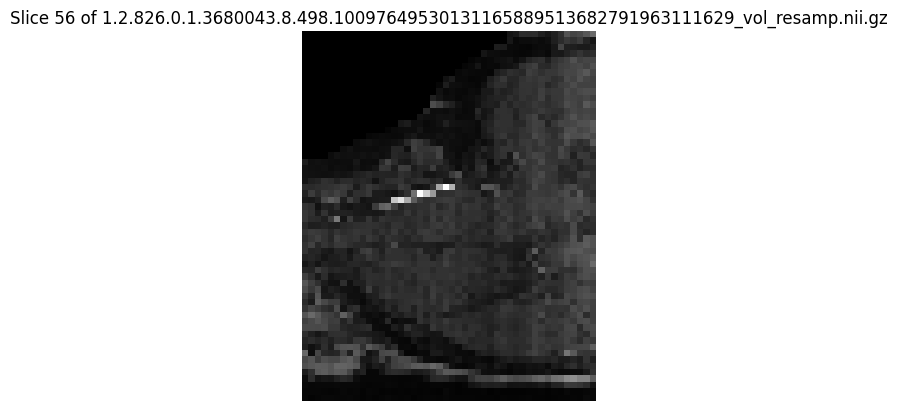

In [12]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# Define your output folder
output_dir = "/kaggle/working/resampled_output"  # put full path if different

# List all .nii.gz files
nii_files = sorted(glob.glob(os.path.join(output_dir, "*.nii.gz")))
print(f"Found {len(nii_files)} NIfTI files.")

# Pick one to display
file_to_check = nii_files[15]
print(f"Reading: {file_to_check}")

# Load the NIfTI file
nii = nib.load(file_to_check)
data = nii.get_fdata()  # 3D numpy array (z, y, x)
print("Shape:", data.shape)
print("Voxel size (mm):", nii.header.get_zooms())

# Visualize middle slice (axial)
mid_slice = data.shape[0] // 2
plt.imshow(data[mid_slice], cmap='gray')
plt.title(f"Slice {mid_slice} of {os.path.basename(file_to_check)}")
plt.axis('off')
plt.show()